# Microsoft  Malware Prediction

## 1. Imports

### 1.1. Libraries

In [11]:
#!pip install folium
#!pip install feature-engine
#!pip install category_encoders
#!pip install graphviz

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.metrics import accuracy_score
import category_encoders as ce

import folium
import plotly.express as px
from scipy import stats
from sklearn.tree import export_graphviz
import graphviz

set_config(transform_output = "pandas")

### 1.2. Data

In [12]:
file_dir = r'C:\Users\Usuario\Desktop\Proyects\Machine Learning\data'
file_name =  r"\sample_mmp.csv"
df = pd.read_csv(file_dir + file_name, sep = ",")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\1741553475.py:3: DtypeWarning: Columns (29,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir + file_name, sep = ",")


In [13]:
n_filas = int(len(df)*1)
df = df.sample(n = n_filas, random_state = 42)

## 2. Functions

In [14]:
def missing_percent(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(50)

def var_low_variance(dataframe):
    low_variance_cols = []
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        if len(unique_values) <= 2:
            value_counts = dataframe[column].value_counts(normalize=True, dropna = False)
            if len(value_counts) == 1 or (len(value_counts) == 2 and value_counts.max() >= 0.95):
                low_variance_cols.append(column)
    return low_variance_cols

def bolean_var(dataframe):
    bolean_vars = []
    for var in dataframe.columns:
        if df[var].nunique() == 2:
            bolean_vars.append(var)
    return bolean_vars


def setOthers_5(dataframe, column):
    top_categories = dataframe[column].value_counts().head(5)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

def setOthers(dataframe, column, num_values):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

def convert_cat_bool(df, col, prefix):
    new_column_name = f"{col}_{prefix}"
    df[new_column_name] = df[col].apply(lambda x: 1 if x.startswith(prefix) else 0)
    df.drop(columns=col, inplace=True)


def cat_explore_cl(dataframe, col, target):
    results_ = df.groupby([col]).agg(
        Num_rows = (col, 'count'),
        Total_infections = (target, np.sum),
        mode_target = (target, lambda x: x.mode()),
        pct_infections =  (target, np.mean)
        )
    return results_

def plot_cat_cl(dataframe, col, target):
    plt.figure(figsize=(17,7))
    sns.countplot(data = dataframe, x = col, hue = target)
    plt.xticks(rotation=45)
    plt.show()

def cat_analysis_cl(dataframe, col, target):
    plot_cat_cl(dataframe, col, target)
    return cat_explore_cl(dataframe, col, target)

def plot_biv_distrib(dataframe, col, target_bol):
    plt.figure(figsize=(15,5))
    sns.boxenplot(data = dataframe, 
                x = target_bol, 
                y = dataframe[col],
                )

def explore_num_values(dataframe, column, target_column, bin_size=10):
    bins = np.linspace(dataframe[column].min(), dataframe[column].max(), bin_size)
    dataframe['bin'] = pd.cut(dataframe[column], bins)
    _results_df = dataframe.groupby('bin').agg(
        n_rows=('bin', 'count'),
        mean_target=(target_column, 'mean')
    )
    _results_df['pct_rows'] = (_results_df['n_rows'] / len(dataframe)).round(3)
    return _results_df[['n_rows', 'pct_rows', 'mean_target']]

def plot_num_values(dataframe, col, target):
    plt.figure(figsize=(10,5))
    sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
    sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)
    plt.legend(
        labels={'Target True': 'Has detection', 'Target False': 'No has detection'}
    )
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'Distribution of {col} for each Target Value')
    return plt.show()

def num_analisys_cl(dataframe, col, target, bin_size):
    plot_num_values(dataframe, col, target)
    return explore_num_values(dataframe, col, target, bin_size)

## 3. EDA

### 3.1. General

In [15]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 104241 to 121958
Columns: 84 entries, Unnamed: 0 to HasDetections
dtypes: float64(36), int64(18), object(30)
memory usage: 324.2+ MB


In [16]:
df.shape

(500000, 84)

In [17]:
df.head()

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
104241,8627495,f790fe9aa6ddef7a6ec46ee482f0d1fb,win8defender,1.1.15100.1,4.18.1806.18062,1.273.416.0,0,7.0,0,NaN,...,51075.0,0,NaN,0.0,0,0,0.0,0.0,15.0,0
199676,8167114,ea57ce28051c4fc6a7bd1e0af12dd61a,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1795.0,0,7.0,0,NaN,...,11778.0,0,NaN,0.0,0,0,0.0,1.0,13.0,1
140199,3160987,5ab18e080c3910361a760d3da550e0ca,win8defender,1.1.14800.3,4.14.17639.18041,1.267.1158.0,0,7.0,0,NaN,...,48453.0,0,NaN,0.0,0,0,NaN,NaN,NaN,1
132814,6377321,b7076d643f0fca3d710d589f1b84d9fe,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1429.0,0,7.0,0,NaN,...,33098.0,1,NaN,0.0,0,0,0.0,NaN,NaN,0
408697,6403701,b7ca3352f5ed2b17ad5d56e96a4a9e8c,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1618.0,0,7.0,0,NaN,...,56985.0,0,0.0,0.0,0,0,0.0,0.0,10.0,1


In [18]:
df.duplicated().sum()

0

In [19]:
df.describe(include = 'object').T

,count,unique,top,freq
MachineIdentifier,500000,500000,f790fe9aa6ddef7a6ec46ee482f0d1fb,1
ProductName,500000,3,win8defender,494604
EngineVersion,500000,53,1.1.15200.1,216491
AppVersion,500000,95,4.18.1807.18075,288809
AvSigVersion,500000,6455,1.273.1420.0,5771
Platform,500000,4,windows10,483048
Processor,500000,3,x64,454423
OsVer,500000,21,10.0.0.0,483830
OsPlatformSubRelease,500000,9,rs4,220779
OsBuildLab,499999,453,17134.1.amd64fre.rs4_release.180410-1804,206436


In [20]:
df.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,500000.0,4.458888e+06,2.575619e+06,2.0,2227692.50,4461367.5,6.690936e+06,8.921471e+06
IsBeta,500000.0,2.000000e-06,1.414214e-03,0.0,0.00,0.0,0.000000e+00,1.000000e+00
RtpStateBitfield,498168.0,6.846207e+00,1.023049e+00,0.0,7.00,7.0,7.000000e+00,3.500000e+01
IsSxsPassiveMode,500000.0,1.724200e-02,1.301720e-01,0.0,0.00,0.0,0.000000e+00,1.000000e+00
DefaultBrowsersIdentifier,24061.0,1.652825e+03,1.004754e+03,1.0,788.00,1632.0,2.381000e+03,3.209000e+03
AVProductStatesIdentifier,498062.0,4.785091e+04,1.402309e+04,3.0,49480.00,53447.0,5.344700e+04,7.049200e+04
AVProductsInstalled,498062.0,1.326763e+00,5.229999e-01,1.0,1.00,1.0,2.000000e+00,5.000000e+00
AVProductsEnabled,498062.0,1.020714e+00,1.666080e-01,0.0,1.00,1.0,1.000000e+00,4.000000e+00
HasTpm,500000.0,9.878160e-01,1.097068e-01,0.0,1.00,1.0,1.000000e+00,1.000000e+00
CountryIdentifier,500000.0,1.080375e+02,6.306854e+01,1.0,51.00,97.0,1.620000e+02,2.220000e+02


In [21]:
#df_description_MMP = df.describe(include = 'all').T
#df_description_MMP.to_csv('MMP_description.csv')
#print("Archivo guardado en:", os.path.abspath('MMP_description.csv'))

In [22]:
missing_percent(df).head(41)
# Census_InternalBatteryType setothers(5)

,Total,Percent
PuaMode,499874,99.9748
Census_ProcessorClass,497918,99.5836
DefaultBrowsersIdentifier,475939,95.1878
Census_IsFlightingInternal,415225,83.0450
Census_InternalBatteryType,355603,71.1206
Census_ThresholdOptIn,318104,63.6208
Census_IsWIMBootEnabled,317666,63.5332
SmartScreen,178596,35.7192
OrganizationIdentifier,154563,30.9126
SMode,29848,5.9696


In [23]:
df1 = df.dropna(subset=['Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalPrimaryDiagonalDisplaySizeInInches'])

df1['Census_InternalPrimaryDisplayResolutionHorizontal'] = pd.to_numeric(df1['Census_InternalPrimaryDisplayResolutionHorizontal'], errors='coerce')
df1['Census_InternalPrimaryDisplayResolutionVertical'] = pd.to_numeric(df1['Census_InternalPrimaryDisplayResolutionVertical'], errors='coerce')
df1['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = pd.to_numeric(df1['Census_InternalPrimaryDisplayResolutionVertical'], errors='coerce')
corr_matrix = df1[['Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalPrimaryDiagonalDisplaySizeInInches']].corr()
corr_matrix

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3244463171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Census_InternalPrimaryDisplayResolutionHorizontal'] = pd.to_numeric(df1['Census_InternalPrimaryDisplayResolutionHorizontal'], errors='coerce')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3244463171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Census_InternalPrimaryDisplayResolutionVertical'] = pd.to_numeric(df1['Census_InternalPrimaryDisplayResolutionVertical'], errors=

,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalPrimaryDiagonalDisplaySizeInInches
Census_InternalPrimaryDisplayResolutionHorizontal,1.000000,0.898235,0.898235
Census_InternalPrimaryDisplayResolutionVertical,0.898235,1.000000,1.000000
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.898235,1.000000,1.000000


In [24]:
imput_constant_1 = ['Census_IsWIMBootEnabled', 'SMode', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Census_ProcessorManufacturerIdentifier',
                    'Census_OSInstallLanguageIdentifier']
imput_constant_0 = ['CityIdentifier', 'Wdft_RegionIdentifier', 'IsProtected', 'Firewall']
imput_xtrem = ['Census_OEMModelIdentifier', 'Census_OEMNameIdentifier']
imput_most_frequent = ['Wdft_IsGamer', 'Census_IsVirtualDevice','Census_InternalBatteryNumberOfCharges']

cols_s_imputers = ['Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_PrimaryDiskTotalCapacity', 'AVProductsEnabled', 'Census_FirmwareManufacturerIdentifier', 'AVProductsInstalled']
cols_to_median = ['Census_ProcessorModelIdentifier', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']
set_others_5 = ['Census_InternalBatteryType', 'SmartScreen', 'OrganizationIdentifier',
                'Census_ProcessorCoreCount', 'AVProductStatesIdentifier']

imput_mean = ['Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_PrimaryDiskTotalCapacity', 'Census_FirmwareVersionIdentifier']

cols_to_drop = ['Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 
                'Census_ThresholdOptIn', 'Census_IsFlightsDisabled', 'Census_InternalPrimaryDisplayResolutionHorizontal',
                'Census_InternalPrimaryDisplayResolutionVertical',
                'UacLuaenable' ] + imput_constant_1 + imput_constant_0 + imput_xtrem +imput_most_frequent + cols_s_imputers + cols_to_median + imput_mean


df[set_others_5] =df[set_others_5].astype('object')


#### 3.1.1. Low variance variables

In [25]:
low_variance_cols = var_low_variance(df)
print(low_variance_cols)

['IsBeta', 'IsSxsPassiveMode', 'HasTpm', 'AutoSampleOptIn', 'PuaMode', 'Census_IsPortableOperatingSystem', 'Census_IsPenCapable']


In [26]:
df.drop(low_variance_cols, axis = 1, inplace = True)

In [27]:
bolean_vars = bolean_var(df)
bolean_vars


['IsProtected',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_ThresholdOptIn',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

### 3.2. Target

In [28]:
TARGET = 'HasDetections'
df[TARGET].value_counts(normalize = True, dropna = False)

0    0.500094
1    0.499906
Name: HasDetections, dtype: float64

### 3.3. Nulls

In [29]:
# SET_OTHERS IMPUTERS

for col in set_others_5:
    df[col] = setOthers_5(df, col)

In [30]:

df['IeVerIdentifier_so8'] = setOthers(df, 'IeVerIdentifier', 8)
df['Census_ChassisTypeName_so7'] = setOthers(df, 'Census_ChassisTypeName', 7)
df['RtpStateBitfield_so2'] = setOthers(df, 'RtpStateBitfield', 2)
df['Census_PrimaryDiskTypeName_so2'] = setOthers(df, 'Census_PrimaryDiskTypeName', 2)

df.drop(['IeVerIdentifier', 'Census_ChassisTypeName', 'RtpStateBitfield', 'Census_PrimaryDiskTypeName'], axis =1 , inplace=True)

In [31]:
na_imputer = ColumnTransformer(
    transformers = [
        ('imput_1', SimpleImputer(strategy= 'constant', fill_value = 1), imput_constant_1),
        ('imput_0', SimpleImputer(strategy= 'constant', fill_value = 0), imput_constant_0),
        ('imput_xtr', SimpleImputer(strategy= 'constant', fill_value = 99999), imput_xtrem),
        ('imput_median', SimpleImputer(strategy = 'median'), cols_to_median),
        ('imput_93', SimpleImputer(strategy= 'constant', fill_value = 93), ['Census_FirmwareManufacturerIdentifier']),
        ('AV_prodinst_imputed', SimpleImputer(strategy= 'constant', fill_value = 3), ['AVProductsInstalled']),
        ('imp_m_freq', SimpleImputer(strategy =  'most_frequent'), imput_most_frequent),
        ('imput_mean', SimpleImputer(strategy =  'mean'), imput_mean)
    ]
)


In [32]:
df_imputed = na_imputer.fit_transform(df)
df = df.merge(df_imputed, left_index = True, right_index = True)
df.drop(cols_to_drop, axis = 1, inplace = True)


In [33]:
missing_percent(df).head()

,Total,Percent
GeoNameIdentifier,16,0.0032
Census_PowerPlatformRoleName,2,0.0004
OsBuildLab,1,0.0002
Census_IsSecureBootEnabled,0,0.0000
Census_IsTouchEnabled,0,0.0000


In [34]:
bolean_var(df)

['Census_HasOpticalDiskDrive',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled',
 'HasDetections',
 'imput_1__Census_IsWIMBootEnabled',
 'imput_1__SMode',
 'imput_1__Census_IsAlwaysOnAlwaysConnectedCapable',
 'imput_0__IsProtected',
 'imput_0__Firewall',
 'imp_m_freq__Wdft_IsGamer',
 'imp_m_freq__Census_IsVirtualDevice']

In [35]:
df.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,500000.0,4.458888e+06,2.575619e+06,2.0,2227692.5,4461367.5,6.690936e+06,8.921471e+06
CountryIdentifier,500000.0,1.080375e+02,6.306854e+01,1.0,51.0,97.0,1.620000e+02,2.220000e+02
GeoNameIdentifier,499984.0,1.697304e+02,8.932517e+01,1.0,89.0,181.0,2.670000e+02,2.960000e+02
LocaleEnglishNameIdentifier,500000.0,1.226110e+02,6.930317e+01,1.0,74.0,88.0,1.820000e+02,2.830000e+02
OsBuild,500000.0,1.572693e+04,2.188646e+03,7600.0,15063.0,16299.0,1.713400e+04,1.824200e+04
OsSuite,500000.0,5.747186e+02,2.482033e+02,16.0,256.0,768.0,7.680000e+02,7.840000e+02
Census_HasOpticalDiskDrive,500000.0,7.703400e-02,2.666457e-01,0.0,0.0,0.0,0.000000e+00,1.000000e+00
Census_OSBuildNumber,500000.0,1.584137e+04,1.959440e+03,9600.0,15063.0,16299.0,1.713400e+04,1.824200e+04
Census_OSBuildRevision,500000.0,9.672248e+02,2.920628e+03,0.0,165.0,285.0,5.470000e+02,1.906900e+04
Census_OSUILocaleIdentifier,500000.0,6.044631e+01,4.500042e+01,1.0,31.0,34.0,9.000000e+01,1.620000e+02


### 3.4. Univariant & Bivariant Analysis

### 3.4.1. Categortical

#### MachineIdentifier

In [36]:
df['MachineIdentifier'].value_counts() # primary key

f790fe9aa6ddef7a6ec46ee482f0d1fb    1
1dedc2af7deaeb73e04c81770552dcc0    1
1b983d403b15f8b5447b90748264cb93    1
060d6d6112e18b4439ddec2ebfffa735    1
da8dfcd0eb4b193d8502cd030dcd03e8    1
                                   ..
d7314ed55094977246928f42d6503b77    1
929c09311b37734051a2a530ce0704b5    1
aa10cae6f496577f7474c0c3496f5bd9    1
7799407f16039a2d972ddd17811f5fde    1
88cd798b2363fe2707aa04b6232692ad    1
Name: MachineIdentifier, Length: 500000, dtype: int64

#### Product Name

#### EngineVersion

In [37]:
convert_cat_bool(df, 'EngineVersion', '1.1.15')

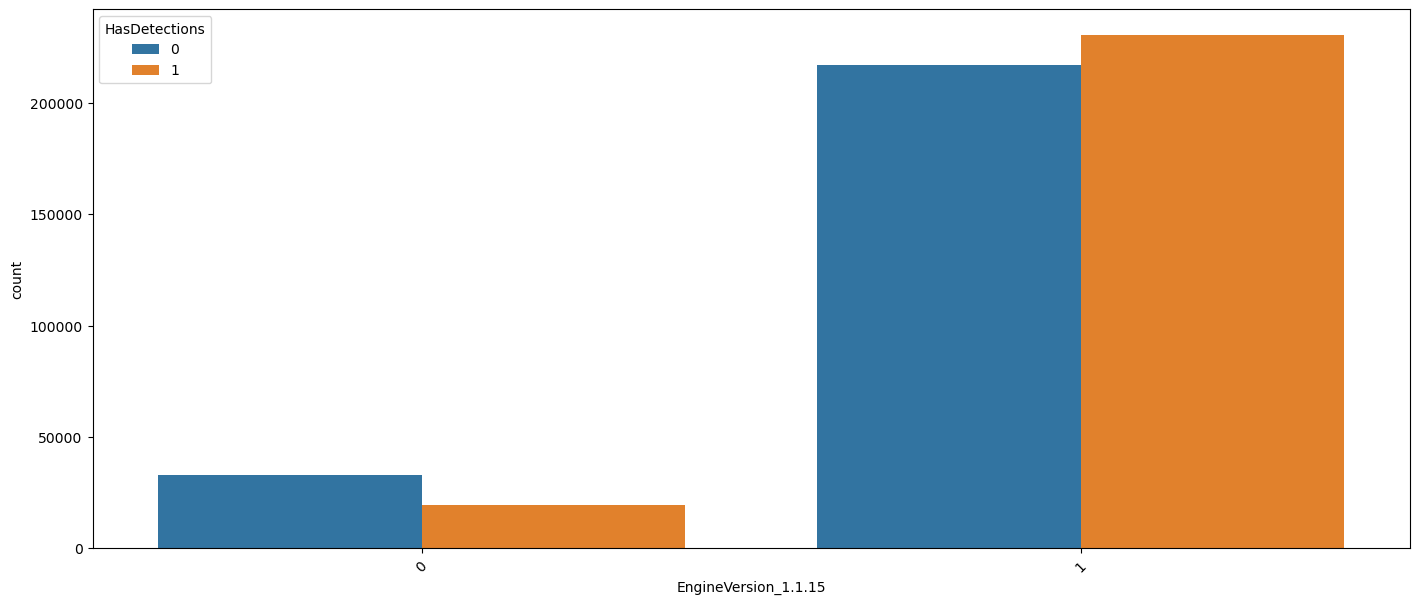

,Num_rows,Total_infections,mode_target,pct_infections
EngineVersion_1.1.15,,,,
0,52473,19557,0,0.372706
1,447527,230396,1,0.514820


In [38]:
cat_analysis_cl(df, 'EngineVersion_1.1.15', TARGET)

#### AppVersion

In [39]:
#df['AppVersion'].value_counts()

In [40]:
convert_cat_bool(df, 'AppVersion', '4.18')

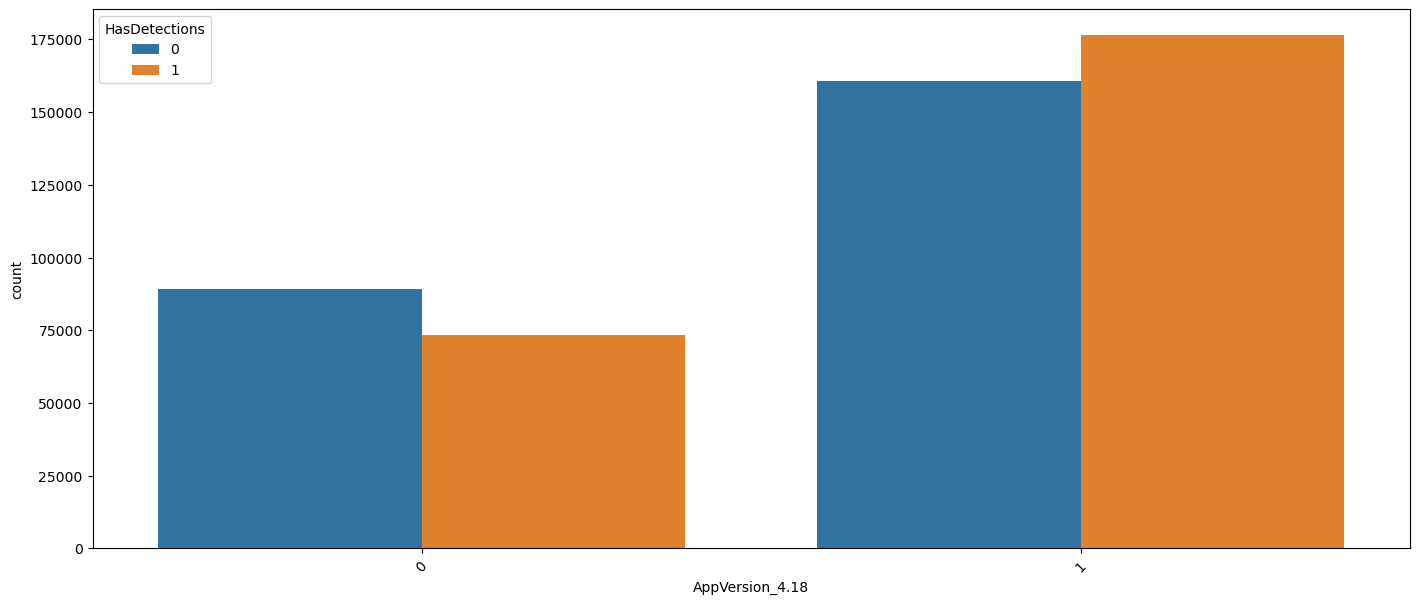

,Num_rows,Total_infections,mode_target,pct_infections
AppVersion_4.18,,,,
0,162757,73484,0,0.451495
1,337243,176469,1,0.523270


In [41]:
cat_analysis_cl(df, 'AppVersion_4.18', TARGET)


#### AvSigVersion

In [42]:
df['AvSigVersion'] = df['AvSigVersion'].apply(lambda x: x[:5])
df['AvSigVersion'].value_counts().head(10)

1.275    219654
1.273    208206
1.271     15005
1.269     12092
1.263      9004
1.267      7674
1.251      5251
1.277      4478
1.237      3873
1.261      2761
Name: AvSigVersion, dtype: int64

In [43]:
old_cols_drop = []
df['AvSigVersion_so4'] = setOthers(df, 'AvSigVersion', 4).astype('str')
old_cols_drop.append('AvSigVersion')
df['AvSigVersion_so4'].value_counts()

1.275     219654
1.273     208206
Others     45043
1.271      15005
1.269      12092
Name: AvSigVersion_so4, dtype: int64

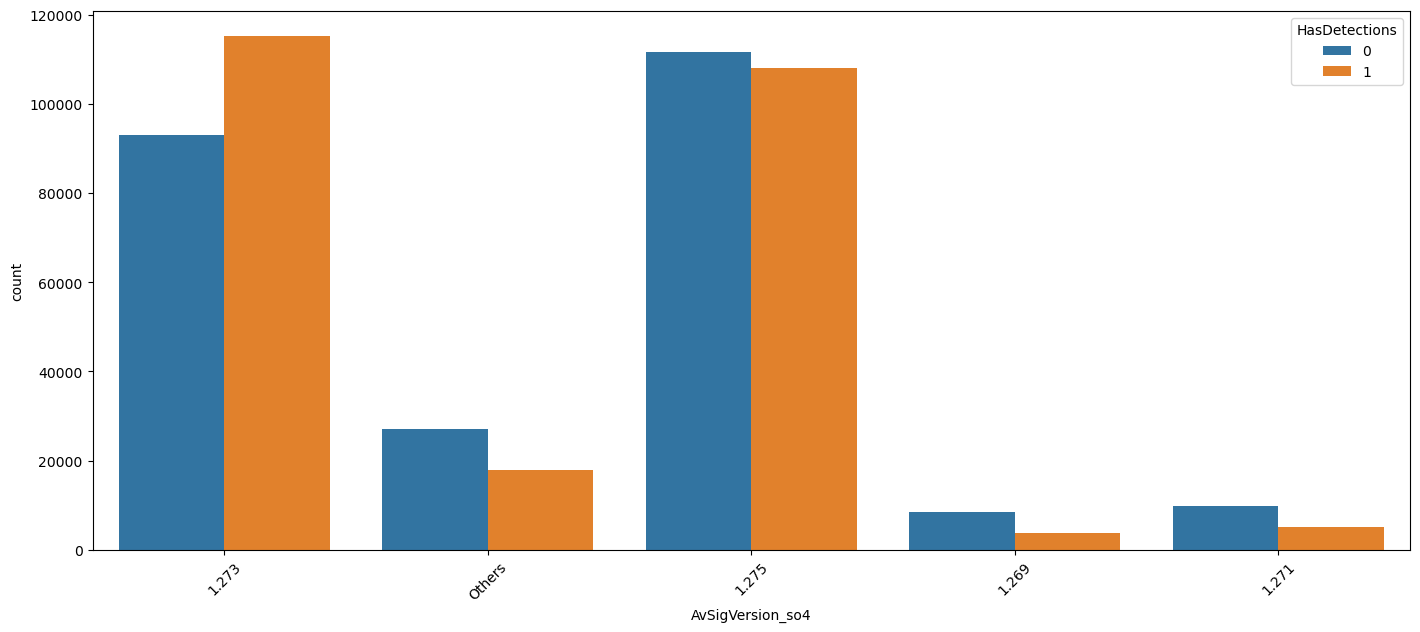

,Num_rows,Total_infections,mode_target,pct_infections
AvSigVersion_so4,,,,
1.269,12092,3699,0,0.305905
1.271,15005,5124,0,0.341486
1.273,208206,115120,1,0.552914
1.275,219654,108080,0,0.492047
Others,45043,17930,0,0.398064


In [44]:
cat_analysis_cl(df, 'AvSigVersion_so4', TARGET)

In [45]:
df['AvSigVersion_so4']

104241     1.273
199676     1.273
140199    Others
132814     1.275
408697     1.273
           ...  
259178     1.275
365838     1.273
131932     1.275
146867     1.275
121958     1.275
Name: AvSigVersion_so4, Length: 500000, dtype: object

In [46]:
trans_ordinal = []
trans_ordinal.append('AvSigVersion_so4')

#### RtpStateBitfield

In [47]:
df['RtpStateBitfield'] = df['RtpStateBitfield_so2'].astype('str')
convert_cat_bool(df, 'RtpStateBitfield', '7.0')
old_cols_drop.append('RtpStateBitfield_so2')

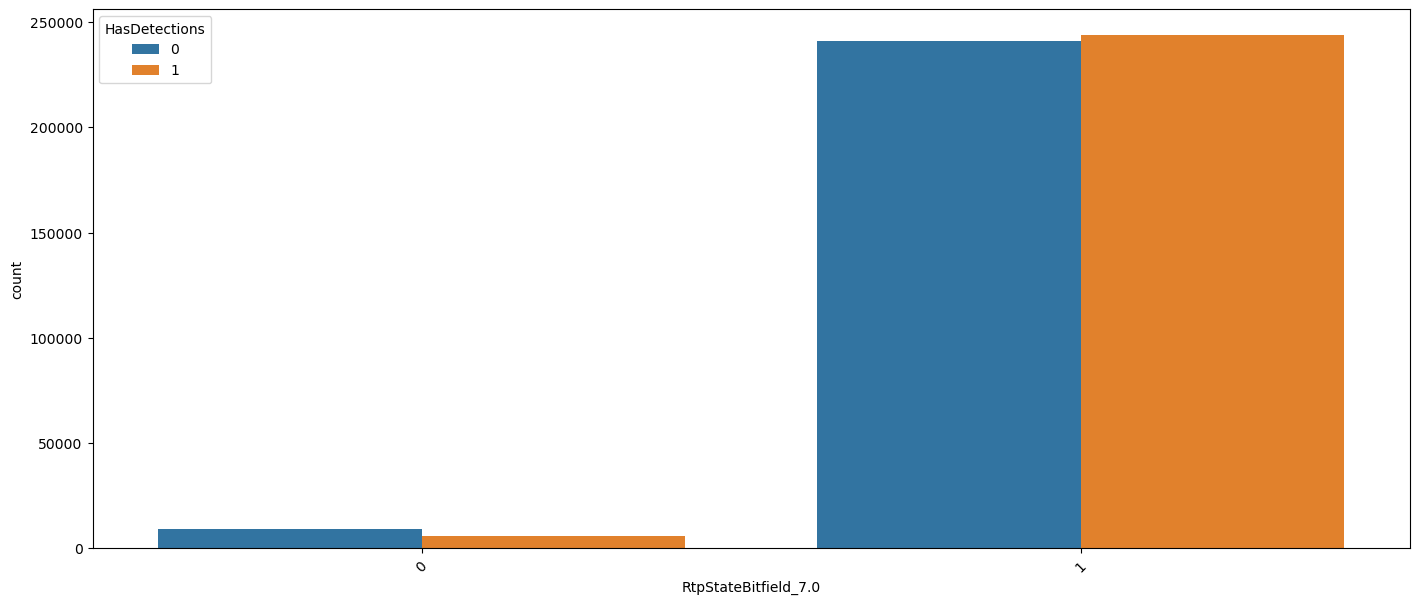

,Num_rows,Total_infections,mode_target,pct_infections
RtpStateBitfield_7.0,,,,
0,15159,6098,0,0.402269
1,484841,243855,1,0.502959


In [48]:
cat_analysis_cl(df, 'RtpStateBitfield_7.0', TARGET)

#### AVProductStatesIdentifier

In [49]:
df['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier'].astype('str')
convert_cat_bool(df, 'AVProductStatesIdentifier', '53447')

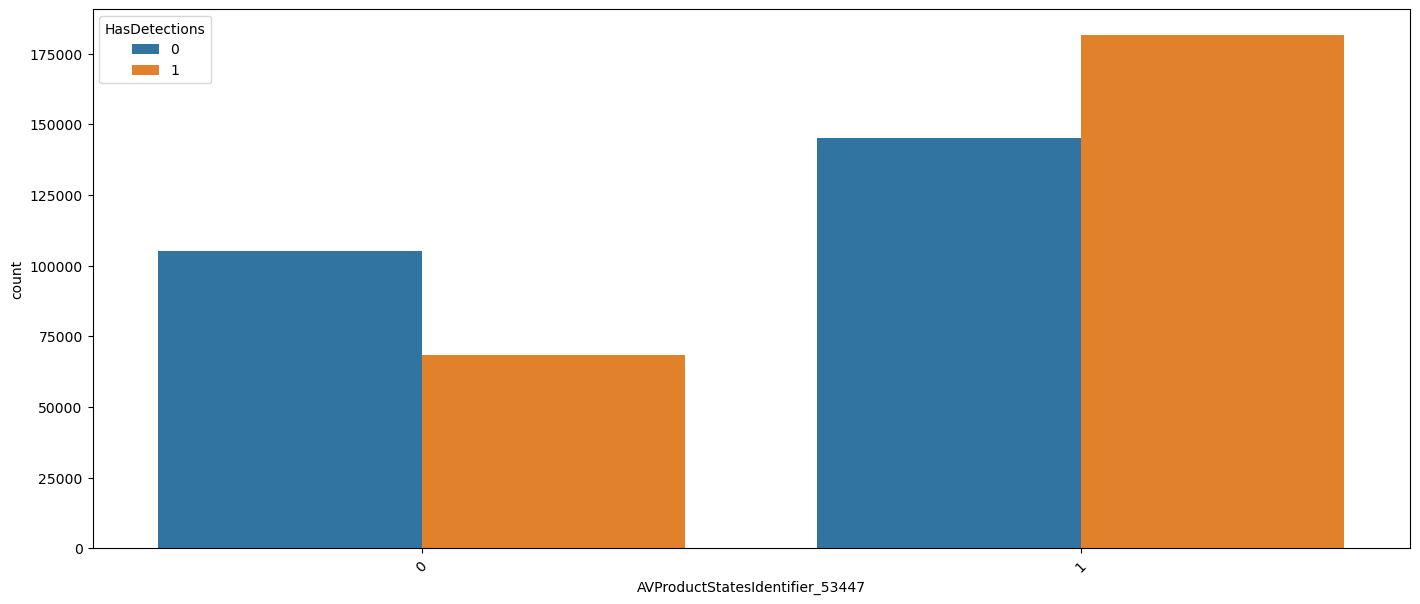

,Num_rows,Total_infections,mode_target,pct_infections
AVProductStatesIdentifier_53447,,,,
0,173537,68436,0,0.394360
1,326463,181517,1,0.556011


In [50]:
cat_analysis_cl(df, 'AVProductStatesIdentifier_53447', TARGET)

#### CountryIdentifier

In [51]:
frecuency = df['CountryIdentifier'].value_counts()

country_gr = lambda valor: 'others <50' if frecuency[valor] < 50 else ('others < 100' if 50 <= frecuency[valor] < 100 else valor)
df['CountryId_group'] = df['CountryIdentifier'].apply(country_gr).astype(str)
old_cols_drop.append('CountryIdentifier')

In [52]:
cat_explore_cl(df, 'CountryId_group', TARGET)

,Num_rows,Total_infections,mode_target,pct_infections
CountryId_group,,,,
1,117,59,1,0.504274
100,1654,886,1,0.535671
101,4590,2057,0,0.448148
102,1383,595,0,0.430224
103,204,117,1,0.573529
...,...,...,...,...
96,468,159,0,0.339744
97,10883,5278,0,0.484977
99,1101,511,0,0.464124


In [53]:
trans_frecuency = ['CountryId_group']

#### CityIdentifier

In [54]:
df['imput_0__CityIdentifier'] = df['imput_0__CityIdentifier'].astype('str')

In [55]:
def cat_top30_analysis(dataframe, col, target):
    top30 = dataframe[col].value_counts().head(30)
    data_top_30 = dataframe[dataframe[col].isin(top30.index)]
    return cat_analysis_cl(data_top_30, col, target)

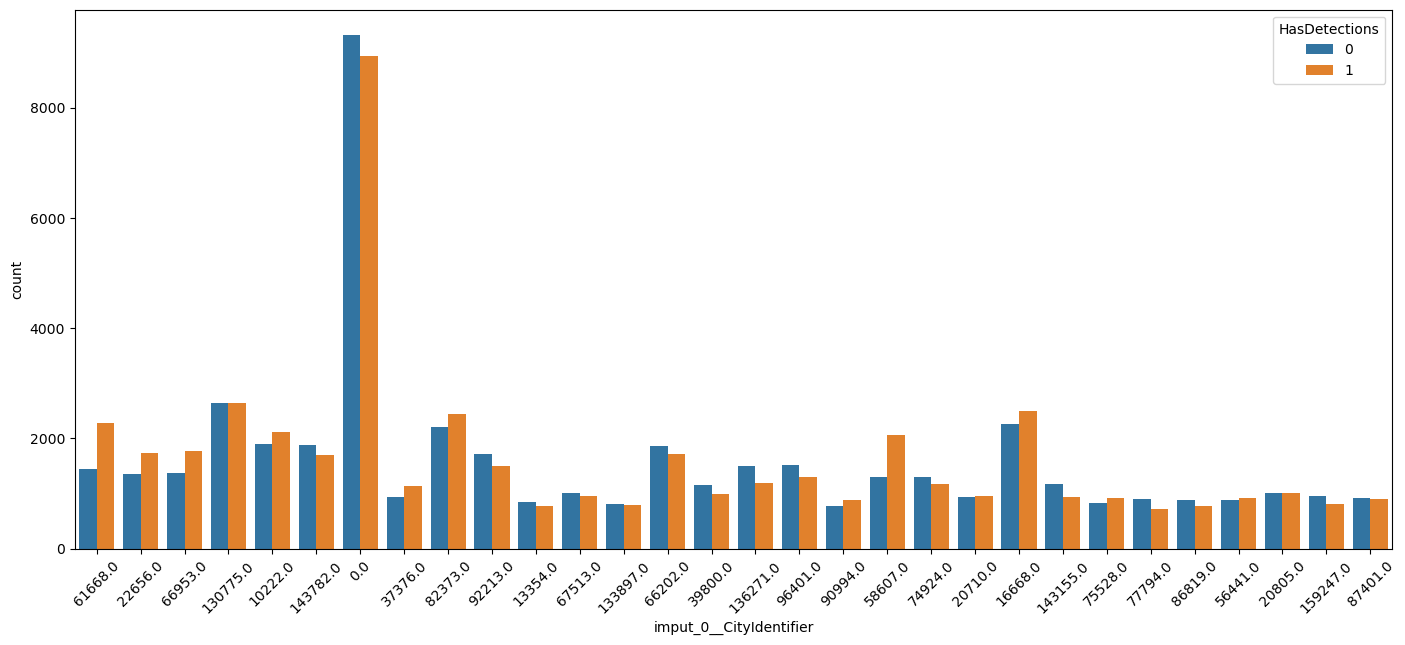

,Num_rows,Total_infections,mode_target,pct_infections
imput_0__CityIdentifier,,,,
0.0,18240,8929,0,0.489529
100000.0,2,0,0,0.000000
100009.0,2,0,0,0.000000
100012.0,3,2,1,0.666667
100030.0,28,11,0,0.392857
...,...,...,...,...
9998.0,2,1,"[0, 1]",0.500000
99980.0,1,1,1,1.000000
99990.0,1,0,0,0.000000


In [56]:
cat_top30_analysis(df, 'imput_0__CityIdentifier', TARGET)

In [57]:
trans_frecuency.append('imput_0__CityIdentifier')

#### OrganizationIdentifier

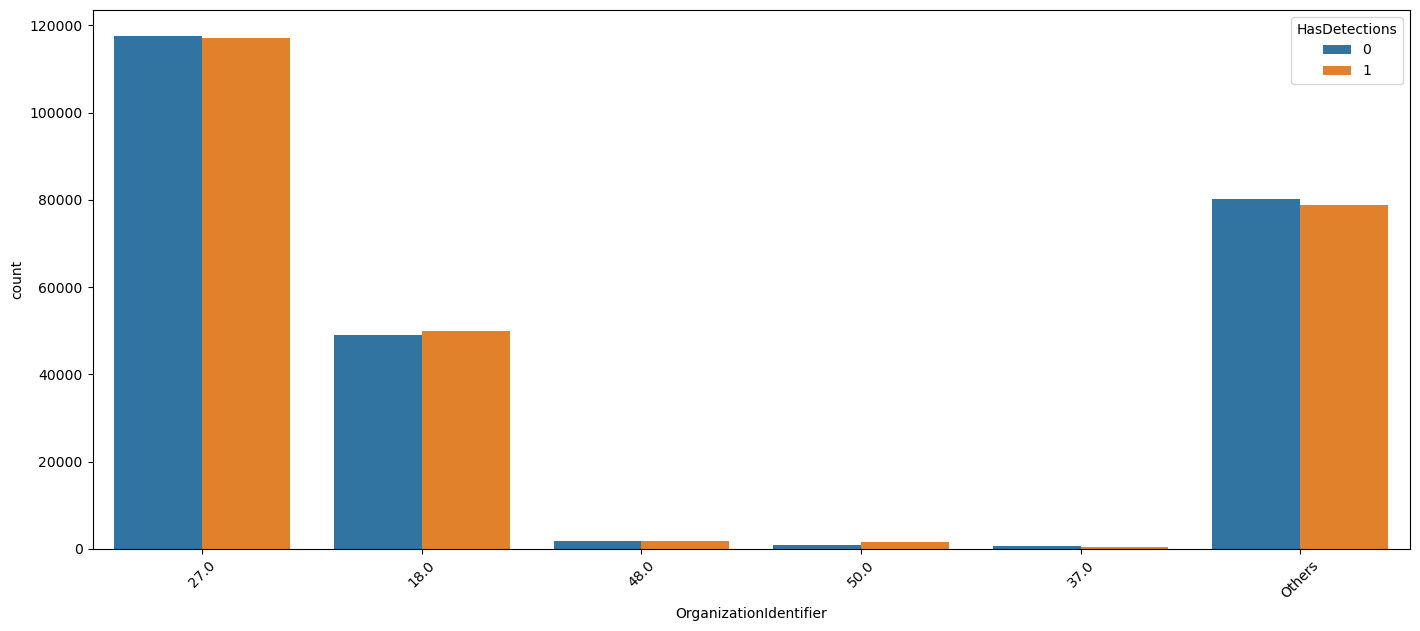

,Num_rows,Total_infections,mode_target,pct_infections
OrganizationIdentifier,,,,
27.0,234885,117224,0,0.499070
18.0,98842,49863,1,0.504472
48.0,3658,1885,1,0.515309
50.0,2538,1565,1,0.616627
37.0,1048,485,0,0.462786
Others,159029,78931,0,0.496331


In [58]:
cat_analysis_cl(df, 'OrganizationIdentifier', TARGET)

In [59]:
trans_frecuency.append('OrganizationIdentifier')

#### GeoNameIdentifier

In [60]:
df['GeoNameIdentifier_so45'] = setOthers(df, 'GeoNameIdentifier', 45).astype('str')
old_cols_drop.append('GeoNameIdentifier')

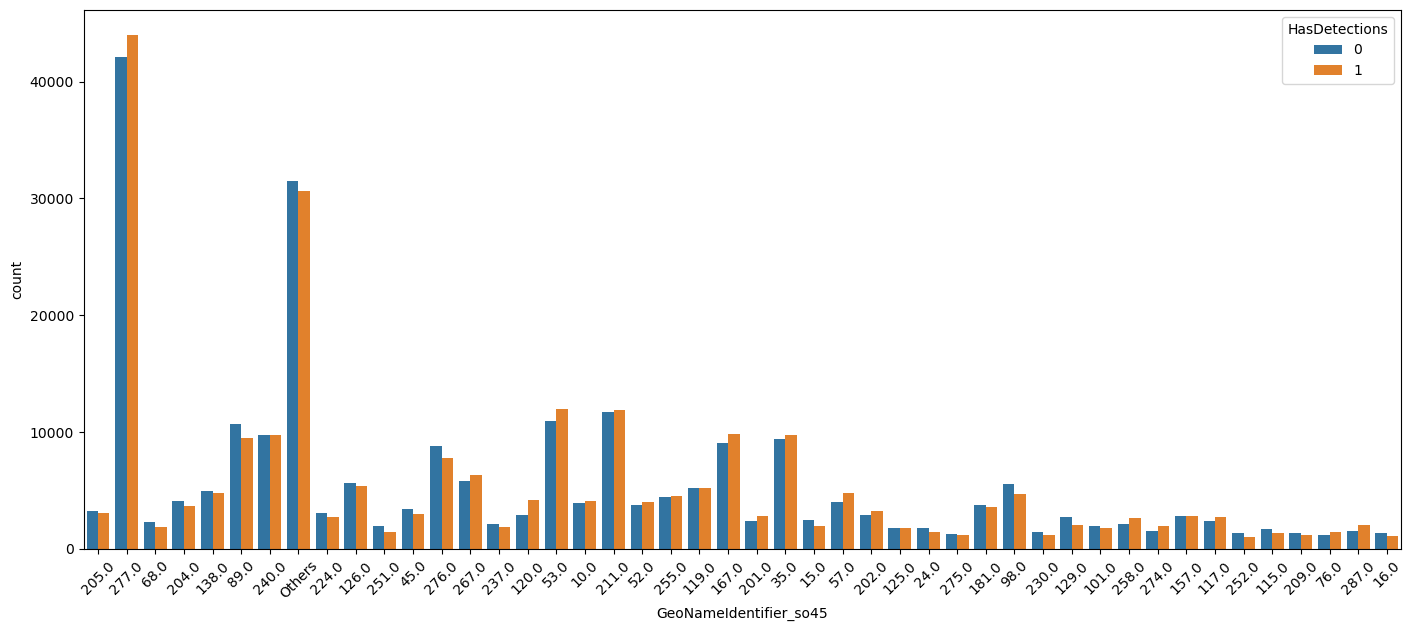

,Num_rows,Total_infections,mode_target,pct_infections
GeoNameIdentifier_so45,,,,
10.0,8008,4063,1,0.507368
101.0,3766,1802,0,0.478492
115.0,3038,1379,0,0.453917
117.0,5052,2682,1,0.530879
119.0,10419,5198,0,0.498896
120.0,7104,4220,1,0.594032
125.0,3611,1805,0,0.499862
126.0,11028,5357,0,0.485764
129.0,4800,2048,0,0.426667


In [61]:
cat_analysis_cl(df, 'GeoNameIdentifier_so45', TARGET)

In [62]:
trans_ordinal.append('GeoNameIdentifier_so45')

#### LocaleEnglishNameIdentifier

In [63]:
df['LocaleEnglishNameIdentifier_so35'] = setOthers(df, 'LocaleEnglishNameIdentifier', 35).astype('str')
old_cols_drop.append('LocaleEnglishNameIdentifier')

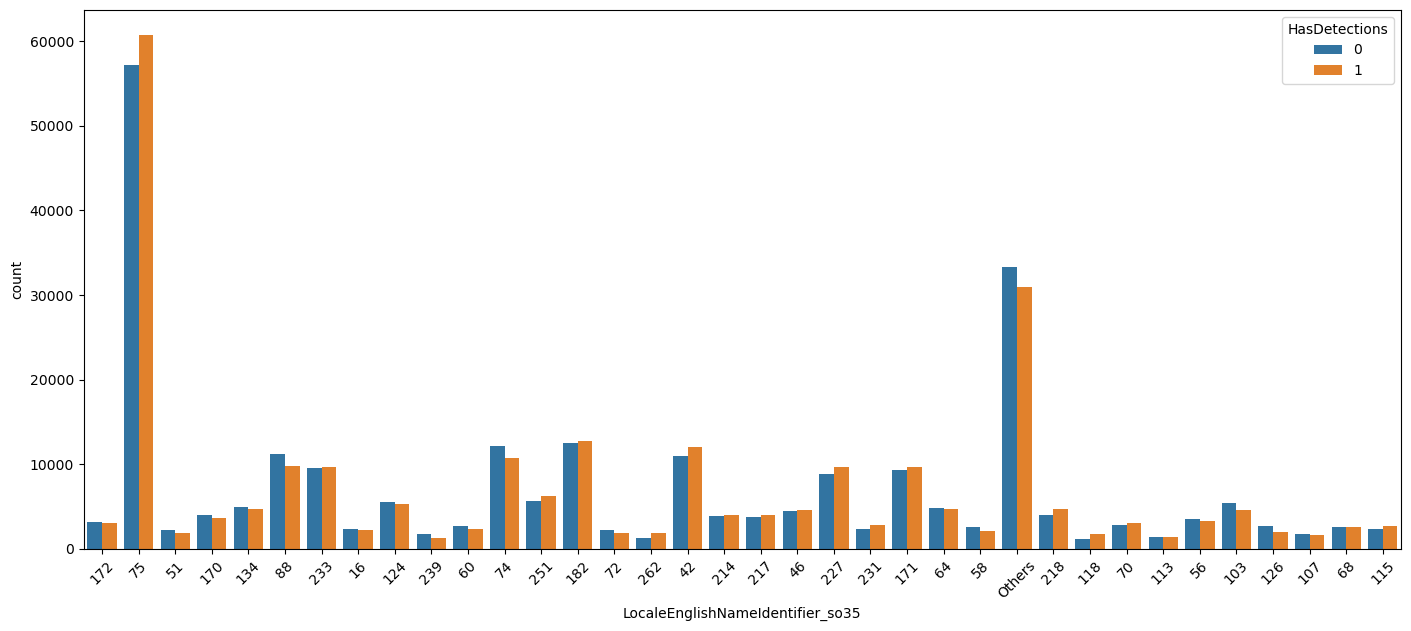

,Num_rows,Total_infections,mode_target,pct_infections
LocaleEnglishNameIdentifier_so35,,,,
103,10035,4608,0,0.459193
107,3315,1572,0,0.474208
113,2811,1402,0,0.498755
115,4953,2639,1,0.532808
118,2932,1756,1,0.598909
124,10843,5274,0,0.486397
126,4776,2031,0,0.425251
134,9700,4740,0,0.488660
16,4494,2168,0,0.482421


In [64]:
cat_analysis_cl(df, 'LocaleEnglishNameIdentifier_so35', TARGET)

In [65]:
trans_ordinal.append('LocaleEnglishNameIdentifier_so35')

#### Platform

In [66]:
#df['Platform'].value_counts()

In [67]:
convert_cat_bool(df, 'Platform', 'windows10')

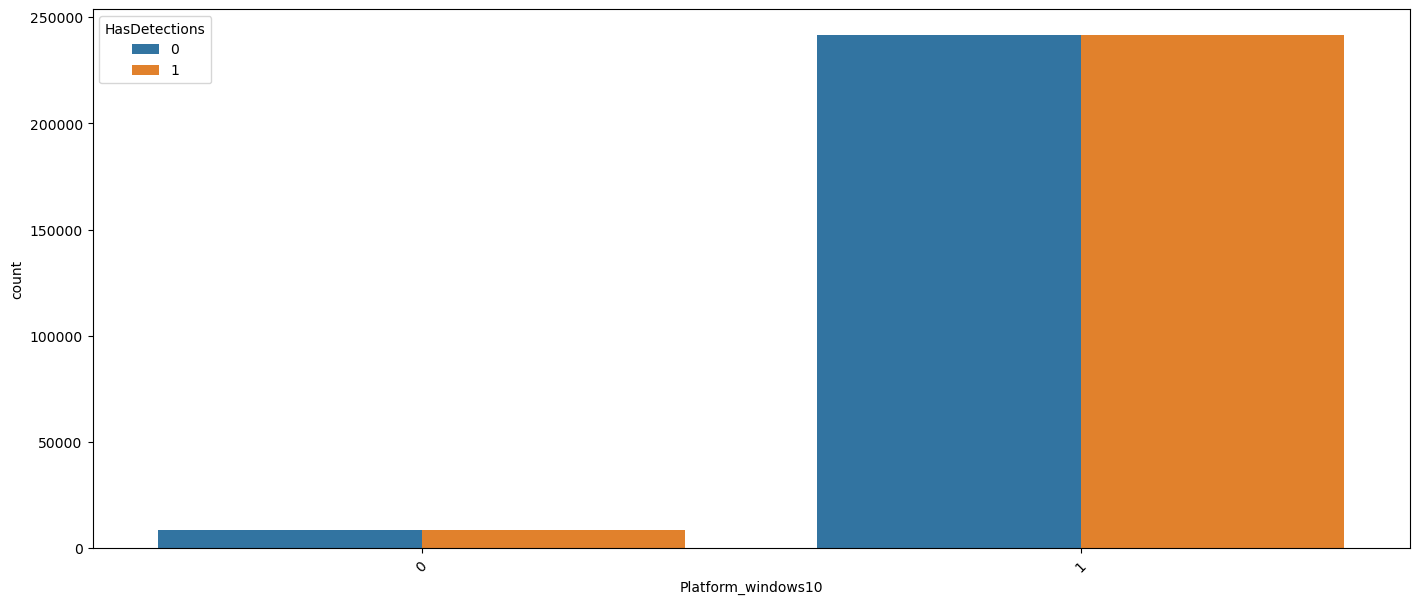

,Num_rows,Total_infections,mode_target,pct_infections
Platform_windows10,,,,
0,16952,8477,1,0.500059
1,483048,241476,0,0.499901


In [68]:
cat_analysis_cl(df,'Platform_windows10', TARGET)

#### Processor

In [69]:
convert_cat_bool(df, 'Processor', 'x64')

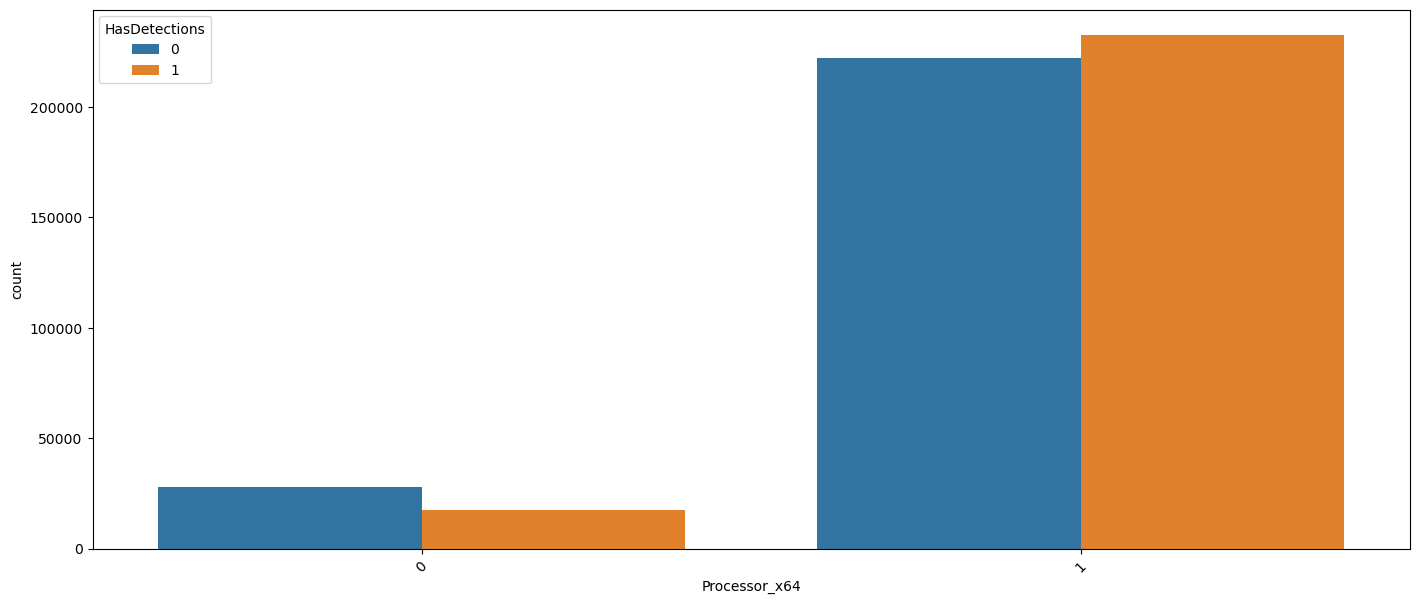

,Num_rows,Total_infections,mode_target,pct_infections
Processor_x64,,,,
0,45577,17632,0,0.386862
1,454423,232321,1,0.511244


In [70]:
cat_analysis_cl(df,'Processor_x64', TARGET)

#### OsVer

In [71]:
convert_cat_bool(df, 'OsVer', '10')

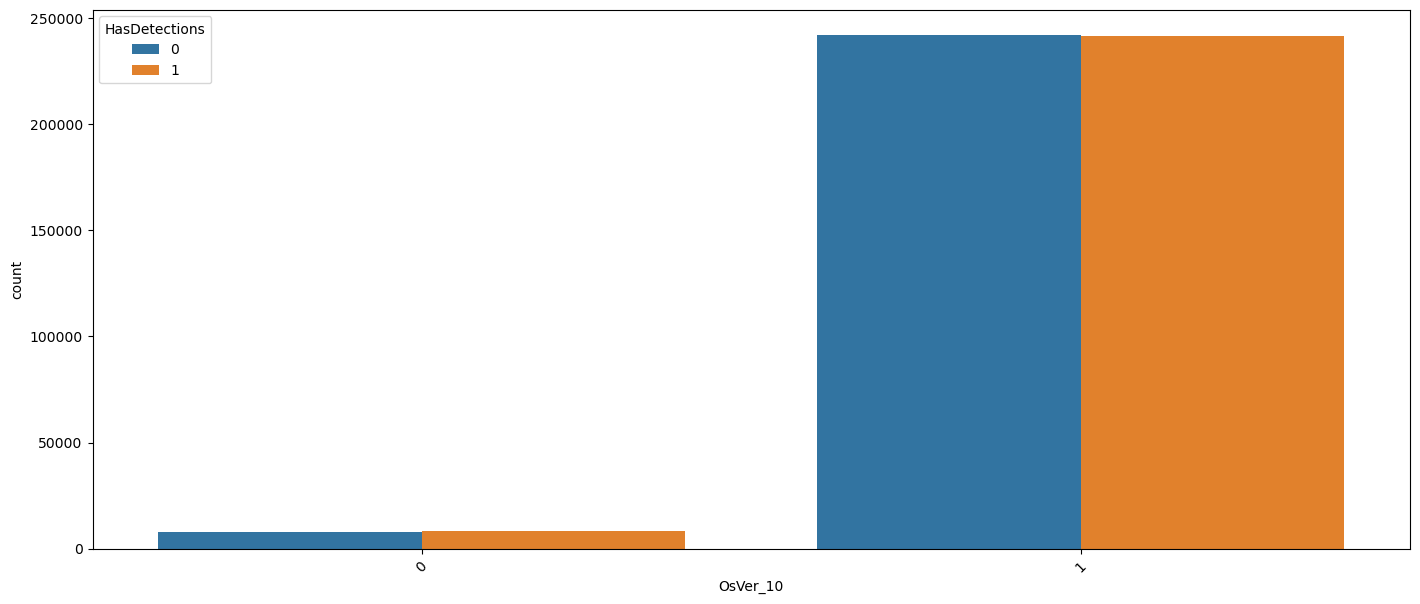

,Num_rows,Total_infections,mode_target,pct_infections
OsVer_10,,,,
0,16139,8176,1,0.506599
1,483861,241777,0,0.499683


In [72]:
cat_analysis_cl(df,'OsVer_10', TARGET)

#### OsBuild

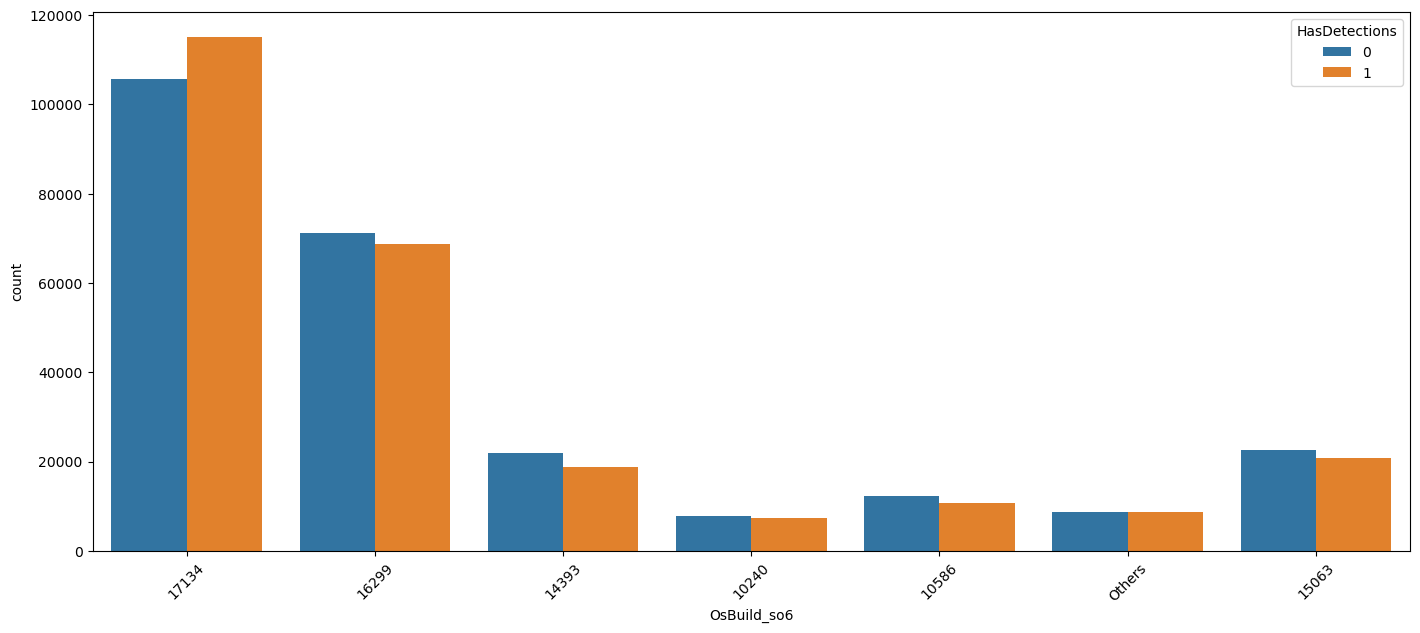

,Num_rows,Total_infections,mode_target,pct_infections
OsBuild_so6,,,,
10240,15014,7309,0,0.486812
10586,22955,10608,0,0.462122
14393,40717,18848,0,0.462902
15063,43352,20778,0,0.479286
16299,139901,68735,0,0.491312
17134,220779,114996,1,0.520865
Others,17282,8679,1,0.502199


In [73]:
df['OsBuild_so6'] = setOthers(df, 'OsBuild', 6).astype('str')
old_cols_drop.append('OsBuild')

cat_analysis_cl(df, 'OsBuild_so6', TARGET)


In [74]:
trans_ordinal.append('OsBuild_so6')

#### OsSuite

In [75]:
df['OsSuite'] = df['OsSuite'].astype('str')

convert_cat_bool(df, 'OsSuite', '768')

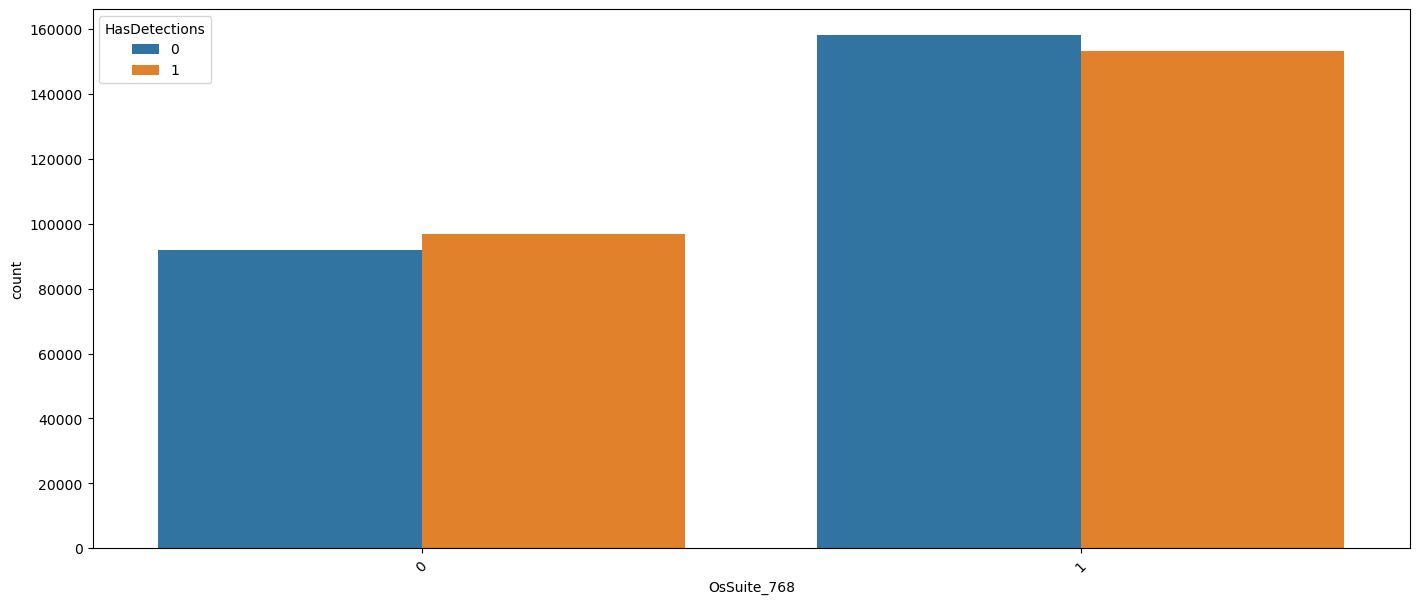

,Num_rows,Total_infections,mode_target,pct_infections
OsSuite_768,,,,
0,188774,96768,1,0.512613
1,311226,153185,0,0.492199


In [76]:
cat_analysis_cl(df, 'OsSuite_768', TARGET)


#### OsPlatformSubRelease

In [77]:
#df['OsPlatformSubRelease'].value_counts()

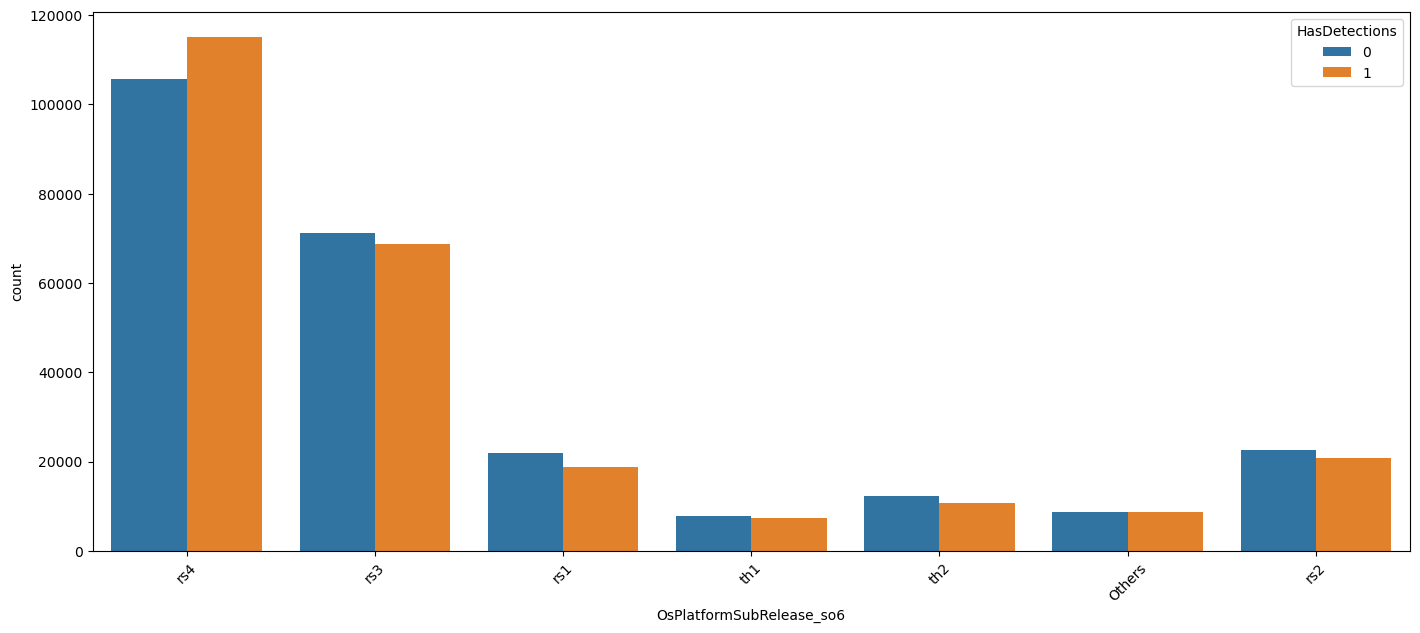

,Num_rows,Total_infections,mode_target,pct_infections
OsPlatformSubRelease_so6,,,,
Others,17282,8679,1,0.502199
rs1,40717,18848,0,0.462902
rs2,43352,20778,0,0.479286
rs3,139901,68735,0,0.491312
rs4,220779,114996,1,0.520865
th1,15014,7309,0,0.486812
th2,22955,10608,0,0.462122


In [78]:
df['OsPlatformSubRelease_so6'] = setOthers(df, 'OsPlatformSubRelease', 6).astype('str')
old_cols_drop.append('OsPlatformSubRelease')

cat_analysis_cl(df, 'OsPlatformSubRelease_so6', TARGET)

In [79]:
trans_ordinal.append('OsPlatformSubRelease_so6')

#### OsBuildLab

In [80]:
#df['OsBuildLab'].value_counts().head(10)

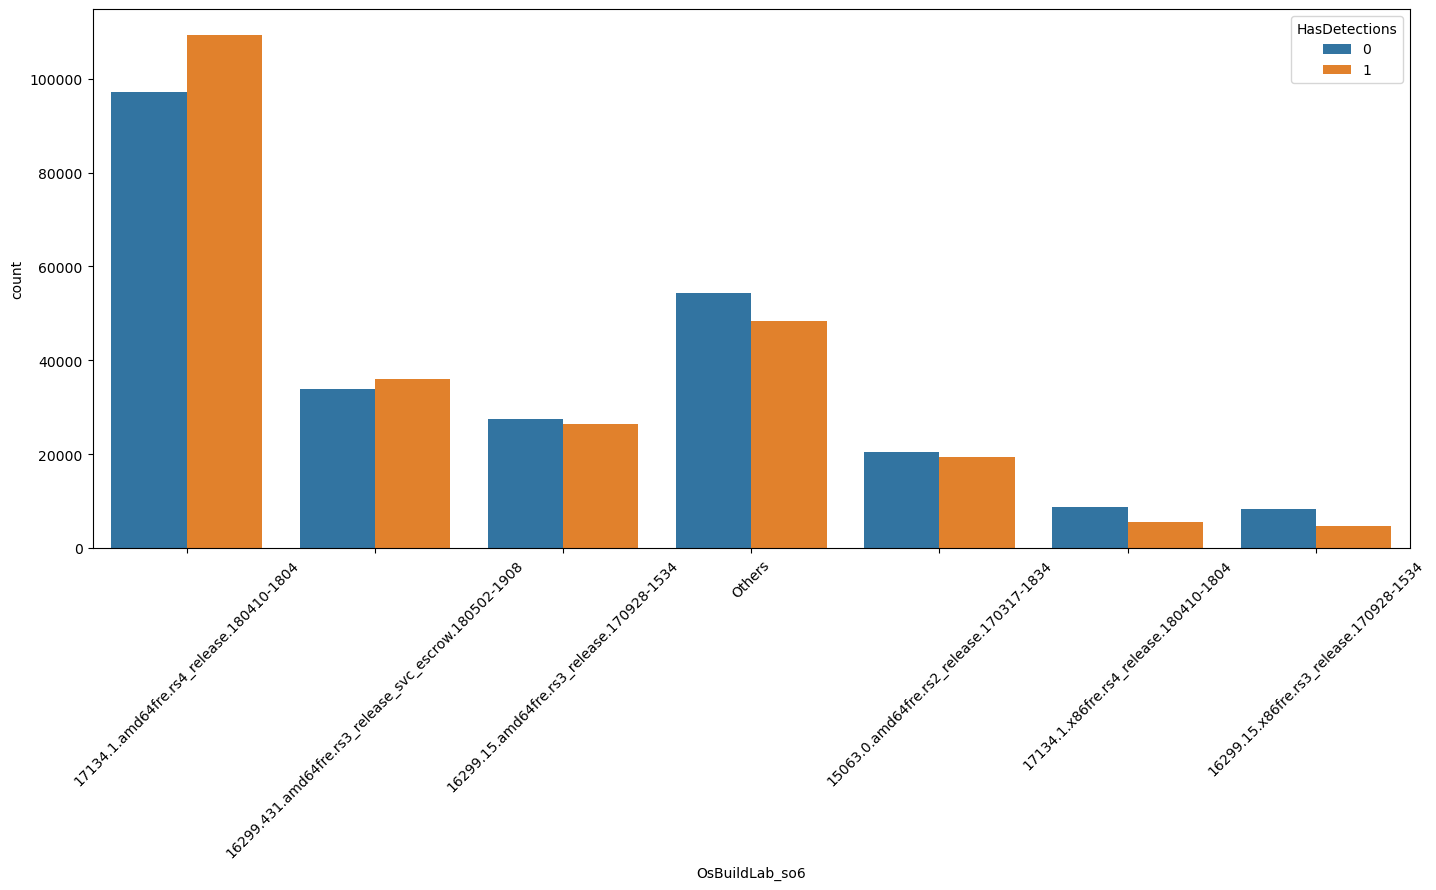

,Num_rows,Total_infections,mode_target,pct_infections
OsBuildLab_so6,,,,
15063.0.amd64fre.rs2_release.170317-1834,39908,19454,0,0.487471
16299.15.amd64fre.rs3_release.170928-1534,53826,26378,0,0.490061
16299.15.x86fre.rs3_release.170928-1534,13105,4810,0,0.367035
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,69884,36047,1,0.515812
17134.1.amd64fre.rs4_release.180410-1804,206436,109335,1,0.529631
17134.1.x86fre.rs4_release.180410-1804,14334,5661,0,0.394935
Others,102507,48268,0,0.470875


In [81]:
df['OsBuildLab_so6'] = setOthers(df, 'OsBuildLab', 6).astype('str')
old_cols_drop.append('OsBuildLab')

cat_analysis_cl(df, 'OsBuildLab_so6', TARGET)

In [82]:
trans_frecuency.append('OsBuildLab_so6')

#### SkuEdition

In [83]:
convert_cat_bool(df, 'SkuEdition', 'Home')

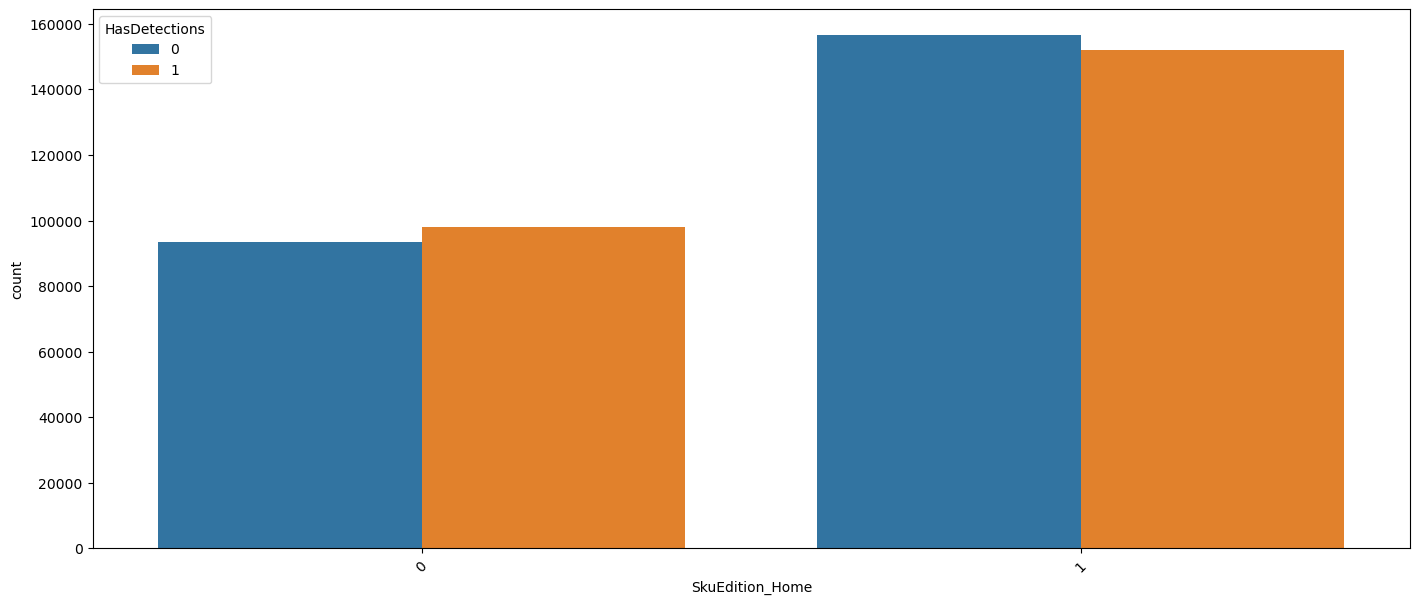

,Num_rows,Total_infections,mode_target,pct_infections
SkuEdition_Home,,,,
0,191433,97946,1,0.511646
1,308567,152007,0,0.492622


In [84]:
cat_analysis_cl(df, 'SkuEdition_Home', TARGET)


#### IsProtected

In [85]:
#df['imput_0__IsProtected'].value_counts()

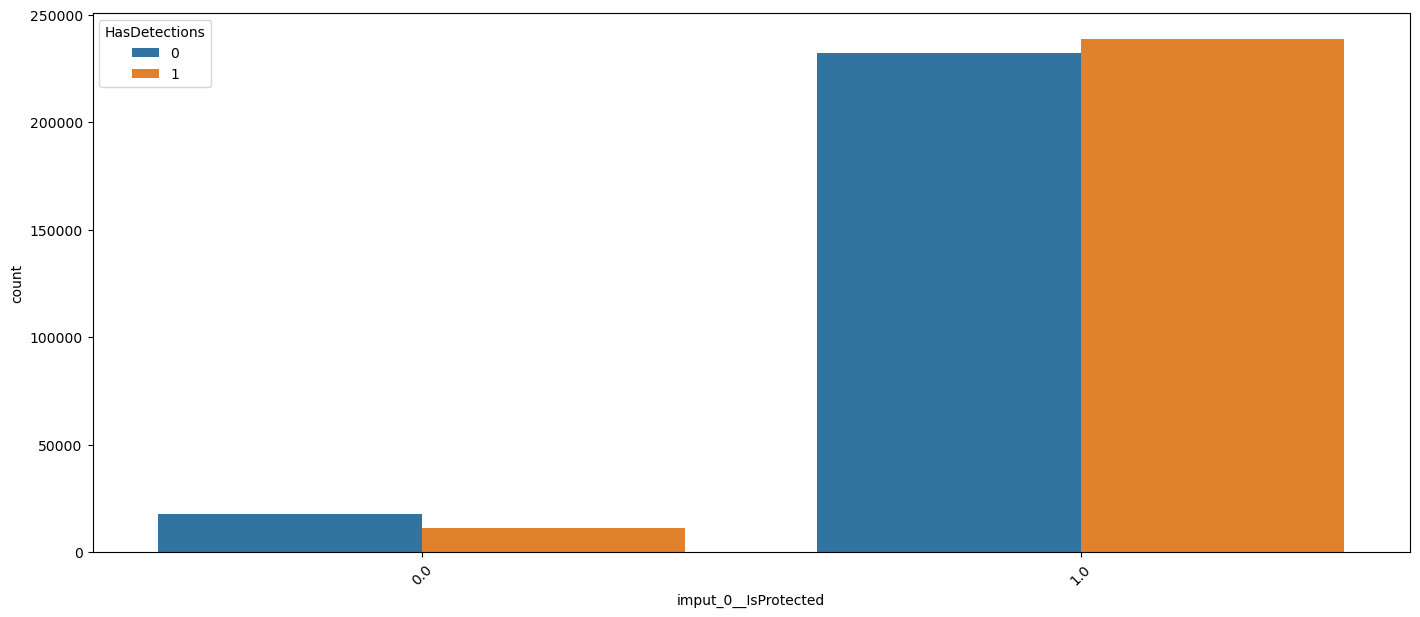

,Num_rows,Total_infections,mode_target,pct_infections
imput_0__IsProtected,,,,
0.0,28927,11076,0,0.382895
1.0,471073,238877,1,0.507091


In [86]:
cat_analysis_cl(df, 'imput_0__IsProtected', TARGET)

#### SMode

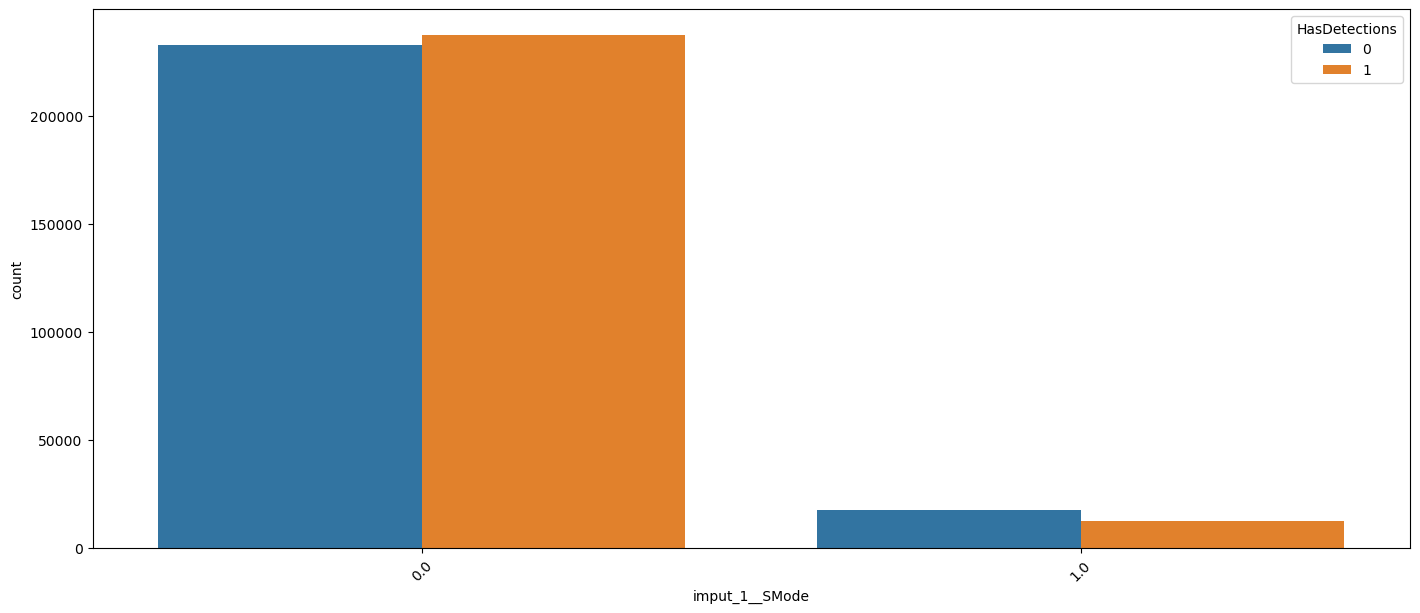

,Num_rows,Total_infections,mode_target,pct_infections
imput_1__SMode,,,,
0.0,469946,237451,1,0.505273
1.0,30054,12502,0,0.415985


In [87]:
cat_analysis_cl(df, 'imput_1__SMode', TARGET)

#### IeVeridentifier

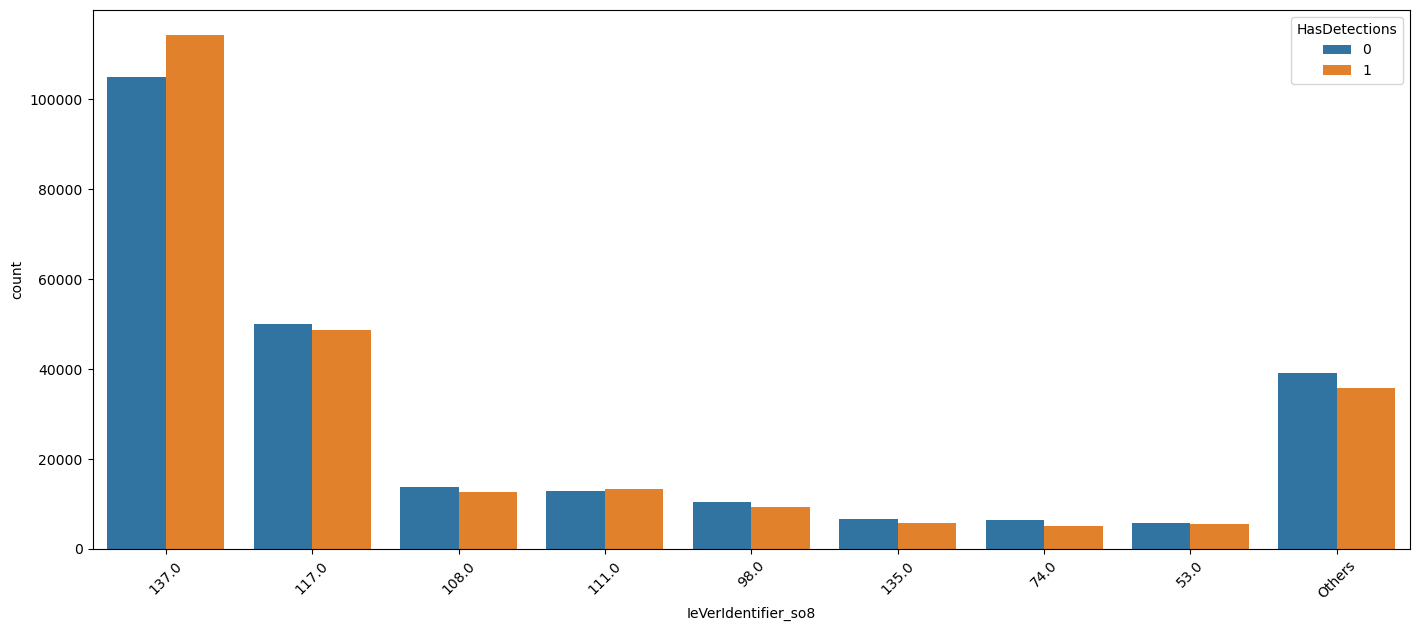

,Num_rows,Total_infections,mode_target,pct_infections
IeVerIdentifier_so8,,,,
137.0,219142,114170,1,0.520986
117.0,98667,48613,0,0.492698
108.0,26353,12540,0,0.475847
111.0,26143,13211,1,0.505336
98.0,19731,9323,0,0.472505
135.0,12314,5780,0,0.469384
74.0,11395,5065,0,0.444493
53.0,11352,5503,0,0.484760
Others,74903,35748,0,0.477257


In [88]:
cat_analysis_cl(df, 'IeVerIdentifier_so8', TARGET)


In [89]:
trans_ordinal.append('IeVerIdentifier_so8')

#### SmartScreen

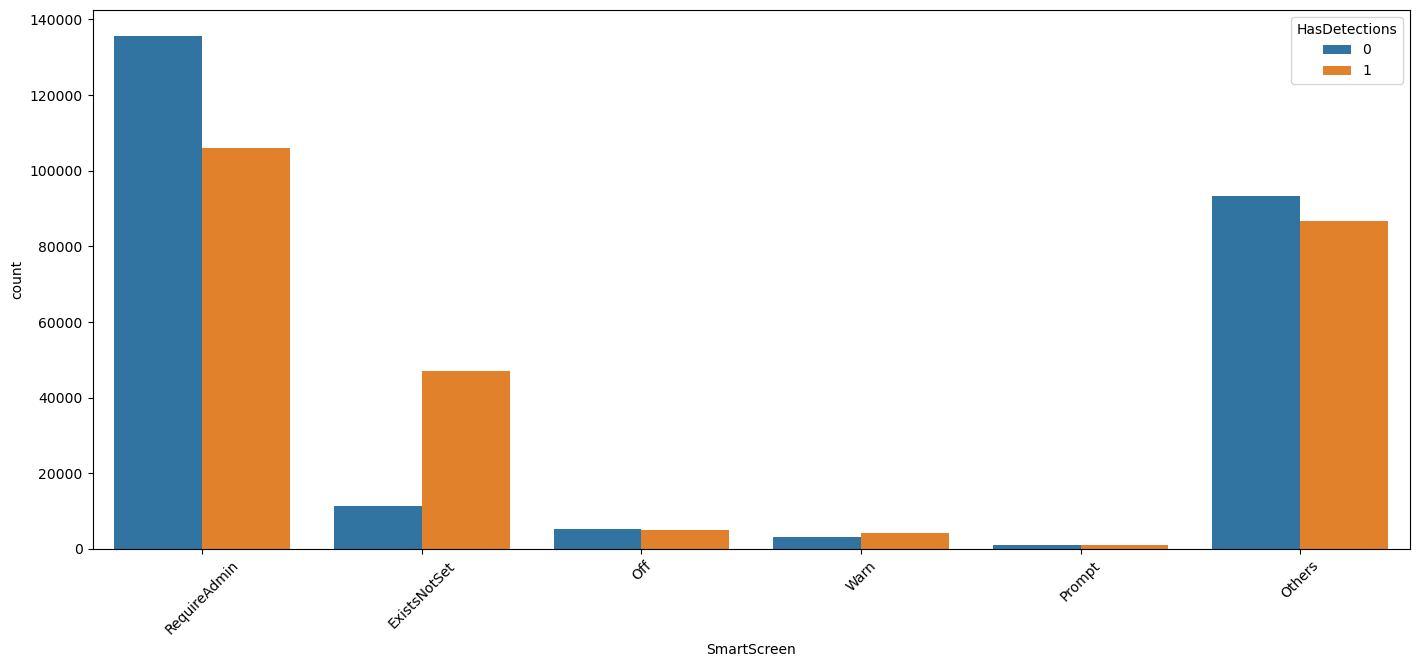

,Num_rows,Total_infections,mode_target,pct_infections
SmartScreen,,,,
RequireAdmin,241594,105890,0,0.438297
ExistsNotSet,58497,47115,1,0.805426
Off,10388,5055,0,0.486619
Warn,7530,4306,1,0.571846
Prompt,1950,928,0,0.475897
Others,180041,86659,0,0.481329


In [90]:
cat_analysis_cl(df, 'SmartScreen', TARGET)

In [91]:
trans_frecuency.append('SmartScreen')

#### Firewall

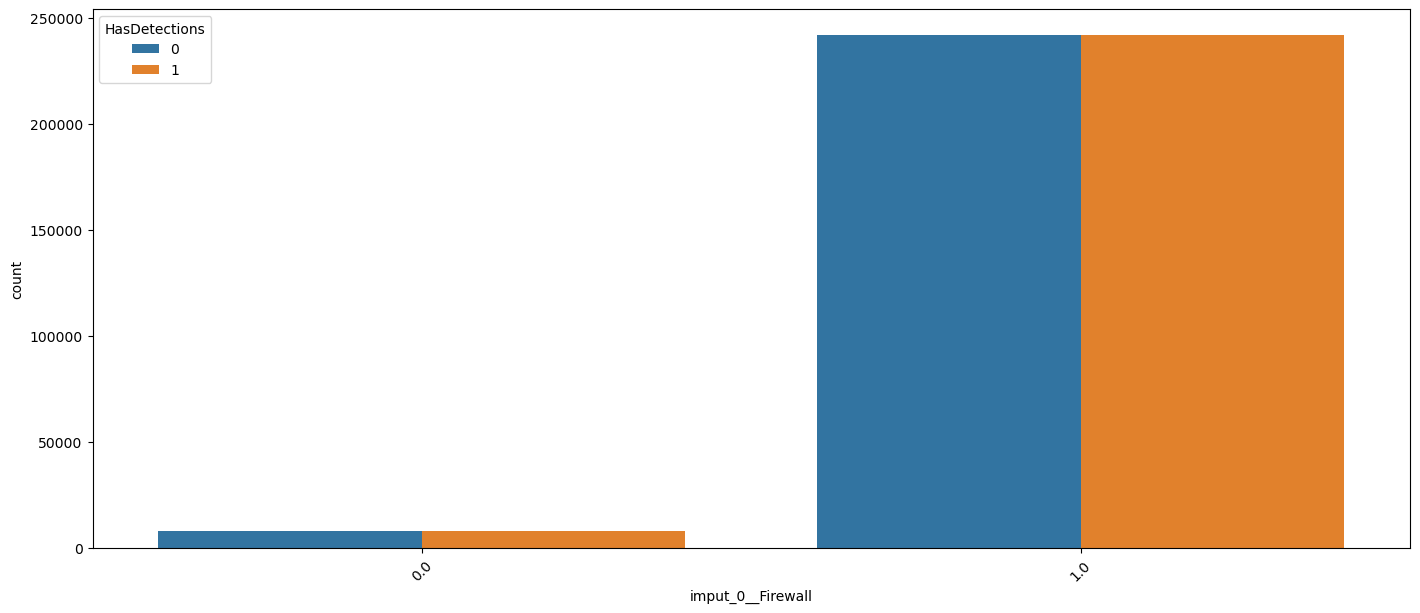

,Num_rows,Total_infections,mode_target,pct_infections
imput_0__Firewall,,,,
0.0,15929,7847,0,0.492624
1.0,484071,242106,1,0.500146


In [92]:
cat_analysis_cl(df, 'imput_0__Firewall', TARGET)

#### Census_MDC2FormFactor

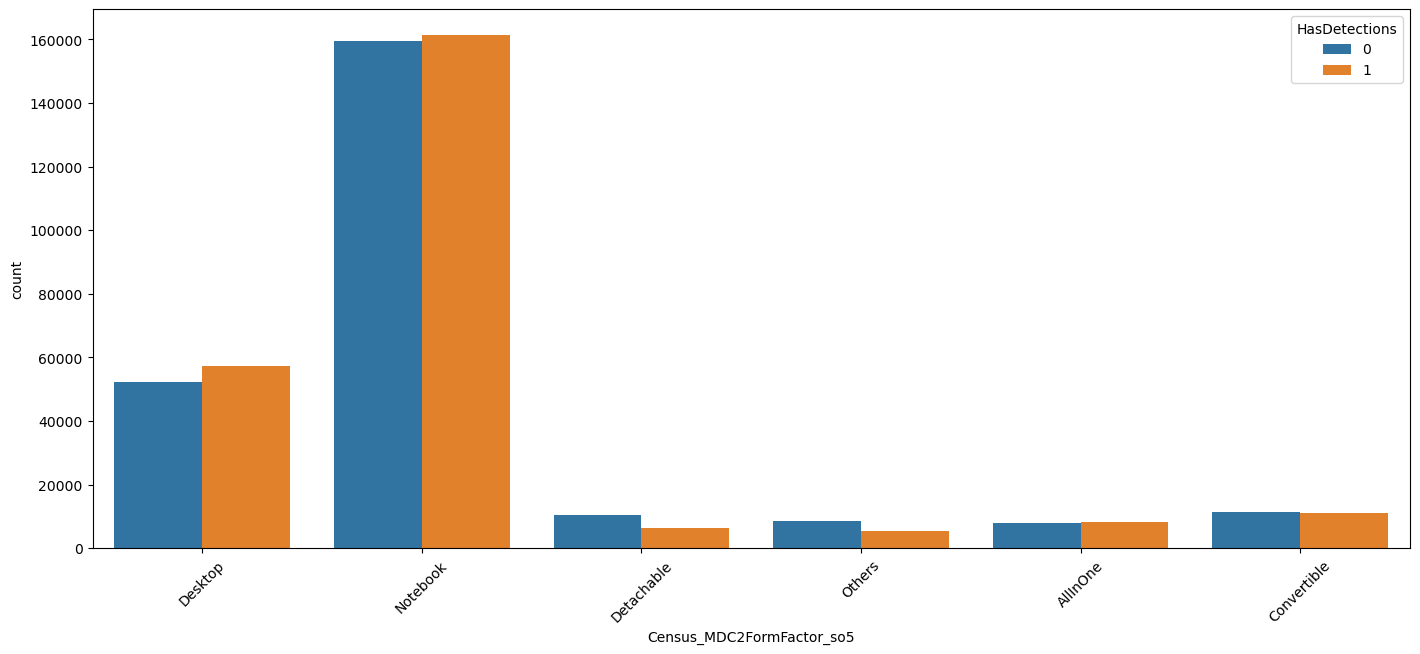

,Num_rows,Total_infections,mode_target,pct_infections
Census_MDC2FormFactor_so5,,,,
AllInOne,16372,8384,1,0.512094
Convertible,22369,11025,0,0.492870
Desktop,109527,57306,1,0.523213
Detachable,16802,6351,0,0.377991
Notebook,320948,161411,1,0.502919
Others,13982,5476,0,0.391646


In [93]:
df['Census_MDC2FormFactor_so5'] = setOthers(df, 'Census_MDC2FormFactor', 5).astype('str')
old_cols_drop.append('Census_MDC2FormFactor')
cat_analysis_cl(df, 'Census_MDC2FormFactor_so5', TARGET)

In [94]:
trans_frecuency.append('Census_MDC2FormFactor_so5')

#### Census_OEMNameIdentifier

In [95]:
df['Census_OEMNameIdentifier_so30'] = setOthers(df, 'imput_xtr__Census_OEMNameIdentifier', 30).astype('str')
old_cols_drop.append('imput_xtr__Census_OEMNameIdentifier')

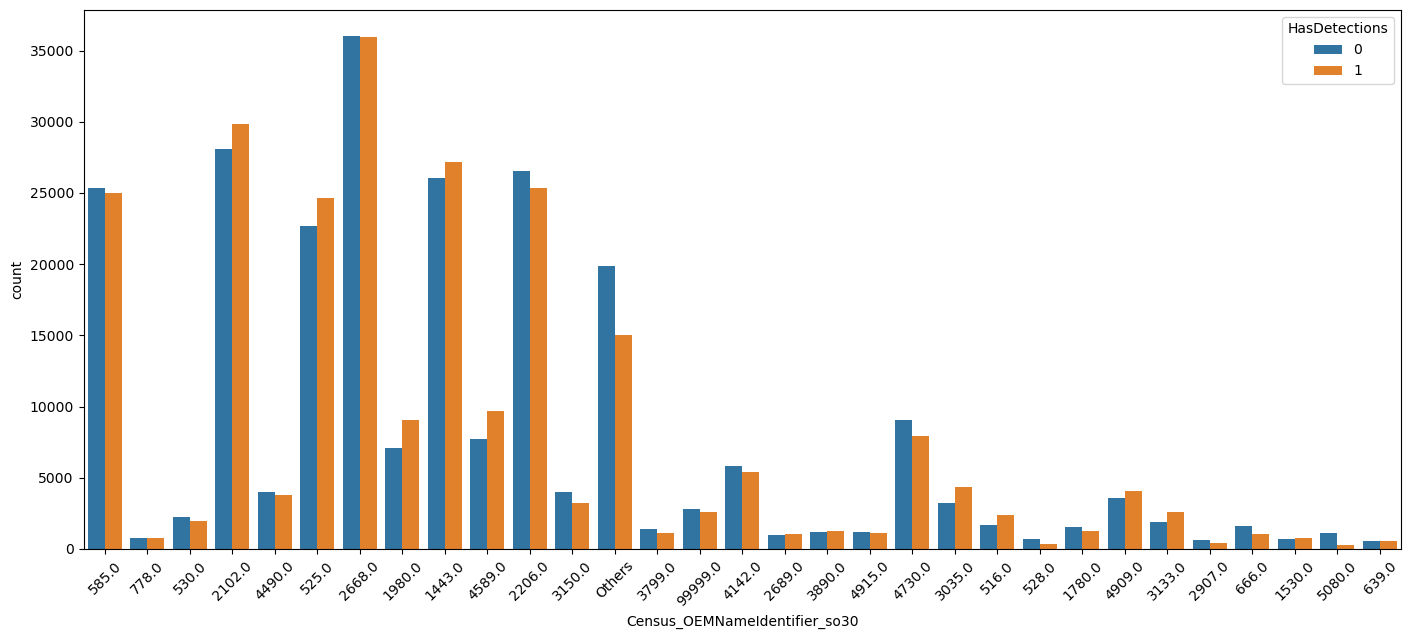

,Num_rows,Total_infections,mode_target,pct_infections
Census_OEMNameIdentifier_so30,,,,
1443.0,53210,27159,1,0.510412
1530.0,1487,759,1,0.510424
1780.0,2779,1226,0,0.441166
1980.0,16157,9066,1,0.561119
2102.0,57924,29863,1,0.515555
2206.0,51888,25328,0,0.488128
2668.0,72011,35964,0,0.499424
2689.0,1973,1018,1,0.515966
2907.0,1031,437,0,0.423860


In [96]:
cat_analysis_cl(df, 'Census_OEMNameIdentifier_so30', TARGET)

In [97]:
trans_ordinal.append('Census_OEMNameIdentifier_so30')

#### Census_ProcessorCoreCount

In [98]:
df['Census_ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].astype('str')

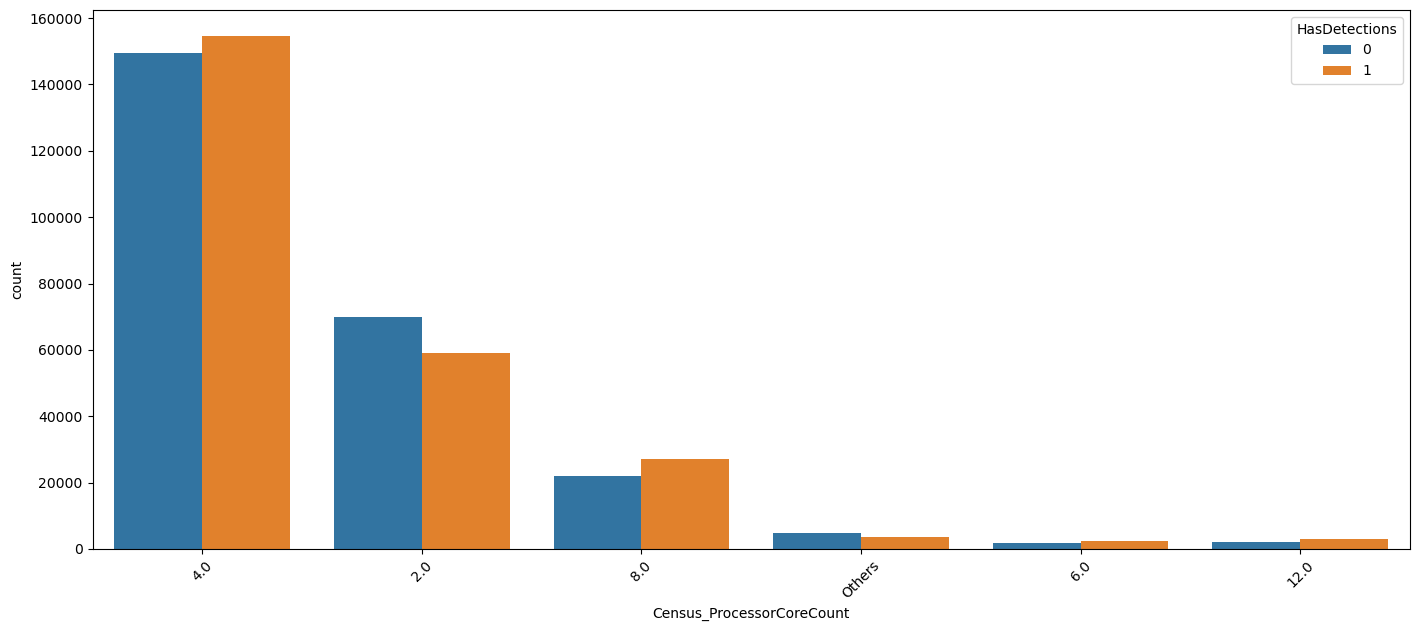

,Num_rows,Total_infections,mode_target,pct_infections
Census_ProcessorCoreCount,,,,
12.0,5184,3011,1,0.580826
2.0,129178,59122,0,0.457679
4.0,304102,154734,1,0.508823
6.0,4023,2290,1,0.569227
8.0,48995,27121,1,0.553546
Others,8518,3675,0,0.431439


In [99]:
cat_analysis_cl(df, 'Census_ProcessorCoreCount', TARGET)

In [100]:
trans_ordinal.append('Census_ProcessorCoreCount')

#### Census_ProcessorManufacturerIdentifier

In [101]:
df['imput_1__Census_ProcessorManufacturerIdentifier'] = df['imput_1__Census_ProcessorManufacturerIdentifier'].astype('str')
convert_cat_bool(df, 'imput_1__Census_ProcessorManufacturerIdentifier', '5.0')

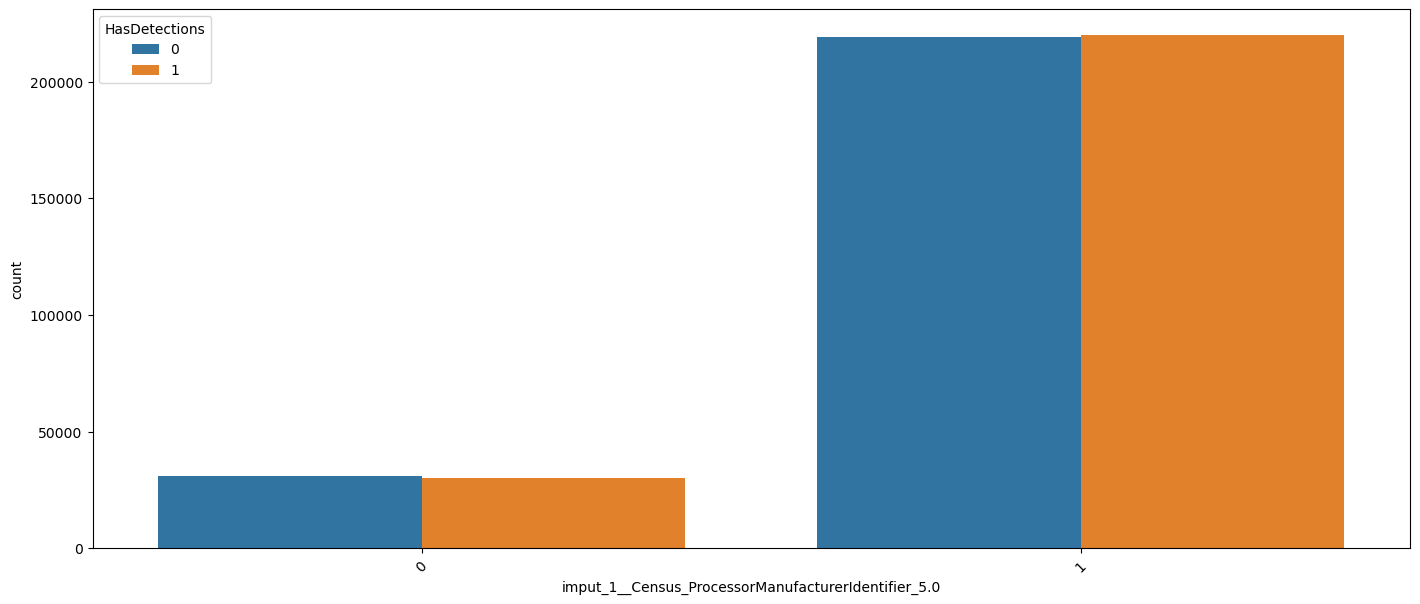

,Num_rows,Total_infections,mode_target,pct_infections
imput_1__Census_ProcessorManufacturerIdentifier_5.0,,,,
0,60972,30005,0,0.492111
1,439028,219948,1,0.500989


In [102]:
cat_analysis_cl(df, 'imput_1__Census_ProcessorManufacturerIdentifier_5.0', TARGET)

#### Census_PrimaryDiskTypeName

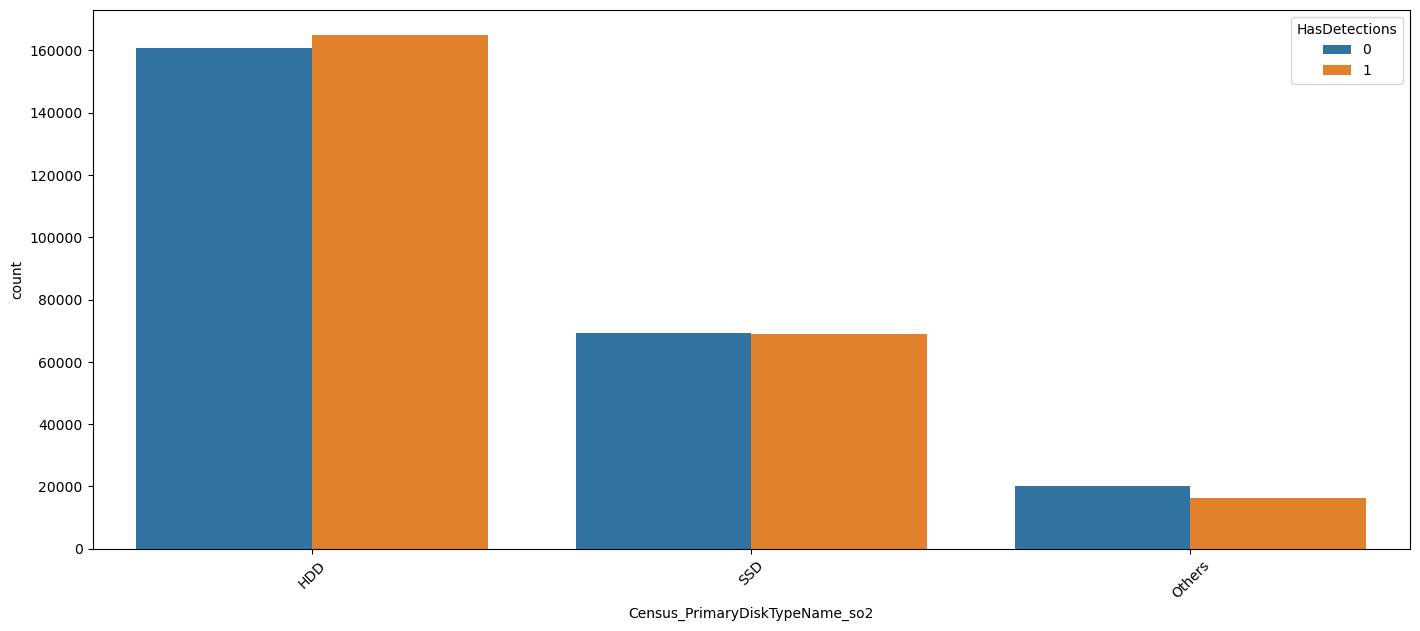

,Num_rows,Total_infections,mode_target,pct_infections
Census_PrimaryDiskTypeName_so2,,,,
HDD,325429,164762,1,0.506292
SSD,138155,68821,0,0.498143
Others,36416,16370,0,0.449528


In [103]:
cat_analysis_cl(df, 'Census_PrimaryDiskTypeName_so2', TARGET)

In [104]:
trans_OHE = ['Census_PrimaryDiskTypeName_so2']

#### HasOpticalDiskDrive

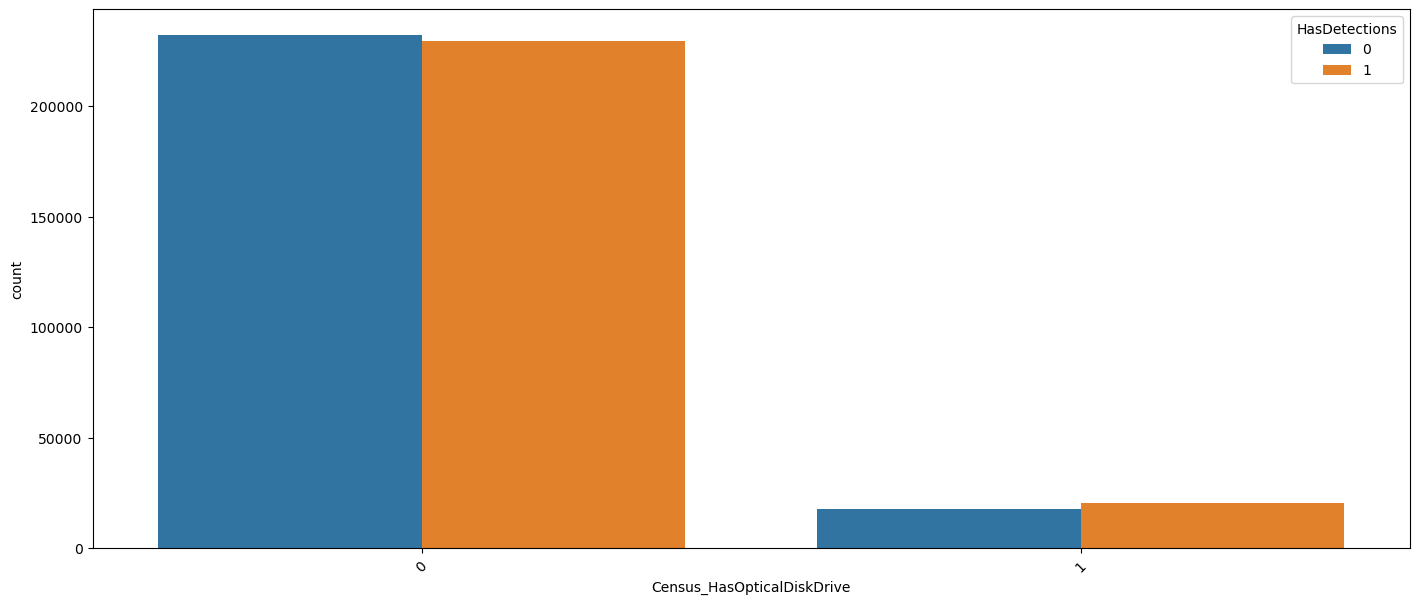

,Num_rows,Total_infections,mode_target,pct_infections
Census_HasOpticalDiskDrive,,,,
0,461483,229360,0,0.497006
1,38517,20593,1,0.534647


In [105]:
cat_analysis_cl(df, 'Census_HasOpticalDiskDrive', TARGET)

#### Census_ChassisTypeName

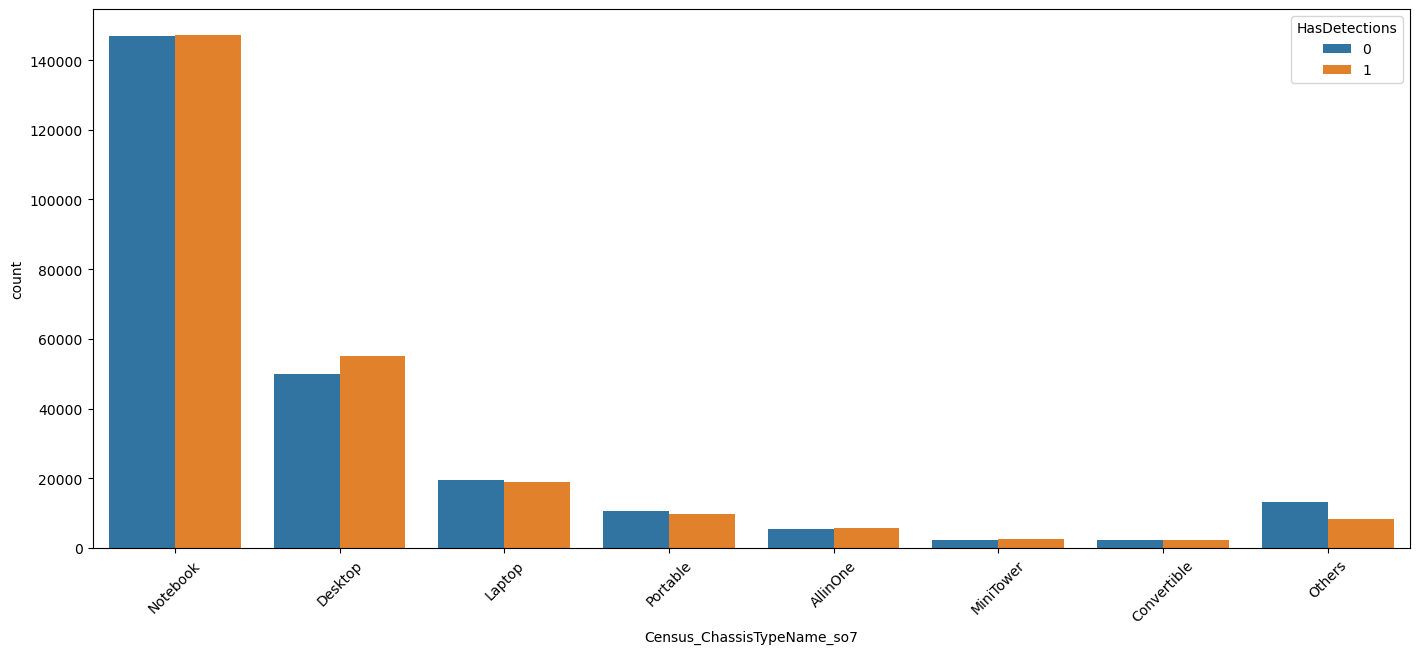

,Num_rows,Total_infections,mode_target,pct_infections
Census_ChassisTypeName_so7,,,,
Notebook,294232,147270,1,0.500523
Desktop,104979,55150,1,0.525343
Laptop,38261,18864,0,0.493035
Portable,20181,9696,0,0.480452
AllinOne,11407,5831,1,0.511177
MiniTower,4849,2597,1,0.535574
Convertible,4685,2252,0,0.480683
Others,21406,8293,0,0.387415


In [106]:
cat_analysis_cl(df, 'Census_ChassisTypeName_so7', TARGET)

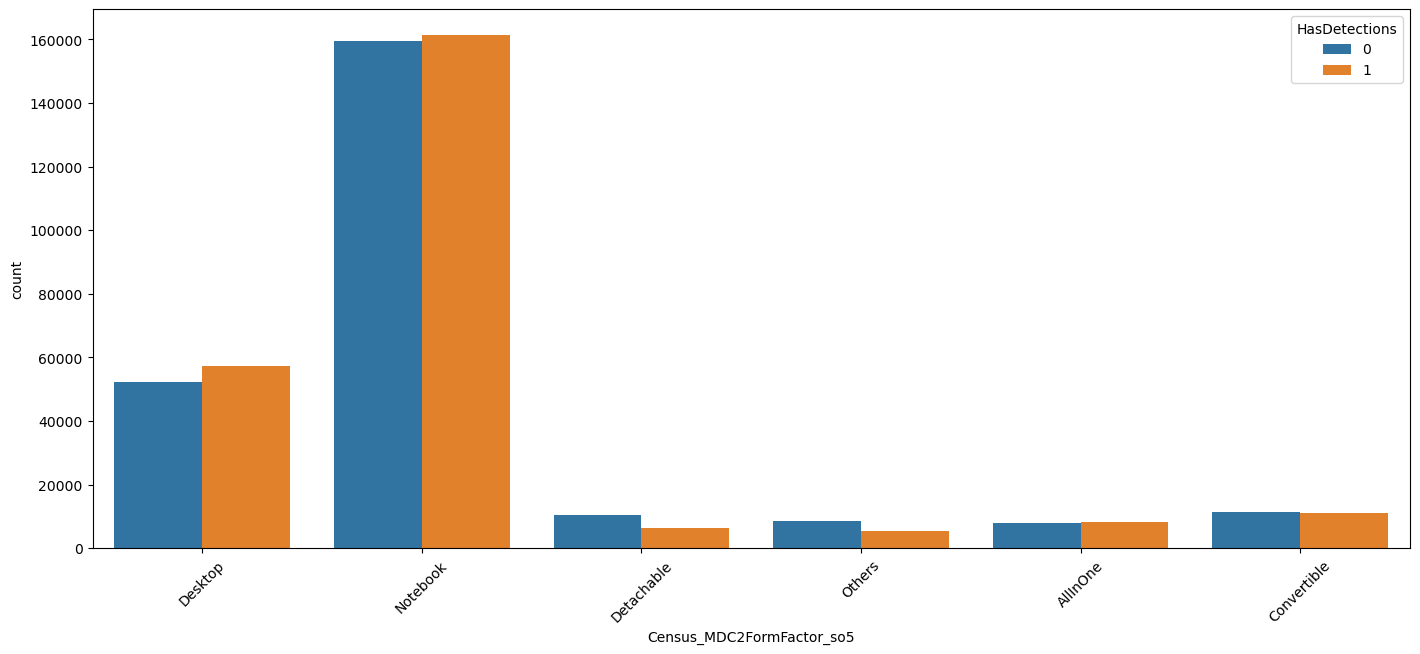

,Num_rows,Total_infections,mode_target,pct_infections
Census_MDC2FormFactor_so5,,,,
AllInOne,16372,8384,1,0.512094
Convertible,22369,11025,0,0.492870
Desktop,109527,57306,1,0.523213
Detachable,16802,6351,0,0.377991
Notebook,320948,161411,1,0.502919
Others,13982,5476,0,0.391646


In [107]:
cat_analysis_cl(df, 'Census_MDC2FormFactor_so5', TARGET)

In [108]:
old_cols_drop.append('Census_ChassisTypeName_so7')

#### Census_PowerPlatformRoleName

In [109]:
#df['Census_PowerPlatformRoleName'].value_counts()

In [110]:
df['Census_PowerPlatformRoleName_so3'] = setOthers(df,'Census_PowerPlatformRoleName', 3)
old_cols_drop.append('Census_PowerPlatformRoleName')

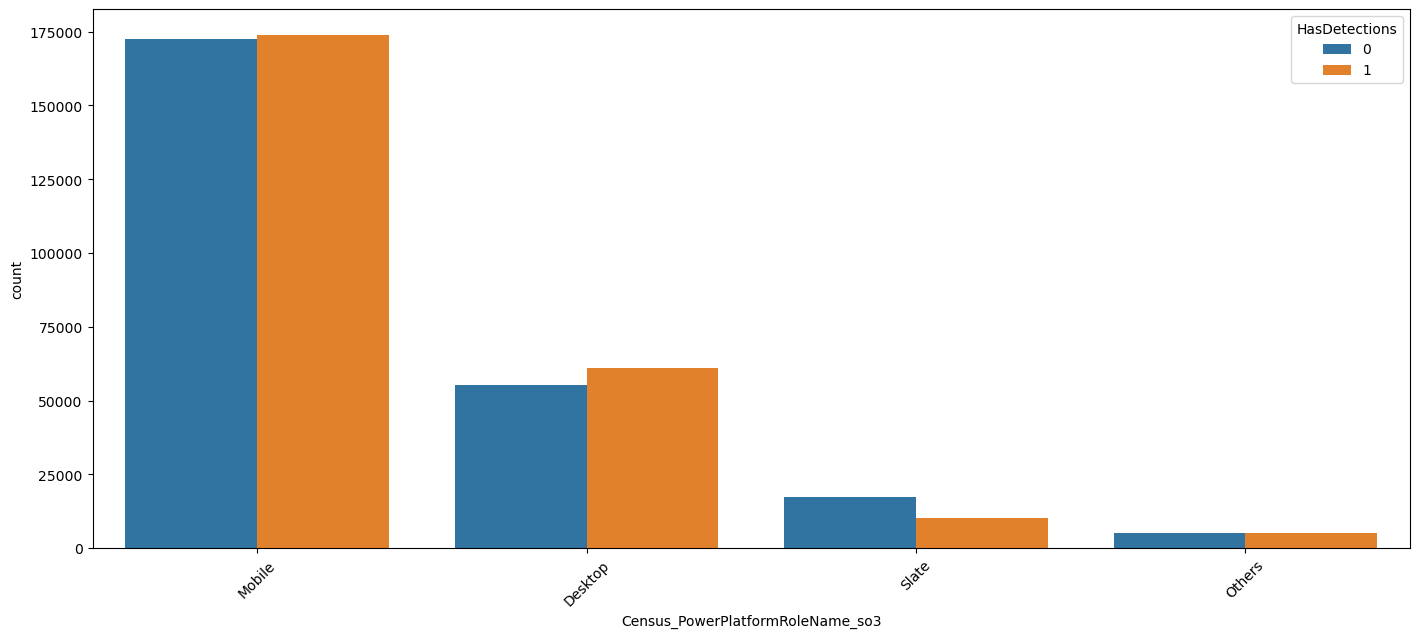

,Num_rows,Total_infections,mode_target,pct_infections
Census_PowerPlatformRoleName_so3,,,,
Mobile,346378,173910,1,0.502082
Desktop,116054,60942,1,0.525118
Slate,27475,10082,0,0.366952
Others,10093,5019,0,0.497275


In [111]:
cat_analysis_cl(df, 'Census_PowerPlatformRoleName_so3', TARGET)

In [112]:
trans_ordinal.append('Census_PowerPlatformRoleName_so3')

#### Census_InternalBatteryType

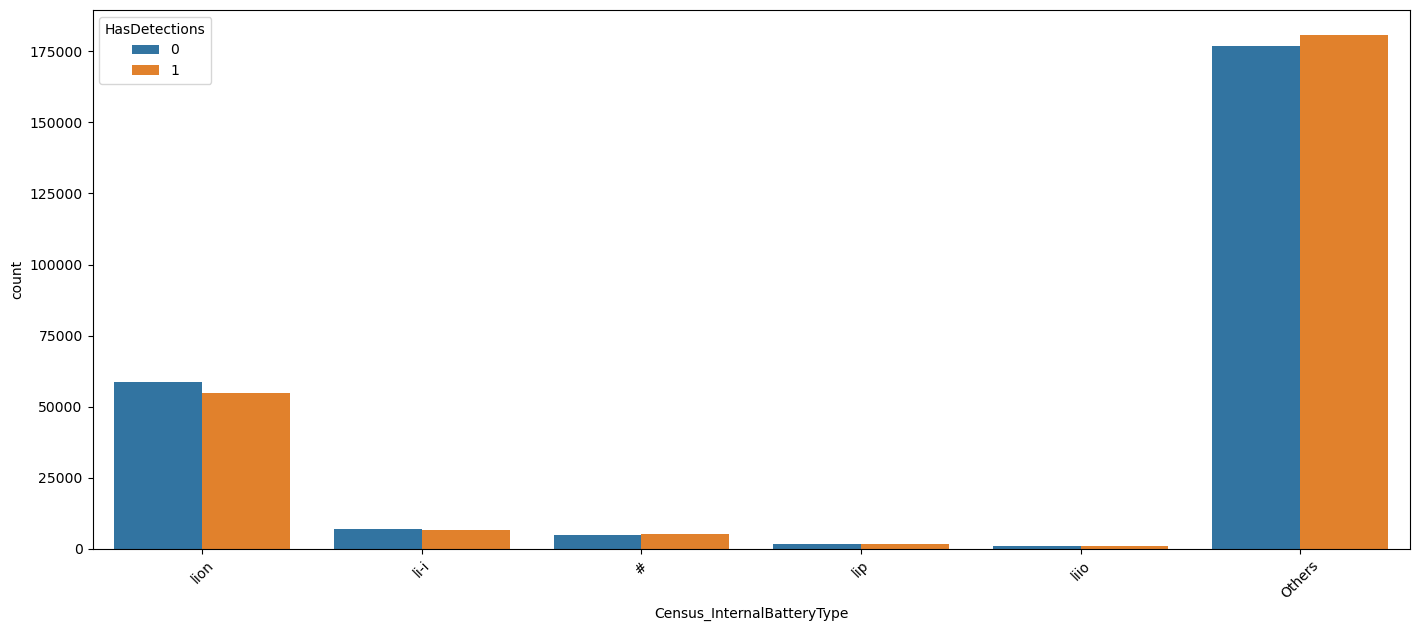

,Num_rows,Total_infections,mode_target,pct_infections
Census_InternalBatteryType,,,,
lion,113500,54715,0,0.482070
li-i,13855,6718,0,0.484879
#,10176,5321,1,0.522897
lip,3326,1791,1,0.538485
liio,1814,830,0,0.457552
Others,357329,180578,1,0.505355


In [113]:
cat_analysis_cl(df, 'Census_InternalBatteryType', TARGET)

In [114]:
old_cols_drop.append('Census_InternalBatteryType')

#### Census_OSVersion

In [115]:
df[['Census_OSVersion', 'Census_OSBuildNumber', 'Census_OSBuildRevision']]

,Census_OSVersion,Census_OSBuildNumber,Census_OSBuildRevision
104241,10.0.17134.165,17134,165
199676,10.0.17134.228,17134,228
140199,10.0.16299.431,16299,431
132814,10.0.17134.285,17134,285
408697,10.0.17134.165,17134,165
...,...,...,...
259178,10.0.17134.228,17134,228
365838,10.0.17134.228,17134,228
131932,10.0.17134.228,17134,228
146867,10.0.17134.228,17134,228


In [116]:
old_cols_drop.append('Census_OSVersion')

#### Census_OSArchitecture

In [117]:
convert_cat_bool(df, 'Census_OSArchitecture', 'amd64')

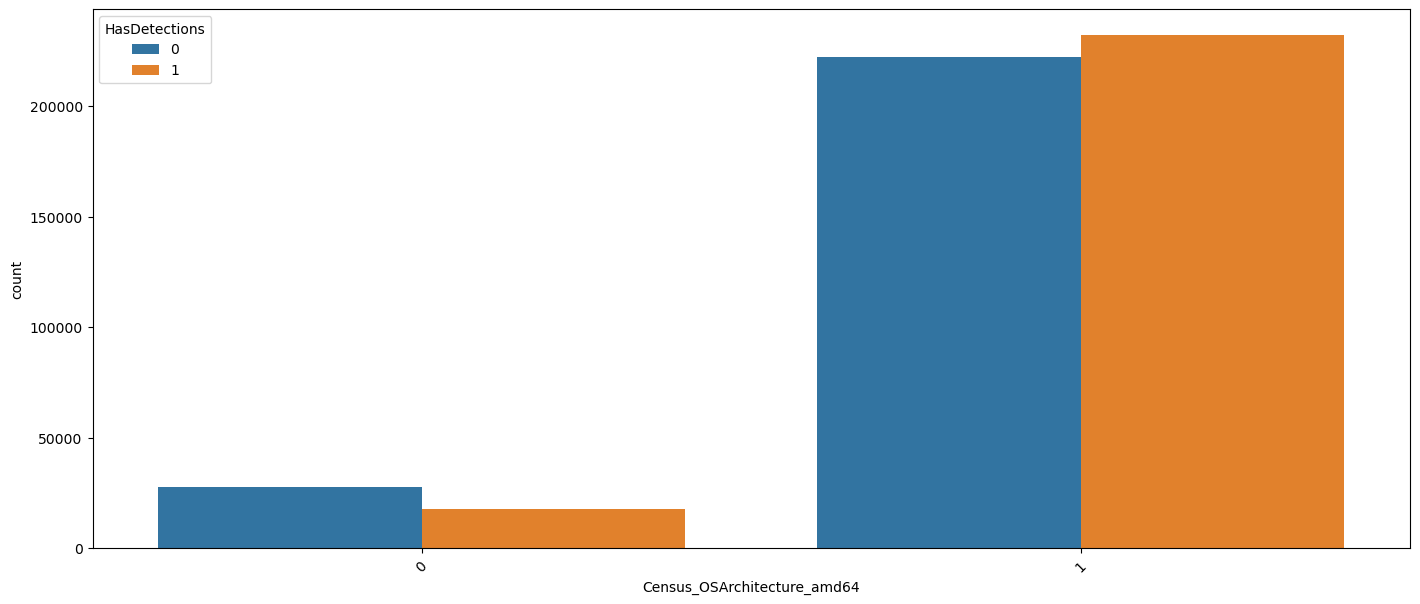

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSArchitecture_amd64,,,,
0,45565,17686,0,0.388149
1,454435,232267,1,0.511112


In [118]:
cat_analysis_cl(df,'Census_OSArchitecture_amd64', TARGET)

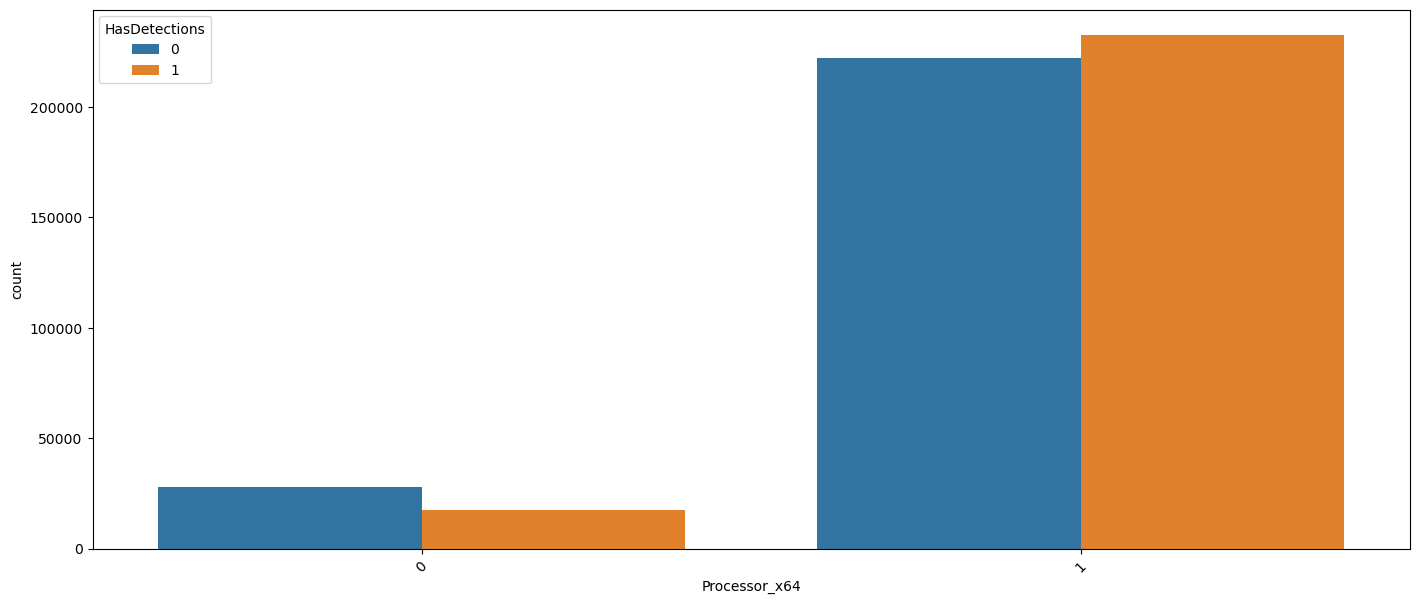

,Num_rows,Total_infections,mode_target,pct_infections
Processor_x64,,,,
0,45577,17632,0,0.386862
1,454423,232321,1,0.511244


In [119]:
cat_analysis_cl(df,'Processor_x64', TARGET)

In [120]:
old_cols_drop.append('Census_OSArchitecture_amd64')

#### Census_OSBranch

In [121]:
#df['Census_OSBranch'].value_counts()

In [122]:
df['Census_OSBranch_so7'] = setOthers(df, 'Census_OSBranch', 7)
old_cols_drop.append('Census_OSBranch')

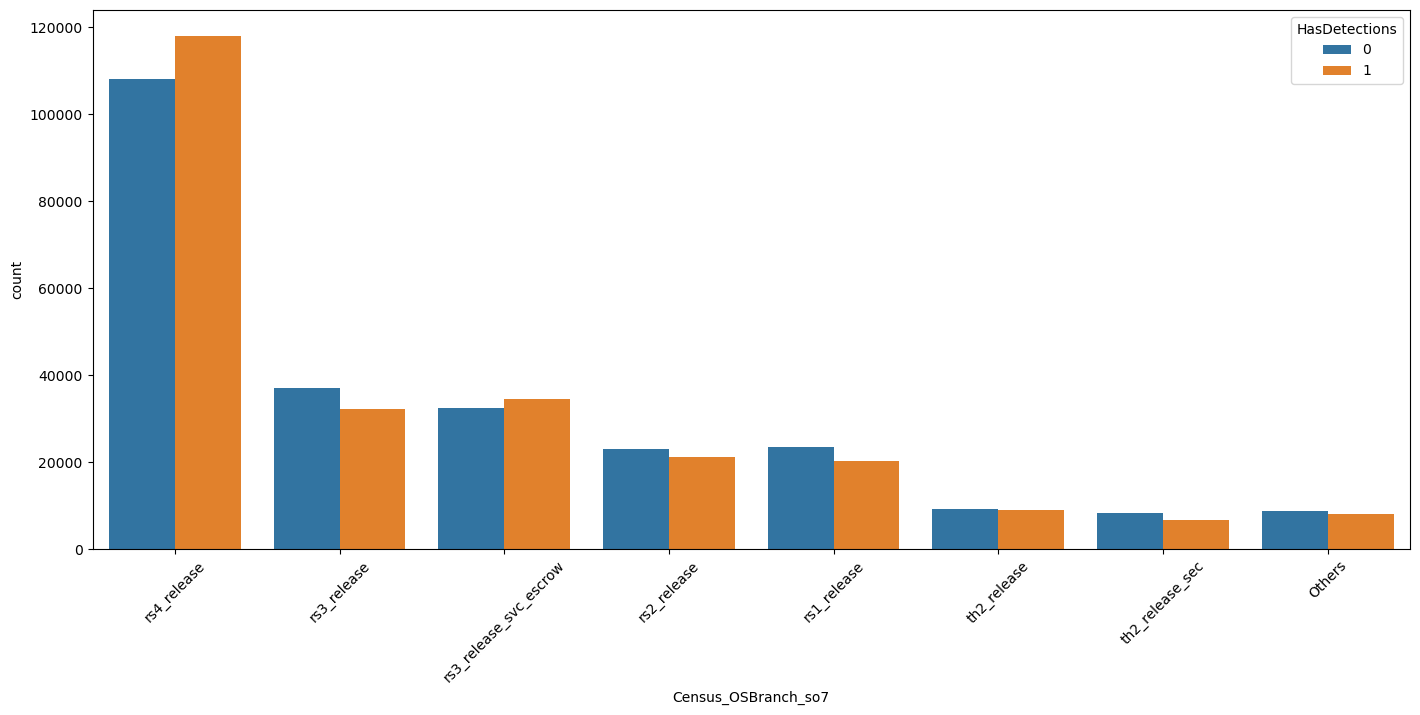

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSBranch_so7,,,,
rs4_release,226001,118008,1,0.522157
rs3_release,69216,32176,0,0.464864
rs3_release_svc_escrow,67027,34572,1,0.515792
rs2_release,44264,21230,0,0.479622
rs1_release,43705,20322,0,0.464981
th2_release,18298,9022,0,0.493059
th2_release_sec,14895,6638,0,0.445653
Others,16594,7985,0,0.481198


In [123]:
cat_analysis_cl(df,'Census_OSBranch_so7', TARGET)

In [124]:
trans_ordinal.append('Census_OSBranch_so7')

#### Census_OSBuildNumber

In [125]:
#df['Census_OSBuildNumber'].value_counts()

In [126]:
df['Census_OSBuildNumber_so3'] = setOthers(df,'Census_OSBuildNumber', 3).astype('str')
old_cols_drop.append('Census_OSBuildNumber')

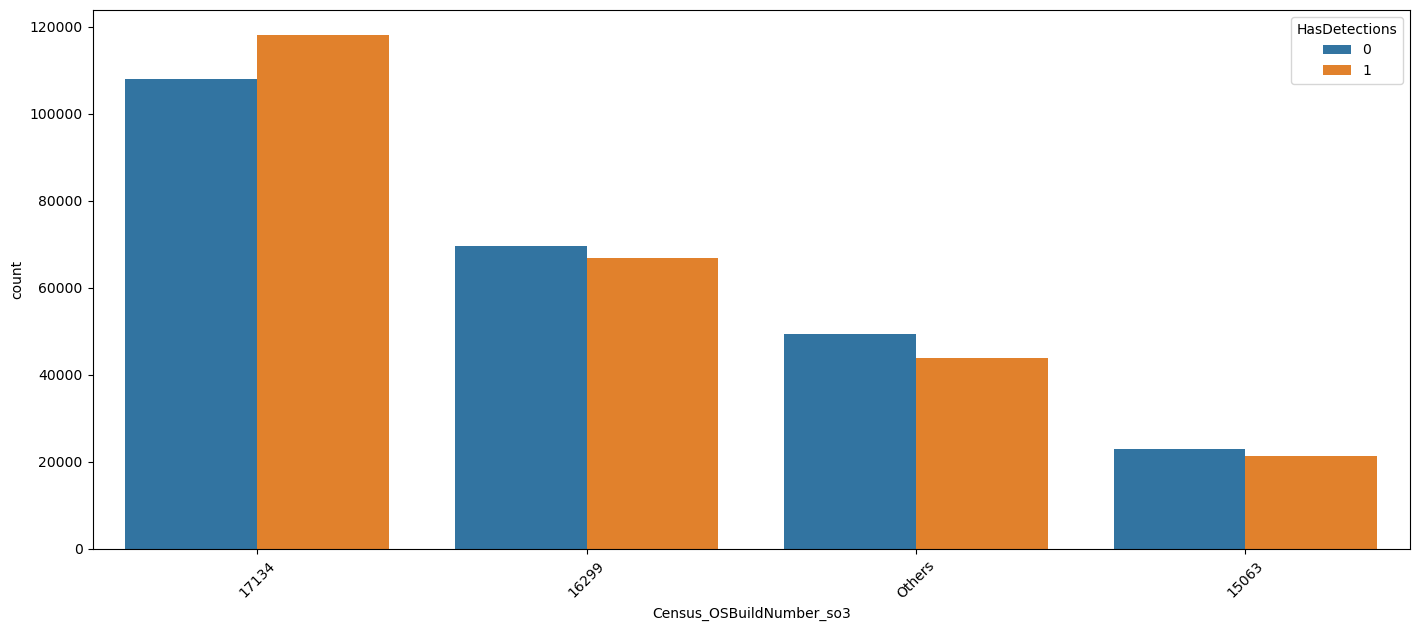

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSBuildNumber_so3,,,,
15063,44262,21229,0,0.479621
16299,136572,66880,0,0.489705
17134,225979,117998,1,0.522164
Others,93187,43846,0,0.470516


In [127]:
cat_analysis_cl(df, 'Census_OSBuildNumber_so3', TARGET)

In [128]:
trans_ordinal.append('Census_OSBuildNumber_so3')

#### Census_OSBuildRevision

In [129]:
#df['Census_OSBuildRevision'].value_counts().sort_index()

In [130]:
df['Census_OSBuildRevision_so35'] = setOthers(df, 'Census_OSBuildRevision', 35).astype('str')
old_cols_drop.append('Census_OSBuildRevision')

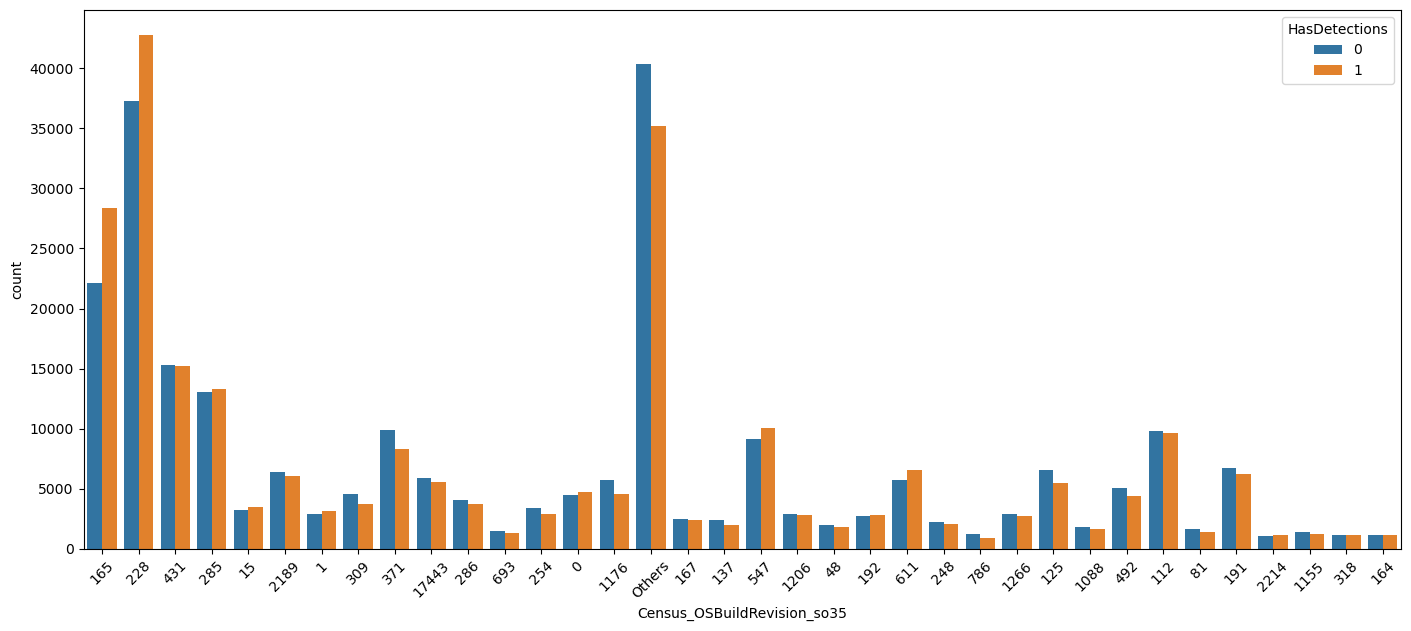

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSBuildRevision_so35,,,,
0,9175,4695,1,0.511717
1,5999,3126,1,0.521087
1088,3535,1681,0,0.475530
112,19503,9662,0,0.495411
1155,2565,1199,0,0.467446
1176,10235,4540,0,0.443576
1206,5700,2809,0,0.492807
125,12038,5516,0,0.458216
1266,5642,2734,0,0.484580


In [131]:
cat_analysis_cl(df, 'Census_OSBuildRevision_so35', TARGET)

In [132]:
trans_ordinal.append('Census_OSBuildRevision_so35')

#### Census_OSEdition

In [133]:
df['Census_OSEdition_so3'] = setOthers(df, 'Census_OSEdition', 3)
old_cols_drop.append('Census_OSEdition')

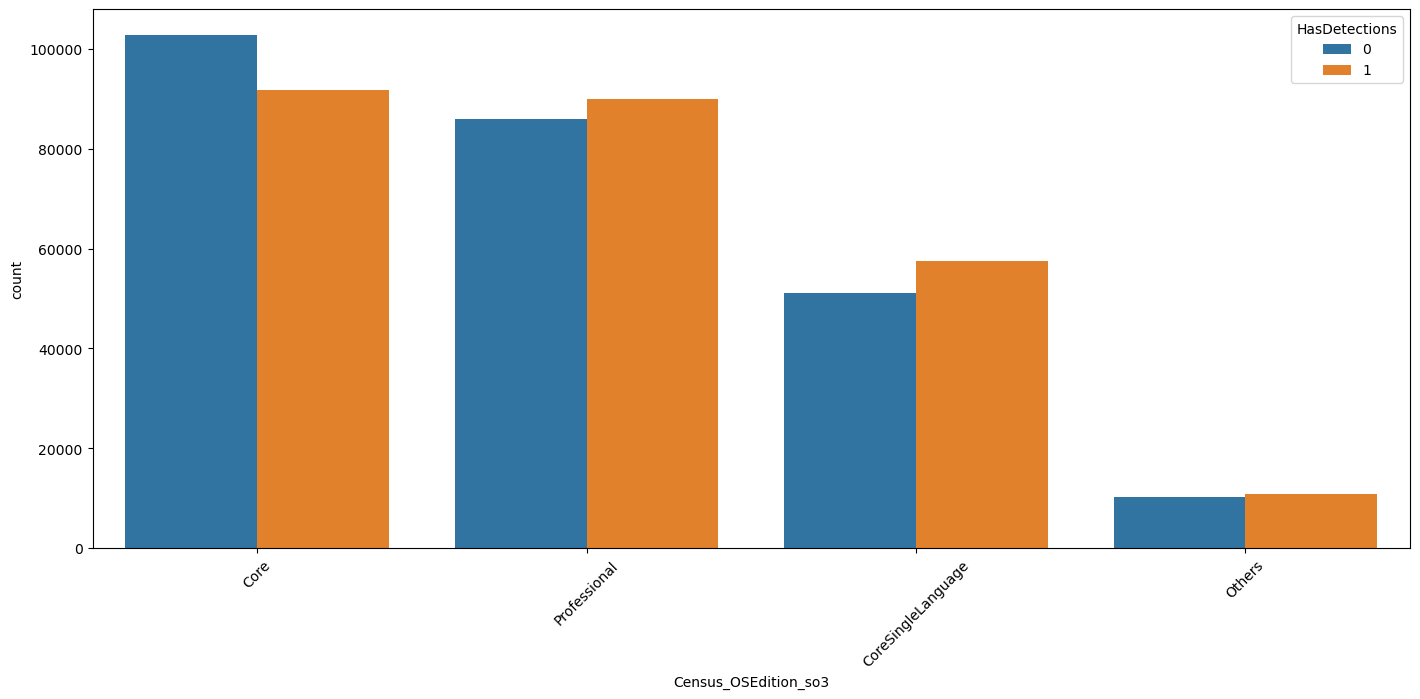

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSEdition_so3,,,,
Core,194469,91666,0,0.471366
Professional,175808,89889,1,0.511291
CoreSingleLanguage,108696,57588,1,0.529808
Others,21027,10810,1,0.514101


In [134]:
cat_analysis_cl(df, 'Census_OSEdition_so3', TARGET)

In [135]:
trans_OHE.append('Census_OSEdition_so3')

#### Census_OSSkuName

In [136]:
#df['Census_OSSkuName'].value_counts()

In [137]:
old_cols_drop.append('Census_OSSkuName')

#### Census_OSInstallTypeName

In [138]:
df['Census_OSInstallTypeName_so5'] = setOthers(df, 'Census_OSInstallTypeName', 5)
old_cols_drop.append('Census_OSInstallTypeName')

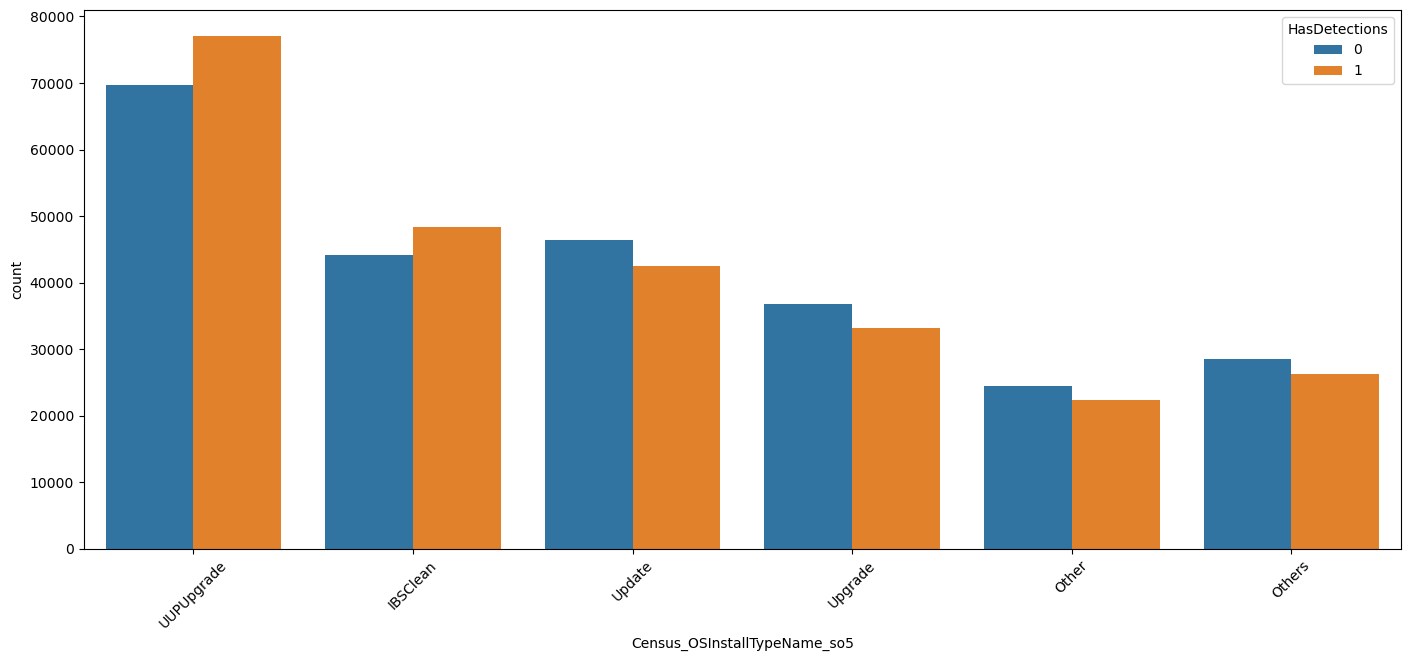

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSInstallTypeName_so5,,,,
UUPUpgrade,146780,77129,1,0.525473
IBSClean,92403,48304,1,0.522754
Update,88892,42499,0,0.478097
Upgrade,70013,33254,0,0.474969
Other,46960,22409,0,0.477193
Others,54952,26358,0,0.479655


In [139]:
cat_analysis_cl(df, 'Census_OSInstallTypeName_so5', TARGET)

In [140]:
df['Census_OSInstallTypeName_so5'] = df['Census_OSInstallTypeName_so5'].replace({'Other' : 'Others'})

In [141]:
trans_OHE.append('Census_OSInstallTypeName_so5')

#### Census_OSInstallLanguageIdentifier

In [142]:
#df['imput_1__Census_OSInstallLanguageIdentifier'].value_counts().head(39)

In [143]:
df['Census_OSInstallLanguageIdentifier_so15'] = setOthers(df, 'imput_1__Census_OSInstallLanguageIdentifier', 15)
old_cols_drop.append('imput_1__Census_OSInstallLanguageIdentifier')

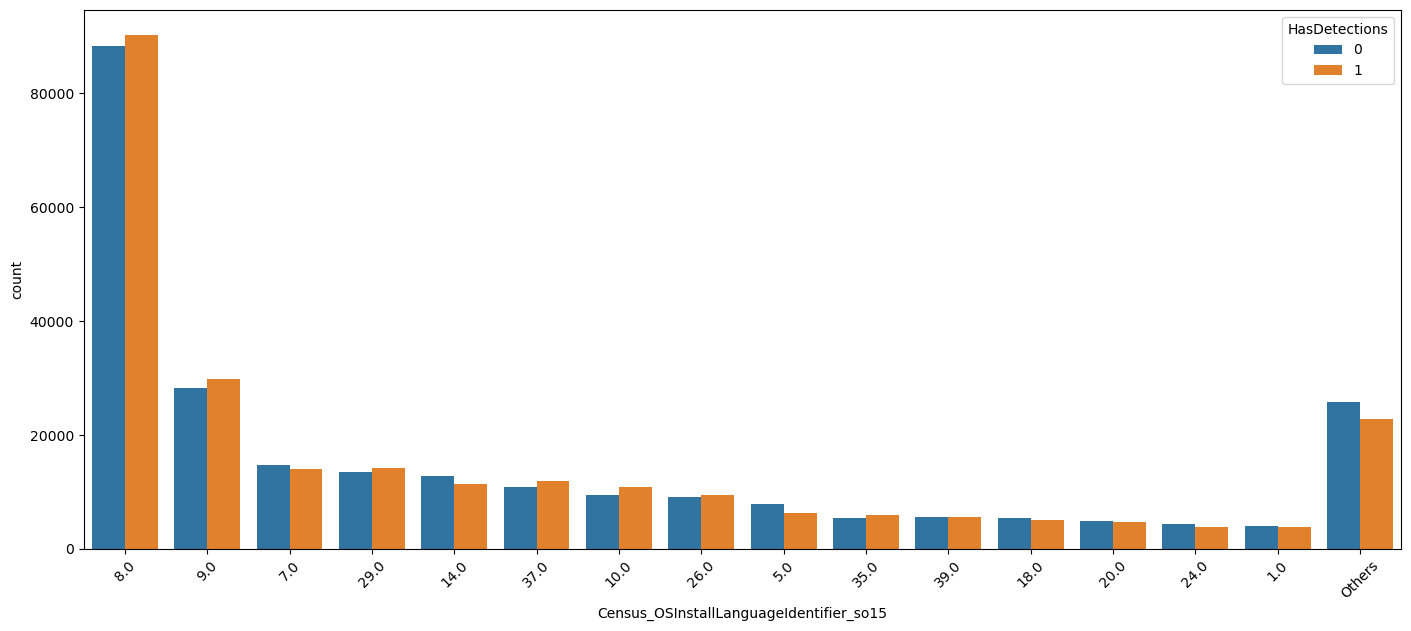

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSInstallLanguageIdentifier_so15,,,,
8.0,178405,90135,1,0.505227
9.0,58013,29788,1,0.513471
7.0,28766,14097,0,0.490058
29.0,27669,14142,1,0.511114
14.0,24191,11379,0,0.470382
37.0,22635,11842,1,0.523172
10.0,20268,10888,1,0.537201
26.0,18520,9470,1,0.511339
5.0,14085,6289,0,0.446503


In [144]:
cat_analysis_cl(df, 'Census_OSInstallLanguageIdentifier_so15', TARGET)

In [145]:
df['Census_OSInstallLanguageIdentifier_so15'] = df['Census_OSInstallLanguageIdentifier_so15'].astype('str')

In [146]:
trans_ordinal.append('Census_OSInstallLanguageIdentifier_so15')

#### Census_OSUILocaleIdentifier

In [147]:
df['Census_OSUILocaleIdentifier_so25'] = setOthers(df, 'Census_OSUILocaleIdentifier', 25).astype('str')
old_cols_drop.append('Census_OSUILocaleIdentifier')

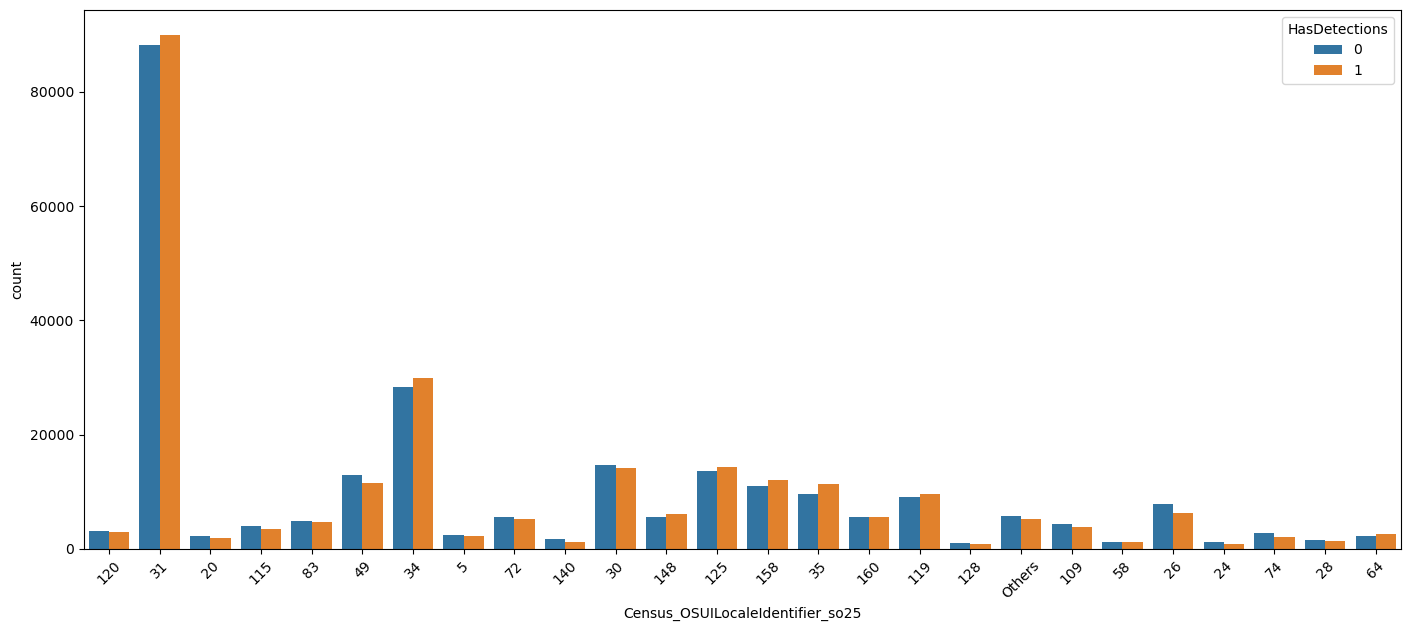

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSUILocaleIdentifier_so25,,,,
109,8143,3848,0,0.472553
115,7496,3544,0,0.472785
119,18696,9556,1,0.511125
120,5993,2961,0,0.494076
125,28001,14334,1,0.511910
128,1808,788,0,0.435841
140,2815,1149,0,0.408171
148,11617,6060,1,0.521649
158,22930,12002,1,0.523419


In [148]:
cat_analysis_cl(df, 'Census_OSUILocaleIdentifier_so25', TARGET)

In [149]:
trans_ordinal.append('Census_OSUILocaleIdentifier_so25')

#### Census_OSWUAutoUpdateOptionsName

In [150]:
df['Census_OSWUAutoUpdateOptionsName_so3'] =  setOthers(df, 'Census_OSWUAutoUpdateOptionsName', 3)
old_cols_drop.append('Census_OSWUAutoUpdateOptionsName')

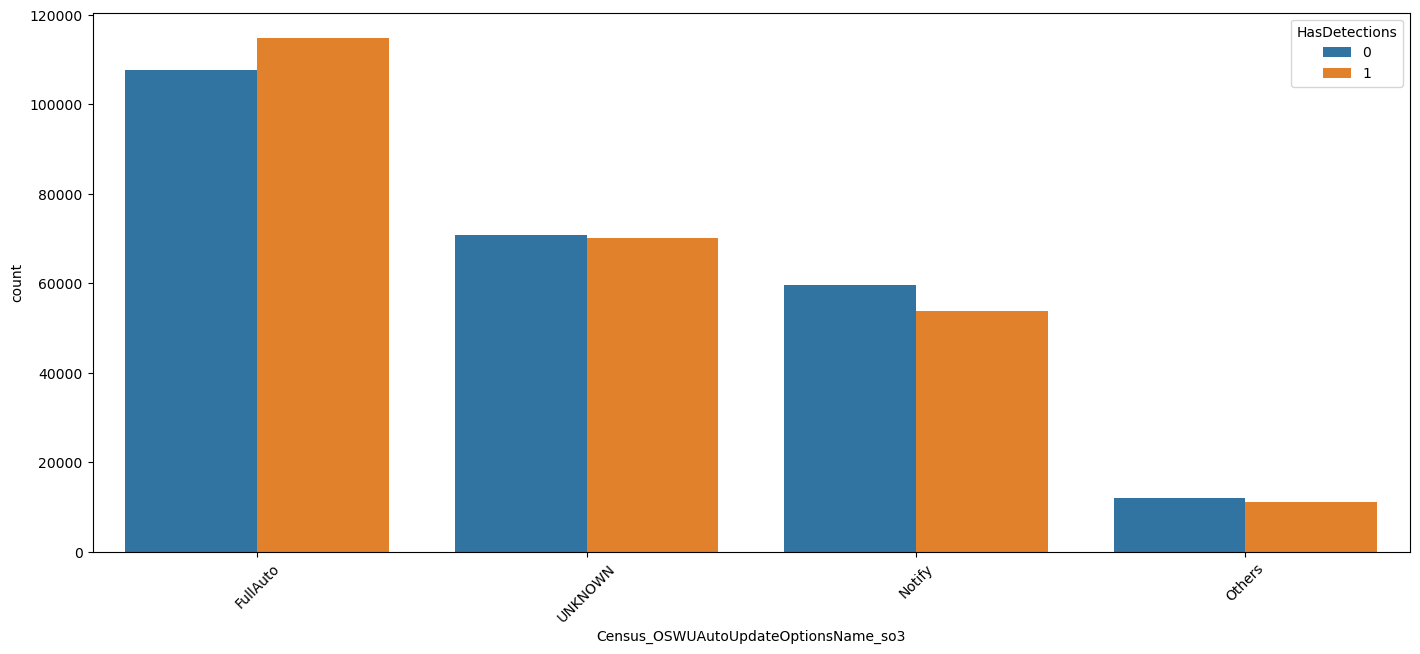

,Num_rows,Total_infections,mode_target,pct_infections
Census_OSWUAutoUpdateOptionsName_so3,,,,
FullAuto,222482,114807,1,0.516028
UNKNOWN,140961,70190,0,0.497939
Notify,113507,53867,0,0.474570
Others,23050,11089,0,0.481085


In [151]:
cat_analysis_cl(df, 'Census_OSWUAutoUpdateOptionsName_so3', TARGET)

In [152]:
trans_OHE.append('Census_OSWUAutoUpdateOptionsName_so3')

#### Census_GenuineStateName

In [153]:
#df['Census_GenuineStateName'].value_counts()

In [154]:
convert_cat_bool(df, 'Census_GenuineStateName', 'IS_GENUINE')

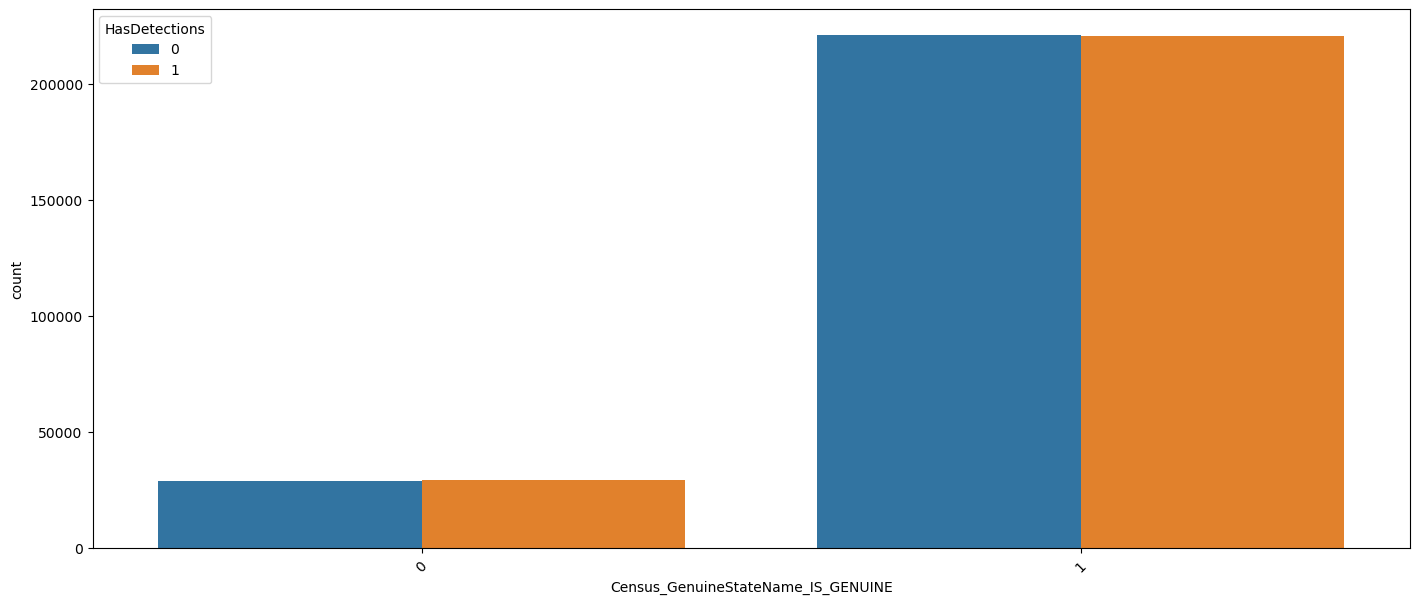

,Num_rows,Total_infections,mode_target,pct_infections
Census_GenuineStateName_IS_GENUINE,,,,
0,58598,29476,1,0.503021
1,441402,220477,0,0.499493


In [155]:
cat_analysis_cl(df, 'Census_GenuineStateName_IS_GENUINE', TARGET)

In [156]:
old_cols_drop.append('Census_GenuineStateName_IS_GENUINE')

#### Census_ActivationChannel

In [157]:
df['Census_ActivationChannel_so2'] = setOthers(df, 'Census_ActivationChannel', 2)
old_cols_drop.append('Census_ActivationChannel')

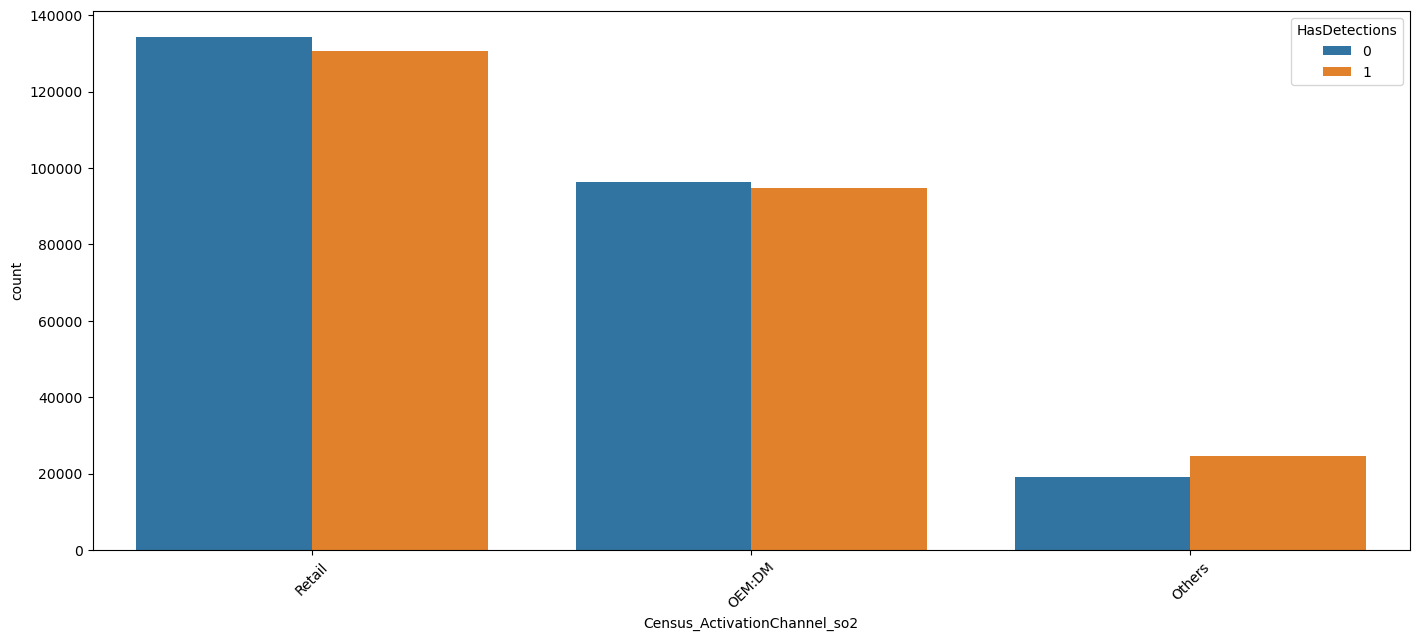

,Num_rows,Total_infections,mode_target,pct_infections
Census_ActivationChannel_so2,,,,
Retail,264932,130532,0,0.492700
OEM:DM,191350,94880,0,0.495845
Others,43718,24541,1,0.561348


In [158]:
cat_analysis_cl(df, 'Census_ActivationChannel_so2', TARGET)

In [159]:
trans_OHE.append('Census_ActivationChannel_so2')

#### Census_FlightRing

In [160]:
convert_cat_bool(df, 'Census_FlightRing', 'Retail')

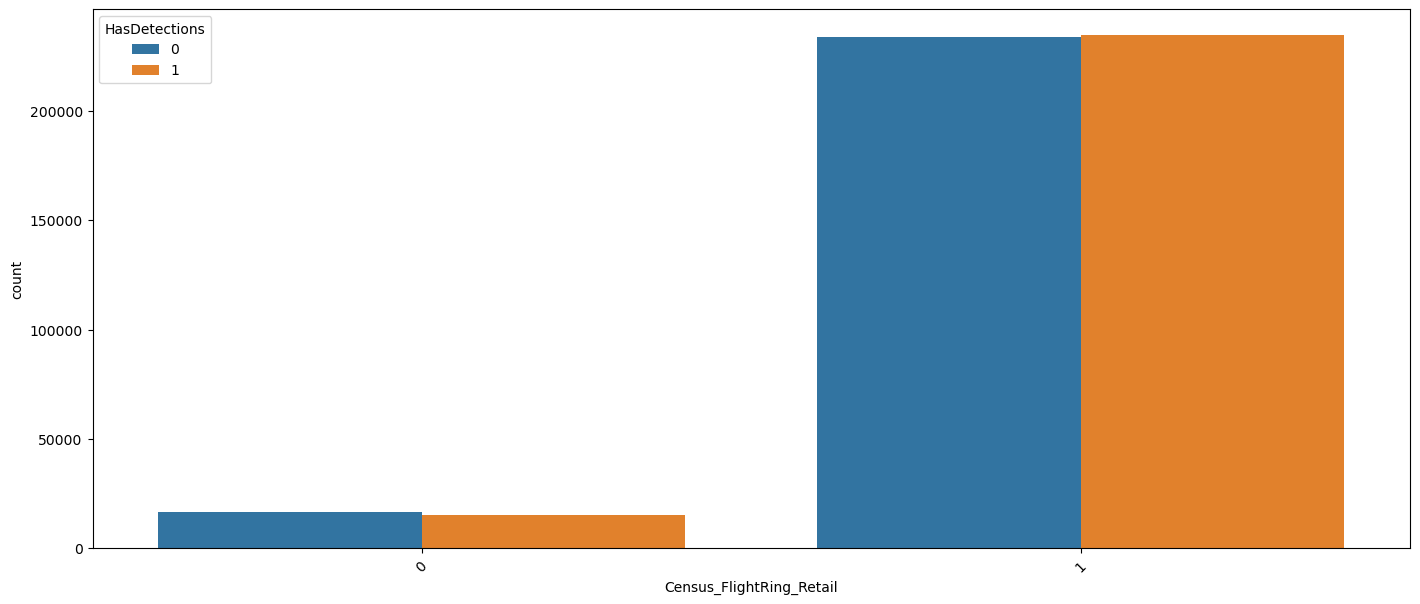

,Num_rows,Total_infections,mode_target,pct_infections
Census_FlightRing_Retail,,,,
0,31701,15260,0,0.481373
1,468299,234693,1,0.501161


In [161]:
cat_analysis_cl(df, 'Census_FlightRing_Retail', TARGET)

#### Census_FirmwareManufacturerIdentifier

In [162]:
#f['Census_FirmwareManufacturerIdentifier_so10'].value_counts().head(15)

In [163]:
df['Census_FirmwareManufacturerIdentifier_so10'] = setOthers(df,'imput_93__Census_FirmwareManufacturerIdentifier', 10).astype('str')
old_cols_drop.append('imput_93__Census_FirmwareManufacturerIdentifier')

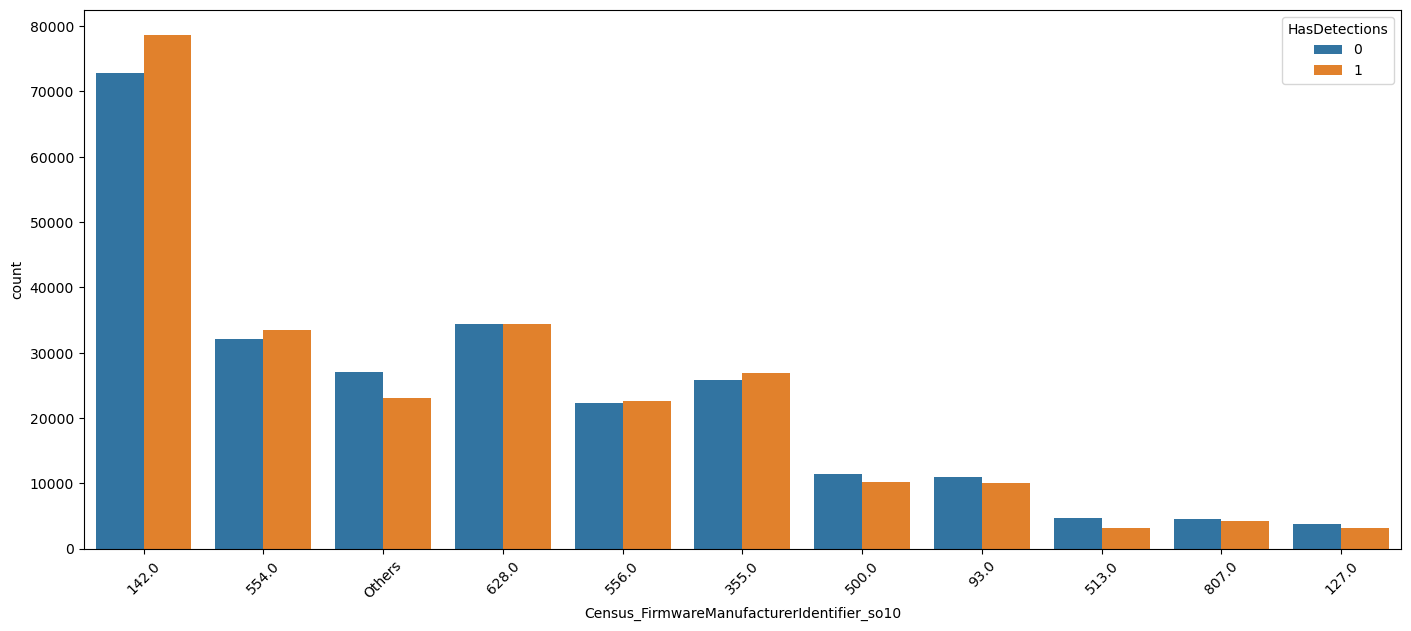

,Num_rows,Total_infections,mode_target,pct_infections
Census_FirmwareManufacturerIdentifier_so10,,,,
127.0,6933,3205,0,0.462282
142.0,151374,78575,1,0.519079
355.0,52758,26942,1,0.510671
500.0,21686,10177,0,0.469289
513.0,7899,3216,0,0.407140
554.0,65673,33489,1,0.509936
556.0,44919,22664,1,0.504553
628.0,68781,34370,0,0.499702
807.0,8803,4257,0,0.483585


In [164]:
cat_analysis_cl(df, 'Census_FirmwareManufacturerIdentifier_so10', TARGET)

In [165]:
trans_frecuency.append('Census_FirmwareManufacturerIdentifier_so10')

#### Census_IsSecureBootEnabled

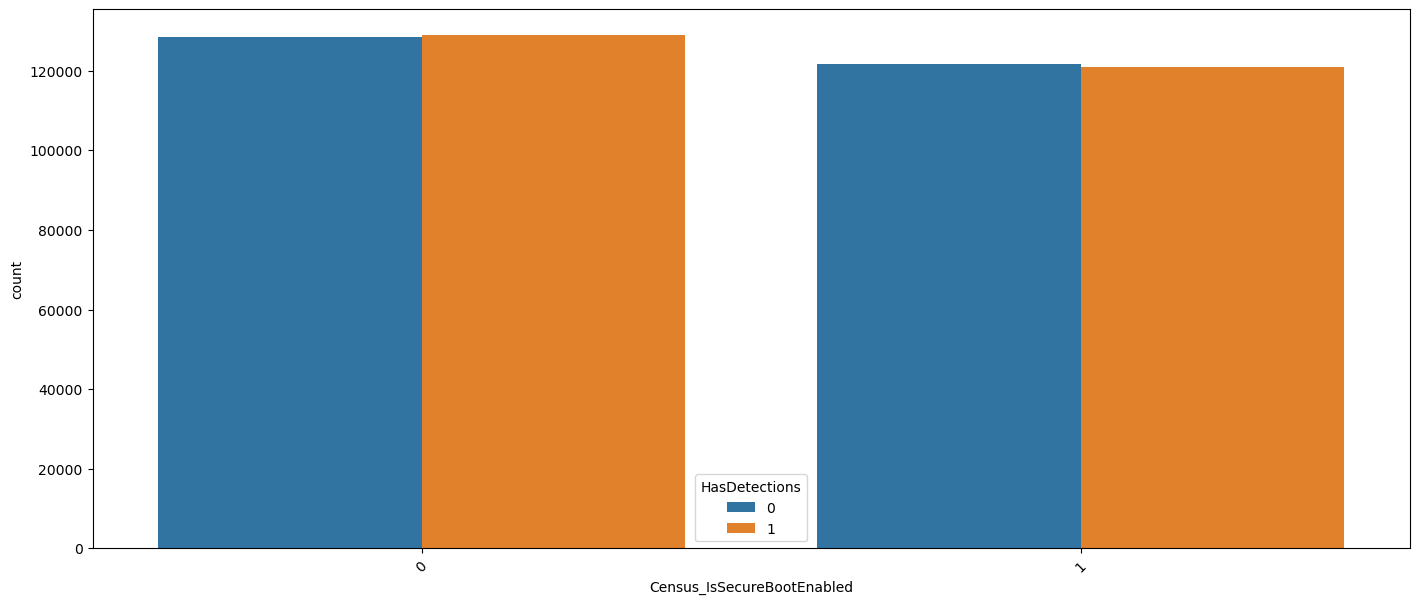

,Num_rows,Total_infections,mode_target,pct_infections
Census_IsSecureBootEnabled,,,,
0,257281,128927,1,0.501114
1,242719,121026,0,0.498626


In [166]:
cat_analysis_cl(df, 'Census_IsSecureBootEnabled', TARGET)

#### Census_IsWIMBootEnabled

In [167]:
#df.describe().T

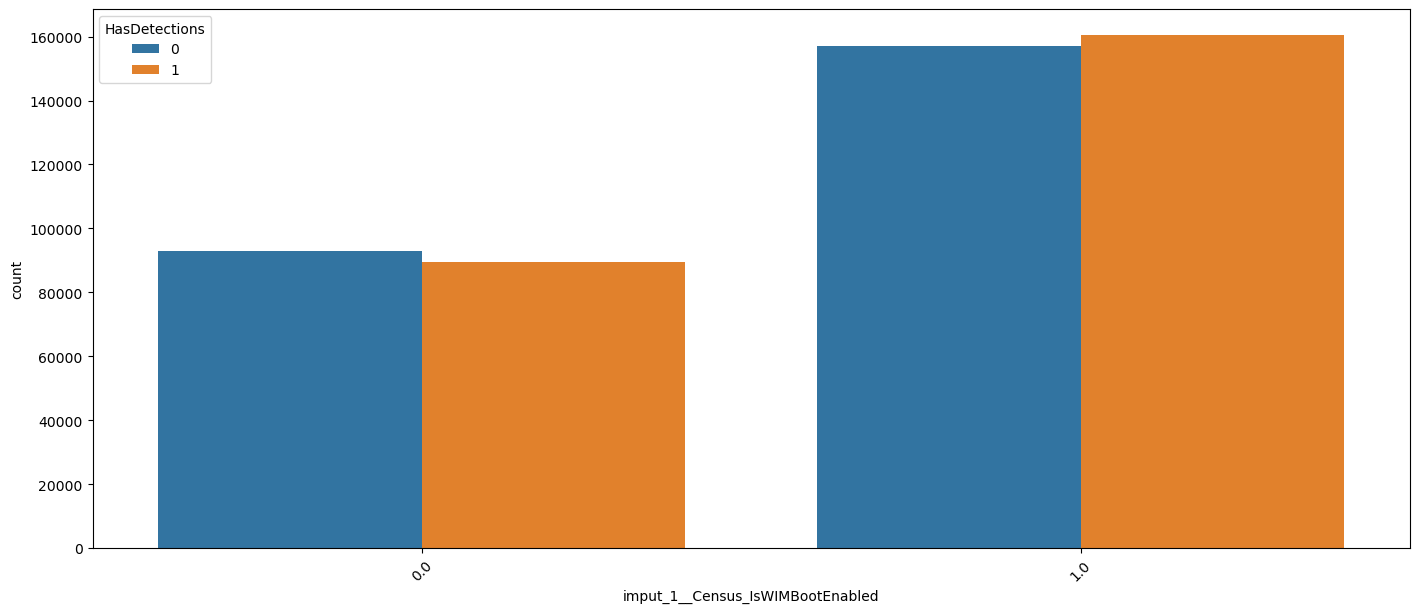

,Num_rows,Total_infections,mode_target,pct_infections
imput_1__Census_IsWIMBootEnabled,,,,
0.0,182334,89364,0,0.490112
1.0,317666,160589,1,0.505528


In [168]:
cat_analysis_cl(df, 'imput_1__Census_IsWIMBootEnabled', TARGET)

#### Census_IsVirtualDevice

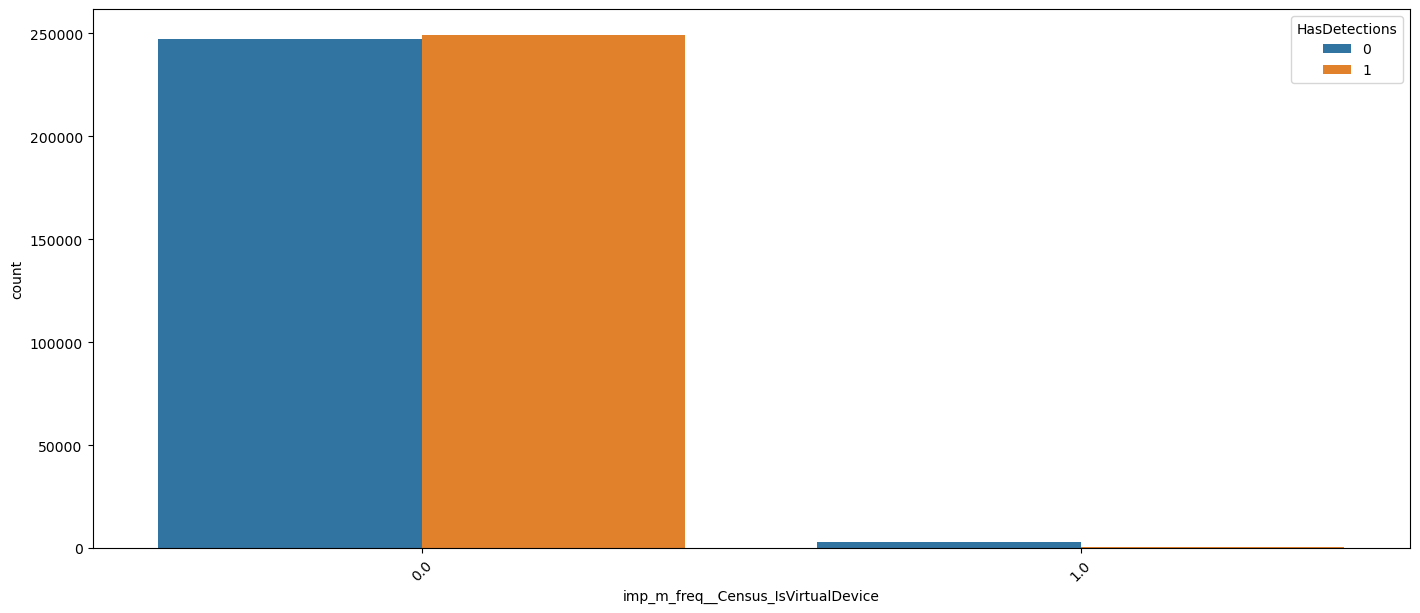

,Num_rows,Total_infections,mode_target,pct_infections
imp_m_freq__Census_IsVirtualDevice,,,,
0.0,496473,249241,1,0.502023
1.0,3527,712,0,0.201871


In [169]:
cat_analysis_cl(df, 'imp_m_freq__Census_IsVirtualDevice', TARGET)

In [170]:
old_cols_drop.append('imp_m_freq__Census_IsVirtualDevice')

#### Census_IsTouchEnabled

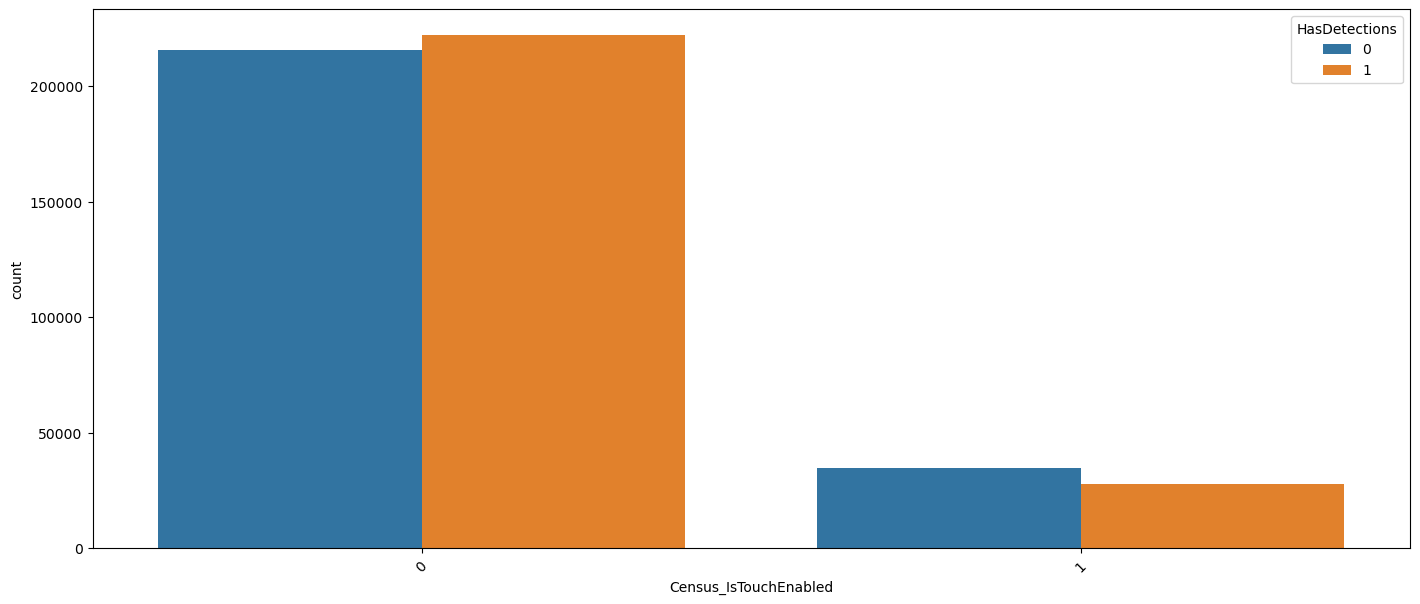

,Num_rows,Total_infections,mode_target,pct_infections
Census_IsTouchEnabled,,,,
0,437283,221964,1,0.507598
1,62717,27989,0,0.446275


In [171]:
cat_analysis_cl(df, 'Census_IsTouchEnabled', TARGET)

#### Census_IsAlwaysOnAlwaysConnectedCapable

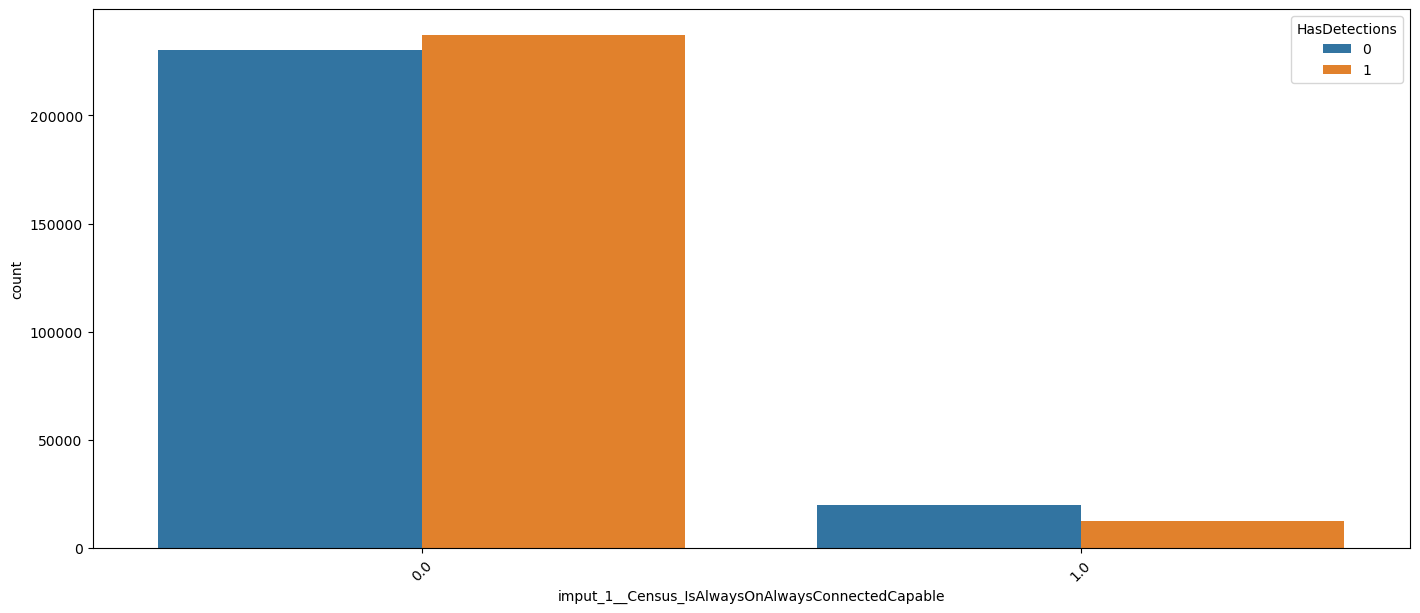

,Num_rows,Total_infections,mode_target,pct_infections
imput_1__Census_IsAlwaysOnAlwaysConnectedCapable,,,,
0.0,467569,237317,1,0.507555
1.0,32431,12636,0,0.389627


In [172]:
cat_analysis_cl(df, 'imput_1__Census_IsAlwaysOnAlwaysConnectedCapable', TARGET)

#### Wdft_IsGamer

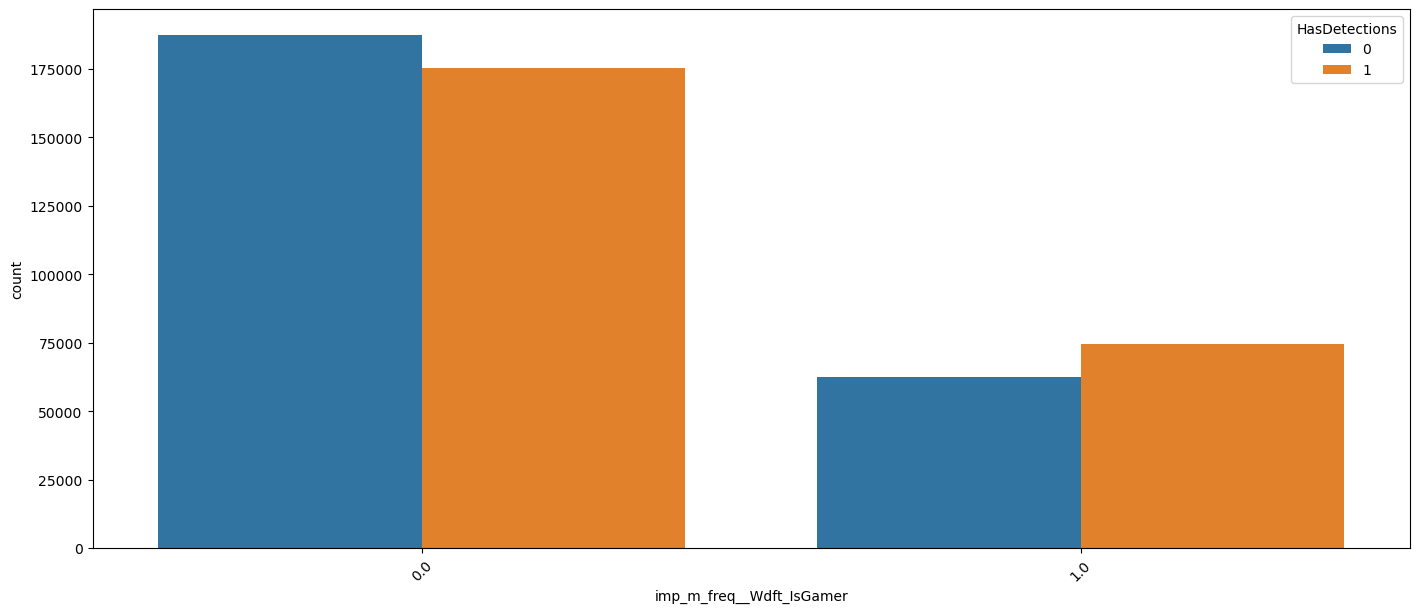

,Num_rows,Total_infections,mode_target,pct_infections
imp_m_freq__Wdft_IsGamer,,,,
0.0,362785,175275,0,0.483137
1.0,137215,74678,1,0.544241


In [173]:
cat_analysis_cl(df, 'imp_m_freq__Wdft_IsGamer', TARGET)

#### Wdft_RegionIdentifier

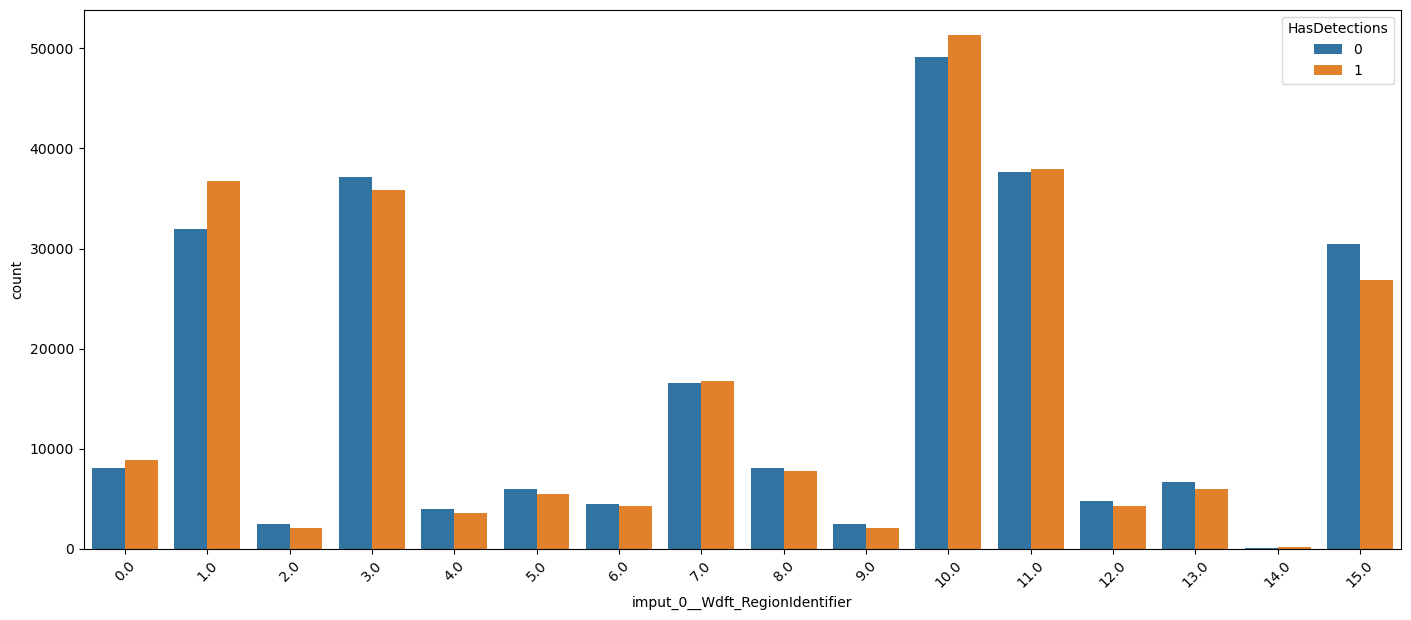

,Num_rows,Total_infections,mode_target,pct_infections
imput_0__Wdft_RegionIdentifier,,,,
0.0,16950,8859,1,0.522655
1.0,68692,36762,1,0.535171
2.0,4470,2026,0,0.453244
3.0,73069,35898,0,0.491289
4.0,7586,3600,0,0.474558
5.0,11466,5521,0,0.481511
6.0,8750,4234,0,0.483886
7.0,33362,16750,1,0.502068
8.0,15761,7732,0,0.490578


In [174]:
cat_analysis_cl(df, 'imput_0__Wdft_RegionIdentifier', TARGET)

In [175]:
trans_frecuency.append('imput_0__Wdft_RegionIdentifier')

#### Census_InternalBatteryNumberOfCharges

In [176]:
29936 + 12574

42510

In [177]:
df['imp_m_freq__Census_InternalBatteryNumberOfCharges_so2'] = setOthers(df, 'imp_m_freq__Census_InternalBatteryNumberOfCharges', 2).astype(str)
old_cols_drop.append('imp_m_freq__Census_InternalBatteryNumberOfCharges')

In [178]:
df['imp_m_freq__Census_InternalBatteryNumberOfCharges_so2'] = df['imp_m_freq__Census_InternalBatteryNumberOfCharges_so2'].replace('4294967295.0', '4295M')

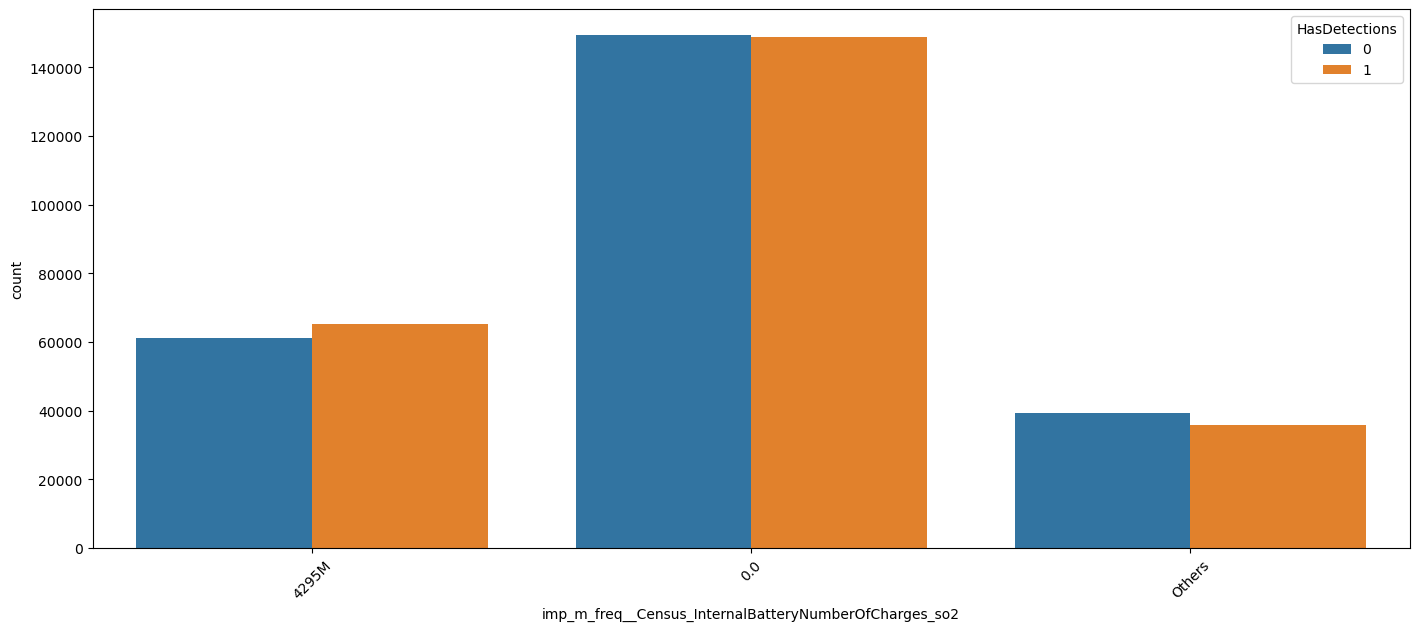

,Num_rows,Total_infections,mode_target,pct_infections
imp_m_freq__Census_InternalBatteryNumberOfCharges_so2,,,,
0.0,298227,148784,0,0.498895
4295M,126436,65208,1,0.515739
Others,75337,35961,0,0.477335


In [179]:
cat_analysis_cl(df, 'imp_m_freq__Census_InternalBatteryNumberOfCharges_so2', TARGET)

In [180]:
trans_OHE.append('imp_m_freq__Census_InternalBatteryNumberOfCharges_so2')

### 3.4.2. Numerical

#### Census_OEMModelIdentifier

In [181]:
#df['imput_xtr__Census_OEMModelIdentifier'].describe()

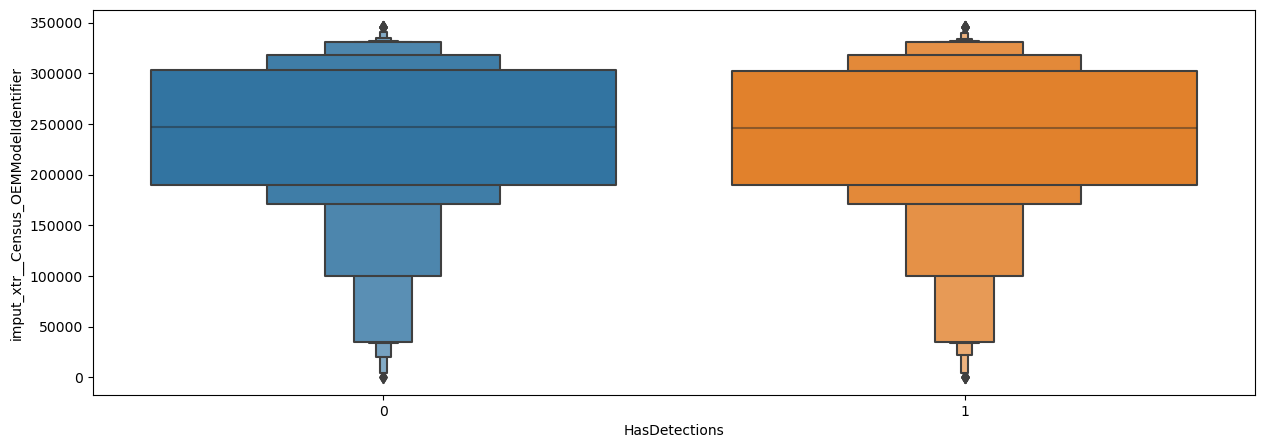

In [182]:
plot_biv_distrib(df, 'imput_xtr__Census_OEMModelIdentifier', TARGET)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


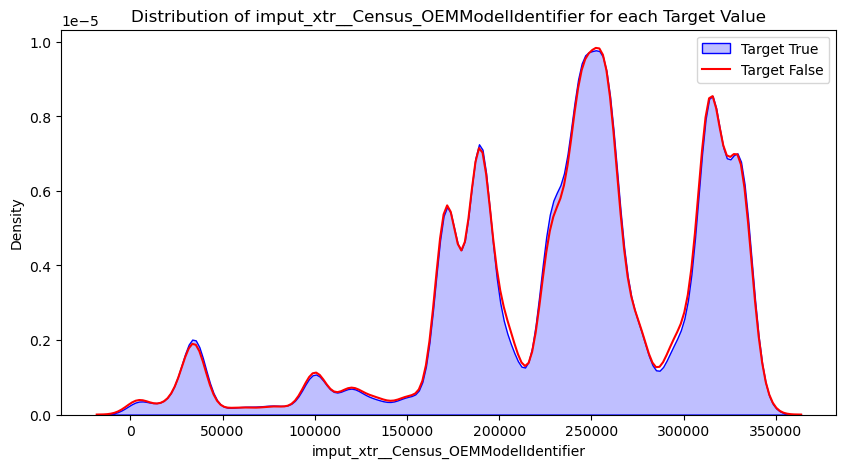

,n_rows,pct_rows,mean_target
bin,,,
"(1.0, 38389.0]",20268,0.041,0.508289
"(38389.0, 76777.0]",3356,0.007,0.521752
"(76777.0, 115165.0]",11076,0.022,0.493409
"(115165.0, 153553.0]",10948,0.022,0.486208
"(153553.0, 191941.0]",95505,0.191,0.502099
"(191941.0, 230329.0]",55092,0.110,0.500290
"(230329.0, 268717.0]",147463,0.295,0.502594
"(268717.0, 307105.0]",35102,0.070,0.482708
"(307105.0, 345493.0]",121189,0.242,0.499534


In [183]:
num_analisys_cl(df, 'imput_xtr__Census_OEMModelIdentifier', TARGET, 10)

In [184]:
old_cols_drop.append('imput_xtr__Census_OEMModelIdentifier')

#### Census_ProcessorModelIdentifier

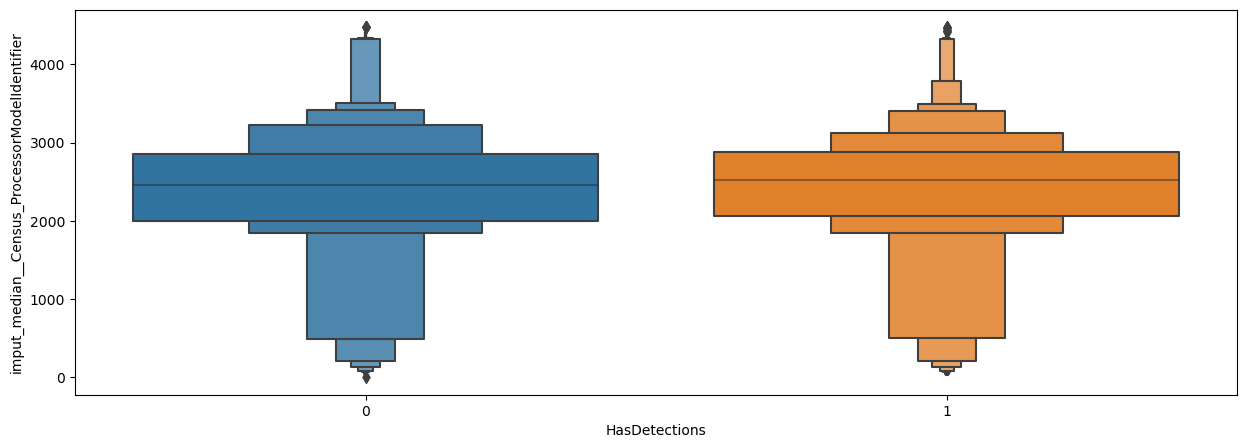

In [185]:
plot_biv_distrib(df, 'imput_median__Census_ProcessorModelIdentifier', TARGET)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


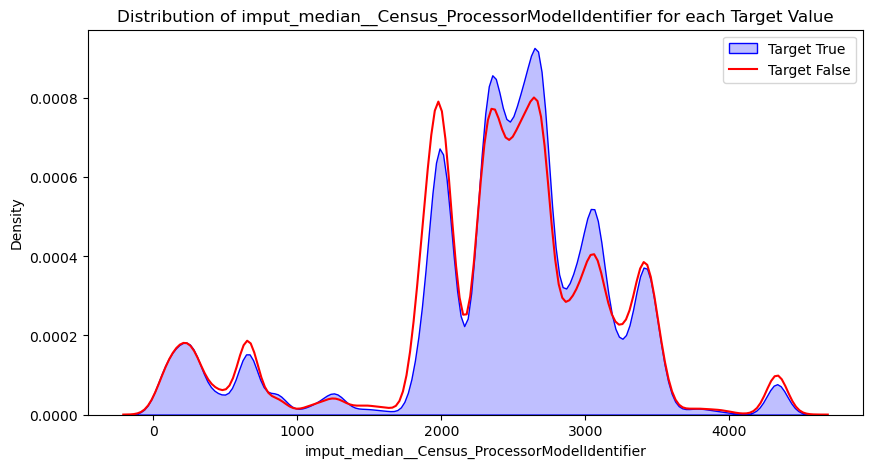

,n_rows,pct_rows,mean_target
bin,,,
"(3.0, 499.556]",31326,0.063,0.496808
"(499.556, 996.111]",19788,0.040,0.468921
"(996.111, 1492.667]",7150,0.014,0.517063
"(1492.667, 1989.222]",45008,0.090,0.391286
"(1989.222, 2485.778]",139642,0.279,0.503072
"(2485.778, 2982.333]",151028,0.302,0.529869
"(2982.333, 3478.889]",87269,0.175,0.516220
"(3478.889, 3975.444]",10580,0.021,0.470038
"(3975.444, 4472.0]",8208,0.016,0.427022


In [186]:
num_analisys_cl(df, 'imput_median__Census_ProcessorModelIdentifier', TARGET, 10)

In [187]:
trans_Standard = ['imput_median__Census_ProcessorModelIdentifier']

#### Census_PrimaryDiskTotalCapacity

In [188]:
#df['imput_mean__Census_PrimaryDiskTotalCapacity'].describe()

<Axes: xlabel='imput_mean__Census_PrimaryDiskTotalCapacity', ylabel='Density'>

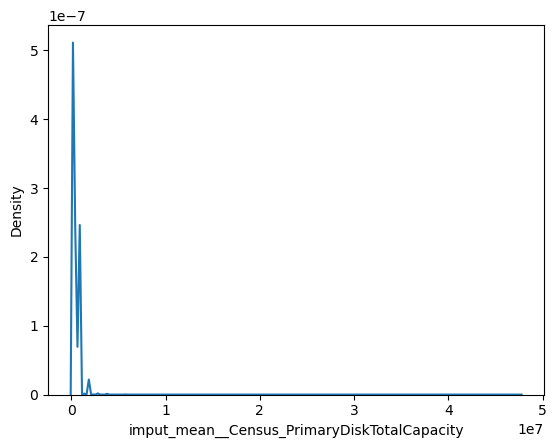

In [189]:
sns.kdeplot(df['imput_mean__Census_PrimaryDiskTotalCapacity'])

In [190]:
percent_may1 =  len(df[df['imput_mean__Census_PrimaryDiskTotalCapacity']> 1050000])
percent_less1 = len(df[df['imput_mean__Census_PrimaryDiskTotalCapacity']< 1050000])
print('Con menos de 1,000,000 MB hay un porcentaje de', percent_less1 / percent_may1)

Con menos de 1,000,000 MB hay un porcentaje de 72.07804735457468


In [191]:
df['Census_PrimaryDiskTotalCapacity_log10'] = np.log10(df['imput_mean__Census_PrimaryDiskTotalCapacity'])
old_cols_drop.append('imput_mean__Census_PrimaryDiskTotalCapacity')

<Axes: xlabel='Census_PrimaryDiskTotalCapacity_log10', ylabel='Density'>

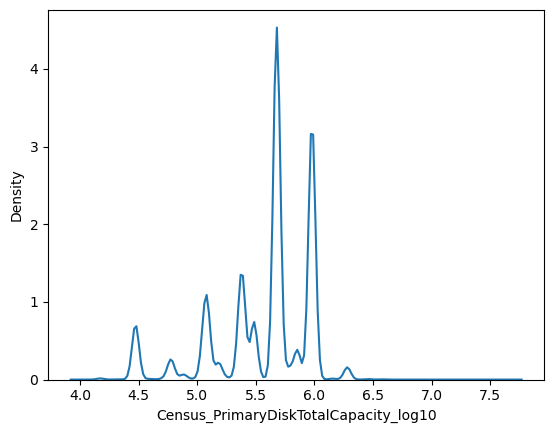

In [192]:
sns.kdeplot(df['Census_PrimaryDiskTotalCapacity_log10'])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


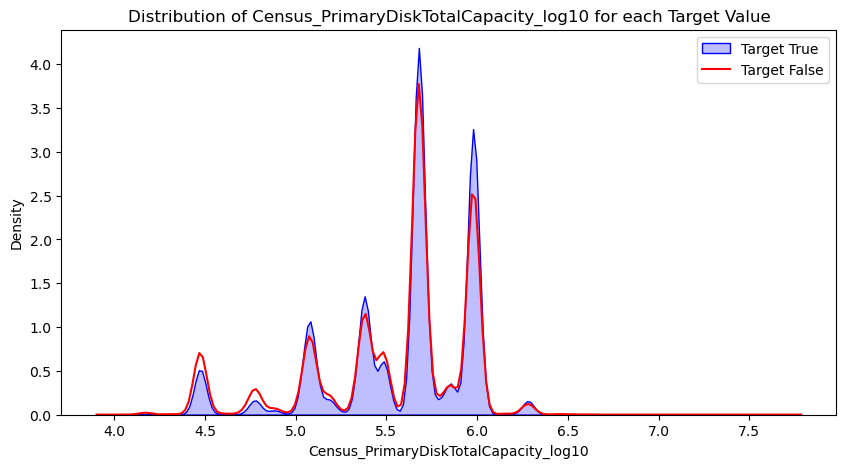

,n_rows,pct_rows,mean_target
bin,,,
"(4.01, 4.469]",1759,0.004,0.314383
"(4.469, 4.927]",39037,0.078,0.380383
"(4.927, 5.386]",84416,0.169,0.508648
"(5.386, 5.844]",229904,0.460,0.498308
"(5.844, 6.303]",144440,0.289,0.531792
"(6.303, 6.761]",422,0.001,0.540284
"(6.761, 7.22]",16,0.000,0.562500
"(7.22, 7.678]",5,0.000,0.200000


In [193]:
num_analisys_cl(df,'Census_PrimaryDiskTotalCapacity_log10', TARGET,  9)

In [194]:
trans_MinMax = ['Census_PrimaryDiskTotalCapacity_log10']

#### Census_SystemVolumeTotalCapacity

<Axes: xlabel='imput_median__Census_SystemVolumeTotalCapacity', ylabel='Density'>

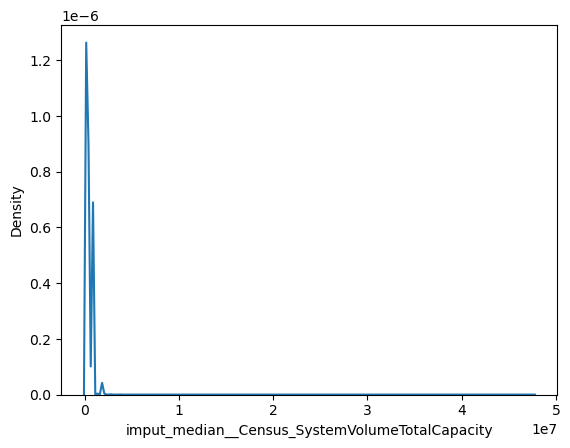

In [195]:
sns.kdeplot(df['imput_median__Census_SystemVolumeTotalCapacity'])

In [196]:
df['Census_SystemVolumeTotalCapacity_log10'] = np.log10(df['imput_median__Census_SystemVolumeTotalCapacity'])
old_cols_drop.append('imput_median__Census_SystemVolumeTotalCapacity')

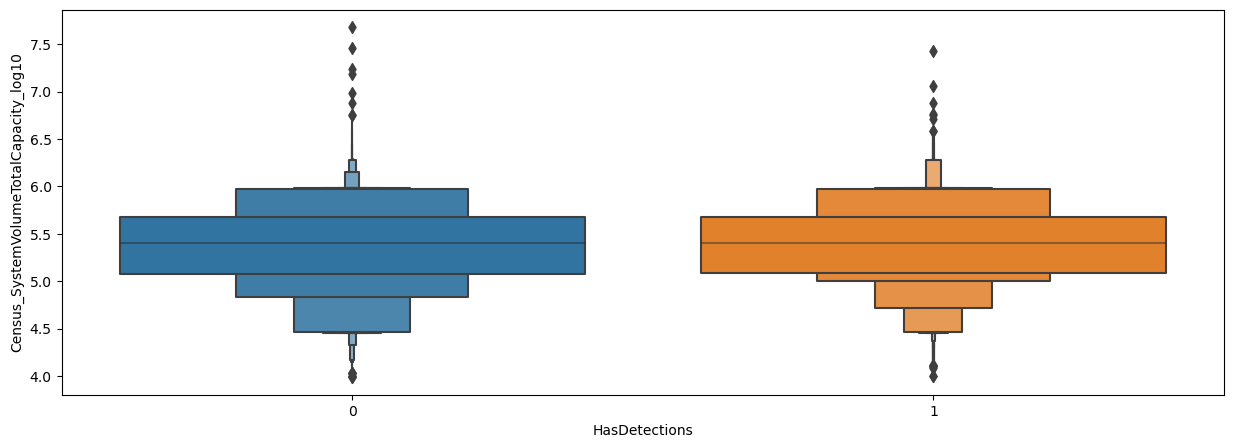

In [197]:
plot_biv_distrib(df, 'Census_SystemVolumeTotalCapacity_log10', TARGET)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


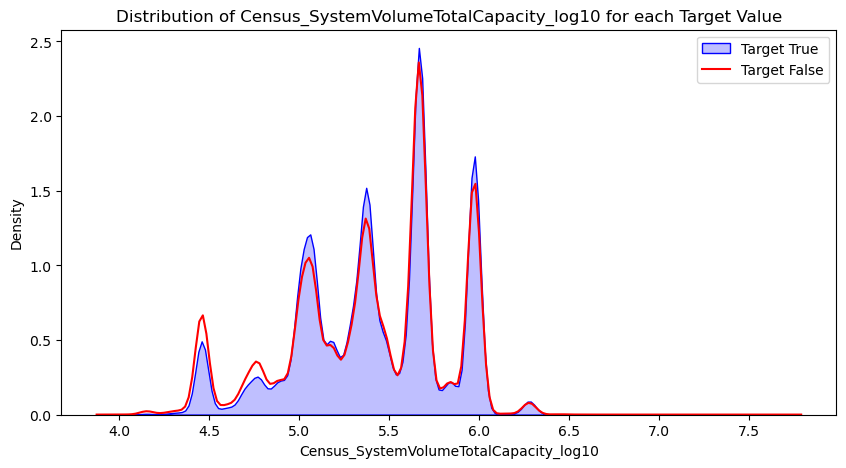

,n_rows,pct_rows,mean_target
bin,,,
"(3.986, 4.397]",2102,0.004,0.287821
"(4.397, 4.807]",49411,0.099,0.409443
"(4.807, 5.217]",112880,0.226,0.520996
"(5.217, 5.627]",127691,0.255,0.518040
"(5.627, 6.037]",203525,0.407,0.500597
"(6.037, 6.448]",4255,0.009,0.517039
"(6.448, 6.858]",126,0.000,0.563492
"(6.858, 7.268]",6,0.000,0.333333
"(7.268, 7.678]",3,0.000,0.333333


In [198]:
num_analisys_cl(df, 'Census_SystemVolumeTotalCapacity_log10', TARGET, 10)

In [199]:
trans_MinMax.append('Census_SystemVolumeTotalCapacity_log10')

#### Census_TotalPhysicalRAM

<Axes: xlabel='imput_median__Census_TotalPhysicalRAM', ylabel='Density'>

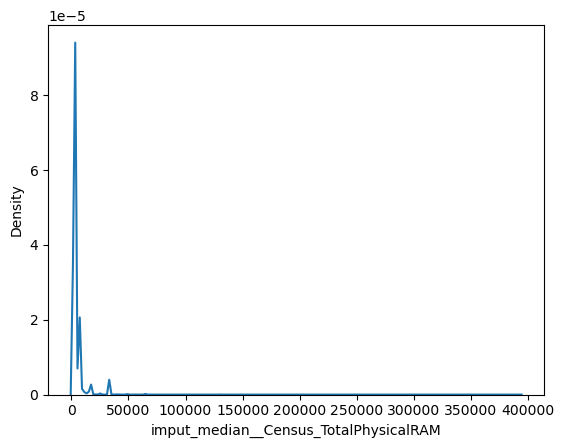

In [200]:
sns.kdeplot(df['imput_median__Census_TotalPhysicalRAM'])

In [201]:
df['Census_TotalPhysicalRAM_log10'] = np.log10(df['imput_median__Census_TotalPhysicalRAM'])
old_cols_drop.append('imput_median__Census_TotalPhysicalRAM')

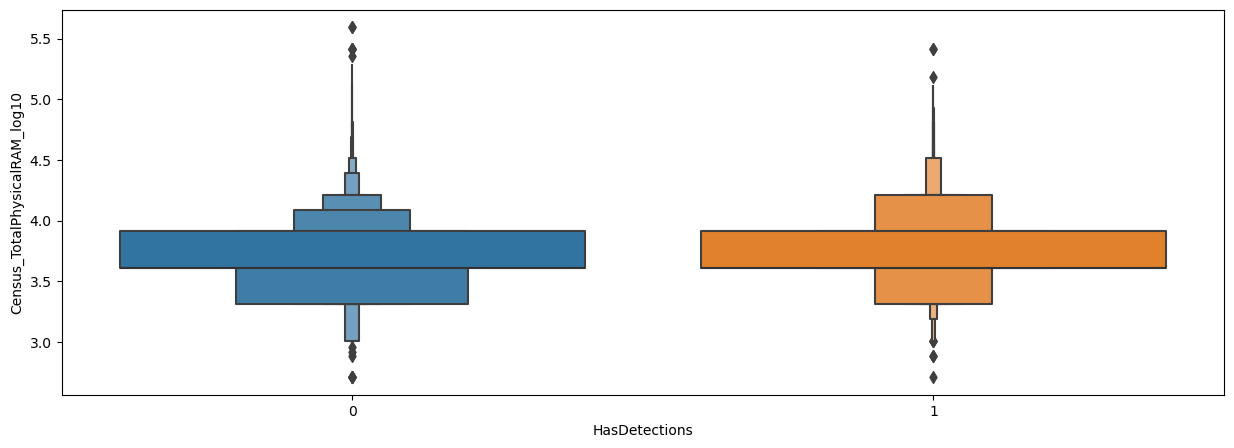

In [202]:
plot_biv_distrib(df, 'Census_TotalPhysicalRAM_log10', TARGET)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


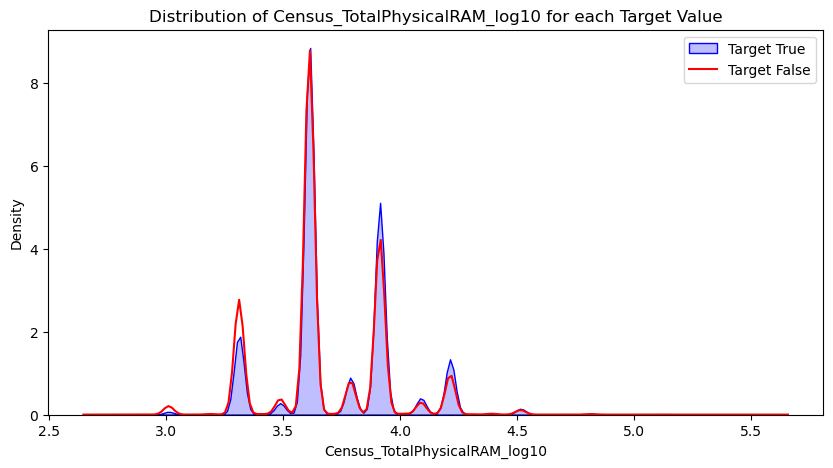

,n_rows,pct_rows,mean_target
bin,,,
"(2.709, 3.03]",3637,0.007,0.245807
"(3.03, 3.35]",62317,0.125,0.404833
"(3.35, 3.671]",242659,0.485,0.493792
"(3.671, 3.992]",146462,0.293,0.534931
"(3.992, 4.312]",40338,0.081,0.573157
"(4.312, 4.633]",4077,0.008,0.563159
"(4.633, 4.953]",422,0.001,0.504739
"(4.953, 5.274]",69,0.000,0.420290
"(5.274, 5.595]",13,0.000,0.153846


In [203]:
num_analisys_cl(df, 'Census_TotalPhysicalRAM_log10', TARGET, 10)

In [204]:

trans_MinMax.append('Census_TotalPhysicalRAM_log10')

#### Census_InternalPrimaryDiagonalDisplaySizeInInches

In [205]:
df['imput_mean__Census_InternalPrimaryDiagonalDisplaySizeInInches'].describe()

count    500000.000000
mean         16.689837
std           5.916250
min           4.900000
25%          13.900000
50%          15.500000
75%          17.200000
max         142.000000
Name: imput_mean__Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float64

<Axes: xlabel='imput_mean__Census_InternalPrimaryDiagonalDisplaySizeInInches', ylabel='Density'>

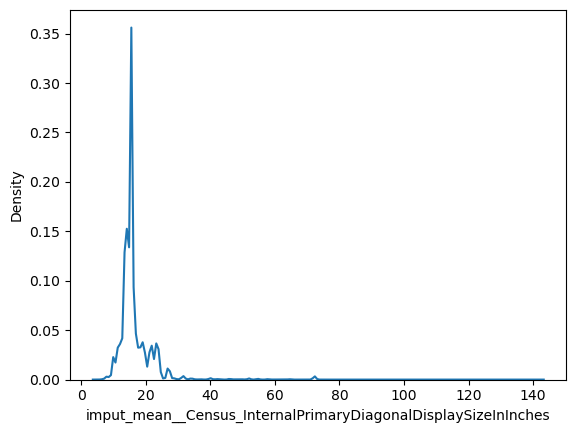

In [206]:
sns.kdeplot(df['imput_mean__Census_InternalPrimaryDiagonalDisplaySizeInInches'])

In [207]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches_log10'] = np.log10(df['imput_mean__Census_InternalPrimaryDiagonalDisplaySizeInInches'])
old_cols_drop.append('imput_mean__Census_InternalPrimaryDiagonalDisplaySizeInInches')

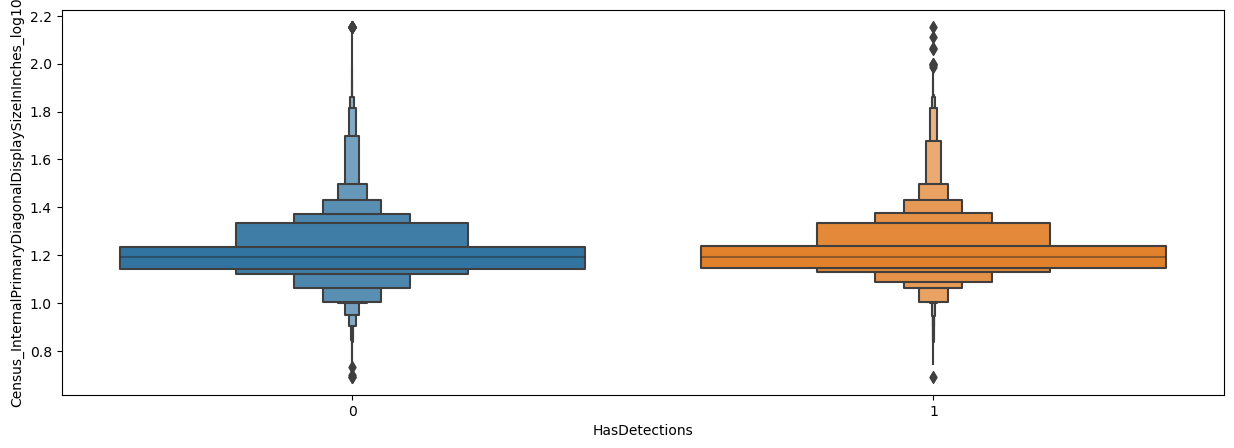

In [208]:
plot_biv_distrib(df, 'Census_InternalPrimaryDiagonalDisplaySizeInInches_log10', TARGET)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


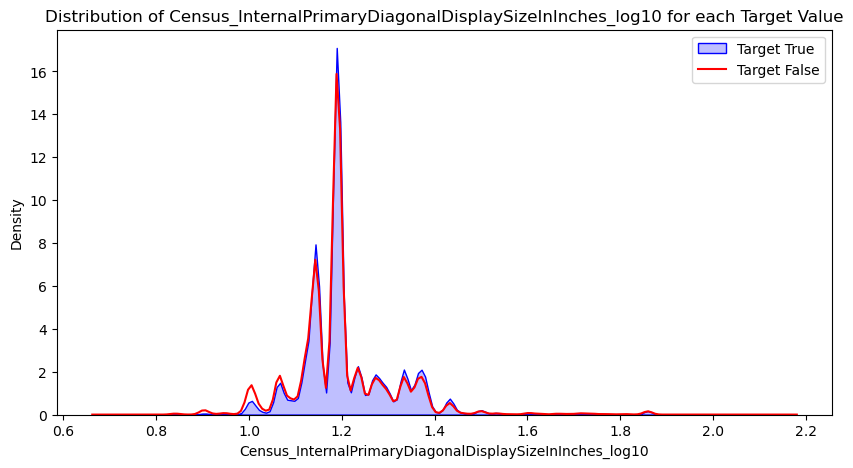

,n_rows,pct_rows,mean_target
bin,,,
"(0.69, 0.853]",368,0.001,0.165761
"(0.853, 1.015]",14888,0.030,0.299704
"(1.015, 1.178]",147917,0.296,0.490728
"(1.178, 1.34]",282869,0.566,0.508727
"(1.34, 1.502]",46527,0.093,0.541922
"(1.502, 1.665]",3300,0.007,0.523636
"(1.665, 1.827]",2198,0.004,0.470883
"(1.827, 1.99]",1907,0.004,0.500787
"(1.99, 2.152]",23,0.000,0.304348


In [209]:
num_analisys_cl(df, 'Census_InternalPrimaryDiagonalDisplaySizeInInches_log10', TARGET, 10)

In [210]:
trans_MinMax.append('Census_InternalPrimaryDiagonalDisplaySizeInInches_log10')

#### Census_FirmwareVersionIdentifier

In [211]:
df['imput_mean__Census_FirmwareVersionIdentifier'].describe()

count    500000.000000
mean      33030.988944
std       21027.006068
min          10.000000
25%       13299.000000
50%       33060.000000
75%       52250.000000
max       72091.000000
Name: imput_mean__Census_FirmwareVersionIdentifier, dtype: float64

<Axes: xlabel='imput_mean__Census_FirmwareVersionIdentifier', ylabel='Density'>

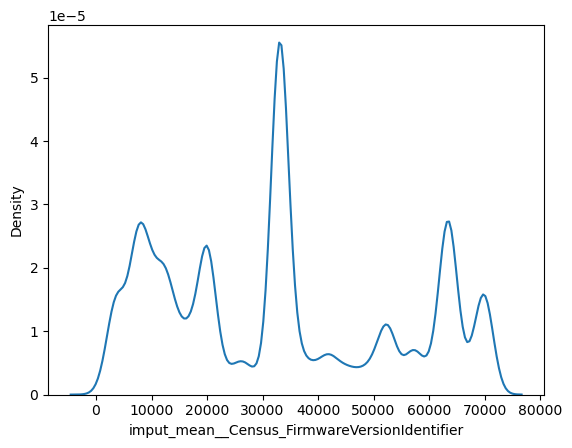

In [212]:

sns.kdeplot(df['imput_mean__Census_FirmwareVersionIdentifier'])

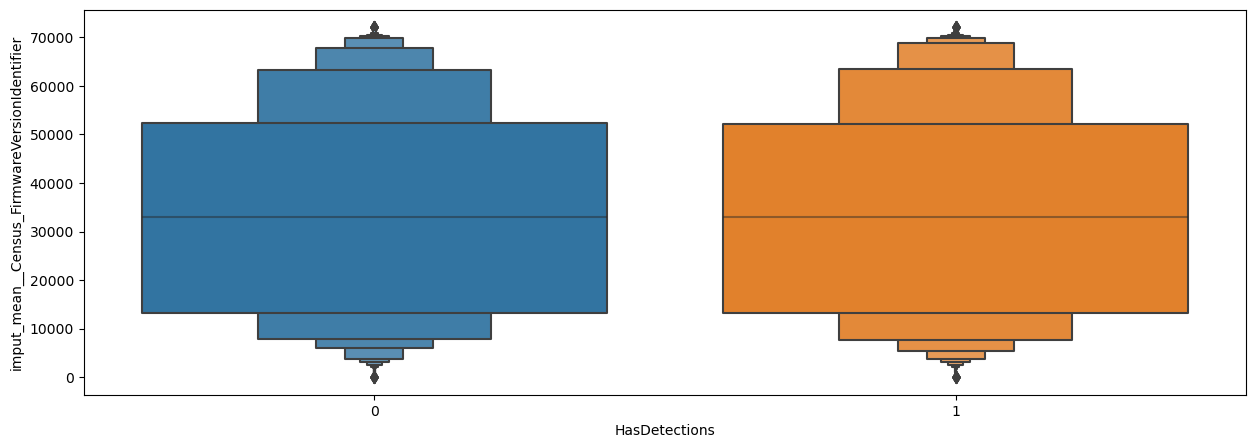

In [213]:
plot_biv_distrib(df, 'imput_mean__Census_FirmwareVersionIdentifier', TARGET)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 1][col], color='blue', label='Target True', shade= True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\3233042930.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dataframe[dataframe[target] == 0][col], color='red', label='Target False', shade=False)


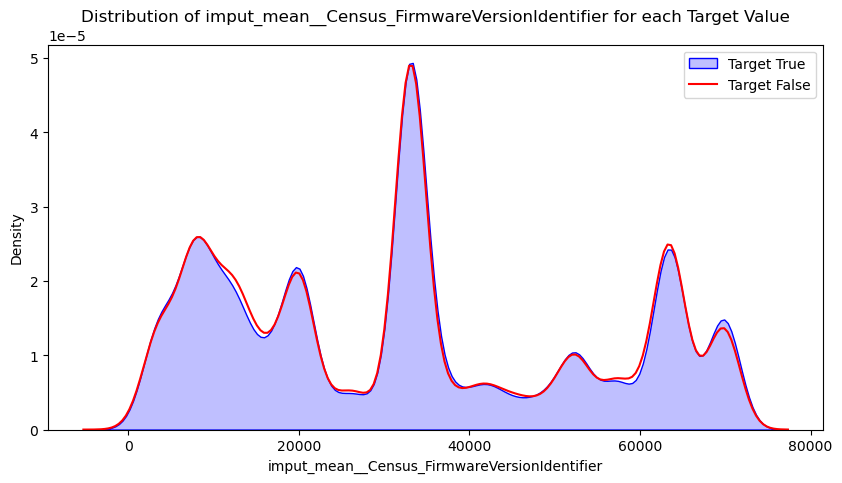

,n_rows,pct_rows,mean_target
bin,,,
"(10.0, 8019.0]",64550,0.129,0.505949
"(8019.0, 16028.0]",75965,0.152,0.484723
"(16028.0, 24037.0]",60738,0.121,0.507936
"(24037.0, 32046.0]",20382,0.041,0.488863
"(32046.0, 40055.0]",117847,0.236,0.506004
"(40055.0, 48064.0]",21189,0.042,0.489263
"(48064.0, 56073.0]",30328,0.061,0.508276
"(56073.0, 64082.0]",63007,0.126,0.488231
"(64082.0, 72091.0]",45993,0.092,0.510556


In [214]:
num_analisys_cl(df, 'imput_mean__Census_FirmwareVersionIdentifier', TARGET, 10)

In [215]:
trans_MinMax.append('imput_mean__Census_FirmwareVersionIdentifier')

In [216]:
df.drop(old_cols_drop, axis =1, inplace = True)

In [217]:
df.drop(['Unnamed: 0', 'bin'], axis =1, inplace = True)


In [218]:
df.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
Census_HasOpticalDiskDrive,500000.0,0.077034,0.266646,0.000000,0.000000,0.000000,0.000000,1.000000
Census_IsSecureBootEnabled,500000.0,0.485438,0.499788,0.000000,0.000000,0.000000,1.000000,1.000000
Census_IsTouchEnabled,500000.0,0.125434,0.331211,0.000000,0.000000,0.000000,0.000000,1.000000
HasDetections,500000.0,0.499906,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
imput_1__Census_IsWIMBootEnabled,500000.0,0.635332,0.481337,0.000000,0.000000,1.000000,1.000000,1.000000
imput_1__SMode,500000.0,0.060108,0.237687,0.000000,0.000000,0.000000,0.000000,1.000000
imput_1__Census_IsAlwaysOnAlwaysConnectedCapable,500000.0,0.064862,0.246282,0.000000,0.000000,0.000000,0.000000,1.000000
imput_0__Wdft_RegionIdentifier,500000.0,7.621154,4.696197,0.000000,3.000000,10.000000,11.000000,15.000000
imput_0__IsProtected,500000.0,0.942146,0.233467,0.000000,1.000000,1.000000,1.000000,1.000000
imput_0__Firewall,500000.0,0.968142,0.175622,0.000000,1.000000,1.000000,1.000000,1.000000


In [219]:
df.describe(exclude = 'number').T

,count,unique,top,freq
MachineIdentifier,500000,500000,f790fe9aa6ddef7a6ec46ee482f0d1fb,1
ProductName,500000,3,win8defender,494604
OrganizationIdentifier,500000.0,6.0,27.0,234885.0
SmartScreen,500000,6,RequireAdmin,241594
Census_DeviceFamily,500000,3,Windows.Desktop,499183
Census_ProcessorCoreCount,500000,6,4.0,304102
IeVerIdentifier_so8,500000.0,9.0,137.0,219142.0
Census_PrimaryDiskTypeName_so2,500000,3,HDD,325429
imput_0__CityIdentifier,500000,37158,0.0,18240
AvSigVersion_so4,500000,5,1.275,219654


## 4. Preprocessing

In [220]:
len(df.columns)

59

In [221]:
objects = df.select_dtypes(include= 'object').columns.to_list()
numbers = df.select_dtypes(include= 'number').columns.to_list()
len(df.columns) - (len(objects) + len(numbers))
non_standard_types = [col for col in df.columns if df[col].dtype not in ['object', 'float', 'int', 'int64']]
len(non_standard_types)

10

In [222]:
df[non_standard_types] = df[non_standard_types].astype('str')

In [223]:
columns_with_mixed_types = {}
for col in df.columns:
    unique_types = df[col].apply(type).unique()
    
    if len(unique_types) > 1:
        columns_with_mixed_types[col] = unique_types

for col, types in columns_with_mixed_types.items():
    print(f"Column '{col}' have mixed dtypes: {types}")

columns_with_mixed_types

{}

### 4.1. Transformers

In [224]:
df_p = df

In [225]:
trans_ordinal

['AvSigVersion_so4',
 'GeoNameIdentifier_so45',
 'LocaleEnglishNameIdentifier_so35',
 'OsBuild_so6',
 'OsPlatformSubRelease_so6',
 'IeVerIdentifier_so8',
 'Census_OEMNameIdentifier_so30',
 'Census_ProcessorCoreCount',
 'Census_PowerPlatformRoleName_so3',
 'Census_OSBranch_so7',
 'Census_OSBuildNumber_so3',
 'Census_OSBuildRevision_so35',
 'Census_OSInstallLanguageIdentifier_so15',
 'Census_OSUILocaleIdentifier_so25']

In [226]:
trans_frecuency

['CountryId_group',
 'imput_0__CityIdentifier',
 'OrganizationIdentifier',
 'OsBuildLab_so6',
 'SmartScreen',
 'Census_MDC2FormFactor_so5',
 'Census_FirmwareManufacturerIdentifier_so10',
 'imput_0__Wdft_RegionIdentifier']

In [227]:
trans_OHE

['Census_PrimaryDiskTypeName_so2',
 'Census_OSEdition_so3',
 'Census_OSInstallTypeName_so5',
 'Census_OSWUAutoUpdateOptionsName_so3',
 'Census_ActivationChannel_so2',
 'imp_m_freq__Census_InternalBatteryNumberOfCharges_so2']

In [228]:
trans_MinMax

['Census_PrimaryDiskTotalCapacity_log10',
 'Census_SystemVolumeTotalCapacity_log10',
 'Census_TotalPhysicalRAM_log10',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches_log10',
 'imput_mean__Census_FirmwareVersionIdentifier']

In [229]:
trans_Standard

['imput_median__Census_ProcessorModelIdentifier']

In [230]:
cols_to_drop = trans_ordinal + trans_OHE + trans_MinMax + trans_Standard + trans_frecuency

In [231]:
ct_prep = ColumnTransformer(
    transformers = [
        ('ordinal', OrdinalEncoder(), trans_ordinal),
        ('OHE', OneHotEncoder(sparse_output= False), trans_OHE),
        ('Frequency', ce.CountEncoder(), trans_frecuency),
        ('MinMax', MinMaxScaler(), trans_MinMax),
        ('Scaler', StandardScaler(), trans_Standard)
    ]
)

In [232]:
df_prep = ct_prep.fit_transform(df_p)
df_p = df_p.merge(df_prep, left_index = True, right_index = True)
df_p.drop(cols_to_drop, axis = 1, inplace = True)

In [233]:
df_p.shape

(500000, 75)

In [234]:
df_p.describe(include= 'object').T

,count,unique,top,freq
MachineIdentifier,500000,500000,f790fe9aa6ddef7a6ec46ee482f0d1fb,1
ProductName,500000,3,win8defender,494604
Census_DeviceFamily,500000,3,Windows.Desktop,499183


In [235]:
df_p.drop(['MachineIdentifier', 'ProductName', 'Census_DeviceFamily'], axis=1, inplace=True)

### 4.2. Correlation

In [236]:
corr = df_p.corr()
corr_filtered = corr[((corr > 0.7) & (corr < 1.0)) | (corr < -0.7)]
corr_filtered = corr_filtered.dropna(axis=0, how='all').dropna(axis=1, how='all')
styled_corr = corr_filtered.style.background_gradient(cmap='coolwarm')

styled_corr

,AV_prodinst_imputed__AVProductsInstalled,AVProductStatesIdentifier_53447,Platform_windows10,OsVer_10,OsSuite_768,SkuEdition_Home,imput_1__Census_ProcessorManufacturerIdentifier_5.0,OHE__Census_PrimaryDiskTypeName_so2_HDD,OHE__Census_PrimaryDiskTypeName_so2_SSD,OHE__Census_OSEdition_so3_Professional,OHE__Census_ActivationChannel_so2_OEM:DM,OHE__Census_ActivationChannel_so2_Retail,OHE__imp_m_freq__Census_InternalBatteryNumberOfCharges_so2_0.0,OHE__imp_m_freq__Census_InternalBatteryNumberOfCharges_so2_4295M,MinMax__Census_PrimaryDiskTotalCapacity_log10,MinMax__Census_SystemVolumeTotalCapacity_log10,Scaler__imput_median__Census_ProcessorModelIdentifier
AV_prodinst_imputed__AVProductsInstalled,nan,-0.858781,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AVProductStatesIdentifier_53447,-0.858781,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Platform_windows10,nan,nan,nan,0.974906,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OsVer_10,nan,nan,0.974906,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OsSuite_768,nan,nan,nan,nan,nan,0.988695,nan,nan,nan,-0.941594,nan,nan,nan,nan,nan,nan,nan
SkuEdition_Home,nan,nan,nan,nan,0.988695,nan,nan,nan,nan,-0.932331,nan,nan,nan,nan,nan,nan,nan
imput_1__Census_ProcessorManufacturerIdentifier_5.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.782999
OHE__Census_PrimaryDiskTypeName_so2_HDD,nan,nan,nan,nan,nan,nan,nan,nan,-0.843653,nan,nan,nan,nan,nan,0.704846,nan,nan
OHE__Census_PrimaryDiskTypeName_so2_SSD,nan,nan,nan,nan,nan,nan,nan,-0.843653,nan,nan,nan,nan,nan,nan,-0.713115,nan,nan
OHE__Census_OSEdition_so3_Professional,nan,nan,nan,nan,-0.941594,-0.932331,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [237]:
corr = df_p.corr()

correlated_values = corr[((corr > 0.8) & (corr < 1.0)) | (corr < -0.8)].stack().dropna()

correlated_values_sorted = correlated_values.sort_values(ascending=False)

print(correlated_values_sorted)

OsSuite_768                                     SkuEdition_Home                                   0.988695
SkuEdition_Home                                 OsSuite_768                                       0.988695
Platform_windows10                              OsVer_10                                          0.974906
OsVer_10                                        Platform_windows10                                0.974906
MinMax__Census_PrimaryDiskTotalCapacity_log10   MinMax__Census_SystemVolumeTotalCapacity_log10    0.804582
MinMax__Census_SystemVolumeTotalCapacity_log10  MinMax__Census_PrimaryDiskTotalCapacity_log10     0.804582
OHE__Census_ActivationChannel_so2_OEM:DM        OHE__Census_ActivationChannel_so2_Retail         -0.835895
OHE__Census_ActivationChannel_so2_Retail        OHE__Census_ActivationChannel_so2_OEM:DM         -0.835895
OHE__Census_PrimaryDiskTypeName_so2_HDD         OHE__Census_PrimaryDiskTypeName_so2_SSD          -0.843653
OHE__Census_PrimaryDiskTypeName_so2_S

In [238]:
var_corr_drop = ['Platform_windows10']

In [239]:
df_p.drop(var_corr_drop, axis= 1, inplace = True)

In [240]:
corr = df_p.corr()

correlated_values = corr[((corr > 0.3) & (corr <= 0.7)) | (corr < -0.3) & (corr >= -0.7)].stack().dropna()

correlated_values_sorted = correlated_values.sort_values(ascending=False)

print(correlated_values_sorted)

ordinal__Census_PowerPlatformRoleName_so3                         imput_1__Census_IsAlwaysOnAlwaysConnectedCapable                    0.650841
imput_1__Census_IsAlwaysOnAlwaysConnectedCapable                  ordinal__Census_PowerPlatformRoleName_so3                           0.650841
ordinal__Census_OSBuildNumber_so3                                 ordinal__IeVerIdentifier_so8                                        0.645839
ordinal__IeVerIdentifier_so8                                      ordinal__Census_OSBuildNumber_so3                                   0.645839
OHE__imp_m_freq__Census_InternalBatteryNumberOfCharges_so2_4295M  MinMax__Census_InternalPrimaryDiagonalDisplaySizeInInches_log10     0.615531
                                                                                                                                        ...   
                                                                  ordinal__Census_PowerPlatformRoleName_so3                          -0.585752

## 5. Modelling

### 5.1. Validation strategy

In [241]:
df['ProductName'].value_counts()

win8defender     494604
mse                5395
mseprerelease         1
Name: ProductName, dtype: int64

In [242]:
df_m = df_p

In [243]:
X_train_, X_val, y_train_, y_val = train_test_split(df_m.drop(TARGET, axis=1), df_m[TARGET], test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size = 0.20, random_state = 42)

In [244]:
print(f'Xtrain: {X_train.shape}, Xtest: {X_test.shape}, Xval: {X_val.shape}')

Xtrain: (340000, 70), Xtest: (85000, 70), Xval: (75000, 70)


In [245]:
def validation_strategy_cl(dataframe):
    X_train_, X_val, y_train_, y_val = train_test_split(df_m.drop(TARGET, axis=1), df_m[TARGET], test_size=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size = 0.20, random_state = 42)
    X_train_, X_val, y_train_, y_val = train_test_split(df_m.drop(TARGET, axis=1), df_m[TARGET], test_size=0.15, random_state=42)
    return X_train, X_test, y_train, y_test, X_val, y_val

### 5.2. Testing algorithms

#### 5.2.1. Decision Tree

In [246]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000,random_state=42,)

In [247]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000, random_state=42)

In [248]:
X_train.describe().T.head(5)

,count,mean,std,min,25%,50%,75%,max
Census_HasOpticalDiskDrive,340000.0,0.076947,0.266508,0.0,0.0,0.0,0.0,1.0
Census_IsSecureBootEnabled,340000.0,0.486103,0.499808,0.0,0.0,0.0,1.0,1.0
Census_IsTouchEnabled,340000.0,0.125706,0.331518,0.0,0.0,0.0,0.0,1.0
imput_1__Census_IsWIMBootEnabled,340000.0,0.634876,0.481465,0.0,0.0,1.0,1.0,1.0
imput_1__SMode,340000.0,0.060159,0.237781,0.0,0.0,0.0,0.0,1.0


In [249]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Census_HasOpticalDiskDrive,85000.0,0.076588,0.265939,0.0,0.0,0.0,0.0,1.0
Census_IsSecureBootEnabled,85000.0,0.484224,0.499754,0.0,0.0,0.0,1.0,1.0
Census_IsTouchEnabled,85000.0,0.124859,0.330561,0.0,0.0,0.0,0.0,1.0
imput_1__Census_IsWIMBootEnabled,85000.0,0.636647,0.480968,0.0,0.0,1.0,1.0,1.0
imput_1__SMode,85000.0,0.059859,0.237226,0.0,0.0,0.0,0.0,1.0


In [250]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        feature_names=X_test.columns,
                        class_names=['Infected', 'No Infected'],
                        filled=True,
                        impurity=True,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        precision=4,
                        )

In [251]:
#graphviz.Source(dot_data, format = 'png')

##### 5.2.1.1. Model Evaluation

Sample predictions

In [252]:
def model_evaluation(X_test, y_test, Algorithm):
    y_test_pred = pd.DataFrame(Algorithm.predict(X_test), index=y_test.index, columns=[TARGET])
    results_df = pd.concat([y_test, y_test_pred], axis=1, keys=['y_test', 'y_test_pred'])
    results_df['Success'] = (results_df[('y_test', 'HasDetections')] == results_df[('y_test_pred', 'HasDetections')]).astype(int)
    y_score = pd.DataFrame(Algorithm.predict_proba(X_test)[:,1], index=y_test.index, columns=[TARGET])
    results_df = results_df.join(y_score)
    return results_df

In [253]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=[TARGET])
results_df = pd.concat([y_test, y_test_pred], axis=1, keys=['y_test', 'y_test_pred'])

In [254]:
results_df['Success'] = (results_df[('y_test', 'HasDetections')] == results_df[('y_test_pred', 'HasDetections')]).astype(int)
results_df.head(10)

,y_test,y_test_pred,Success
,HasDetections,HasDetections,
337518,0,1,0
160126,0,1,0
68942,0,0,1
51574,1,1,1
81450,1,0,0
425760,0,0,1
106396,0,0,1
148694,0,0,1
411148,1,1,1


In [255]:
results_df["Success"].mean()

0.6066

Accuracy

In [256]:
def predictions_cl(X_test, y_test, X_val, y_val, Algorithm):
    y_test_pred = pd.DataFrame(Algorithm.predict(X_test), index=y_test.index, columns=[TARGET])
    acc_test = Algorithm.score(X_test, y_test)
    acc_val = Algorithm.score(X_val, y_val)
    f1 = f1_score(y_test, y_test_pred)
    return print(f'Accuracy test: {round(acc_test, 3)}, Accuracy validation: {round(acc_val, 3)}, F1 score: {round(f1, 3)}')

In [257]:
dt.score(X_test, y_test)

0.6066

In [258]:
dt.score(X_val, y_val)

0.6064133333333334

Confusion Matrix

In [259]:
confusion_matrix = pd.crosstab(results_df[('y_test', 'HasDetections')], results_df[('y_test_pred', 'HasDetections')])
confusion_matrix

"(y_test_pred, HasDetections)",0,1
"(y_test, HasDetections)",,
0,21587,20598
1,12841,29974


F1 Score

In [260]:
f1 = f1_score(y_test, y_test_pred)
print("F1 score:", f1)

F1 score: 0.6419308897384004


AUC and ROC CURVE

In [261]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=y_test.index, columns=[TARGET])
results_df = results_df.join(y_score)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\357909568.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_df = results_df.join(y_score)


In [262]:
results_df.head(10)

,"(y_test, HasDetections)","(y_test_pred, HasDetections)","(Success, )",HasDetections
337518,0,1,0,0.506756
160126,0,1,0,0.665595
68942,0,0,1,0.353284
51574,1,1,1,0.794035
81450,1,0,0,0.279306
425760,0,0,1,0.426975
106396,0,0,1,0.353284
148694,0,0,1,0.316317
411148,1,1,1,0.597257
378531,0,0,1,0.353284


In [263]:
auc = metrics.roc_auc_score(results_df[('y_test', 'HasDetections')], results_df['HasDetections'])
print(f'El AUc es de {round(auc, 3)}')

El AUc es de 0.656


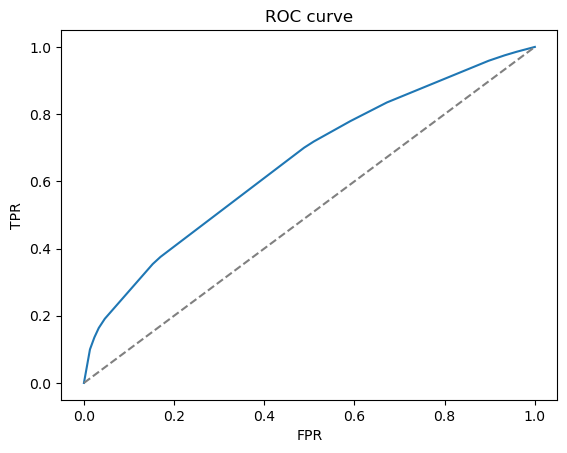

In [264]:
fpr, tpr, _ = metrics.roc_curve(results_df[('y_test', 'HasDetections')], results_df['HasDetections'])

plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

K-FOLD

In [265]:
kf = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
scores_list = []
for train_index, test_index in kf.split(X_train_, y_train_):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_train_.iloc[train_index], X_train_.iloc[test_index]
    y_train, y_test = y_train_.iloc[train_index], y_train_.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth=8, random_state=42)
    dt.fit(X_train, y_train)
    _score = dt.score(X_test, y_test)
    scores_list.append(_score)
    #print(_scores)
scores_list


[0.6192705882352941,
 0.6211058823529412,
 0.6191529411764706,
 0.6219764705882352,
 0.6151294117647059,
 0.6211058823529412,
 0.6166352941176471,
 0.6199529411764706,
 0.6200705882352942,
 0.6176705882352941]

#### 5.2.2. Random Forest

In [266]:
X_train, X_test, y_train, y_test, X_val, y_val = validation_strategy_cl(df_m)

In [267]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

##### 5.2.2.1. Model Evaluation

In [268]:
results_df = model_evaluation(X_test, y_test, rf_model)
results_df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\797645318.py:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_df = results_df.join(y_score)


,"(y_test, HasDetections)","(y_test_pred, HasDetections)","(Success, )",HasDetections
337518,0,0,1,0.428143
160126,0,0,1,0.494783
68942,0,0,1,0.421836
51574,1,1,1,0.657013
81450,1,0,0,0.351419
...,...,...,...,...
98572,0,0,1,0.411894
153738,1,0,0,0.429499
381348,0,0,1,0.412232
253051,0,0,1,0.497001


In [269]:
predictions_cl(X_test, y_test, X_val, y_val, rf_model)

Accuracy test: 0.619, Accuracy validation: 0.619, F1 score: 0.648


In [270]:
confusion_matrix = pd.crosstab(y_test, y_pred)
confusion_matrix

col_0,0,1
HasDetections,,
0,22848,19337
1,13053,29762


In [271]:
auc = metrics.roc_auc_score(results_df[('y_test', 'HasDetections')], results_df['HasDetections'])
print(f'El AUC es de {round(auc, 3)}')

El AUC es de 0.673


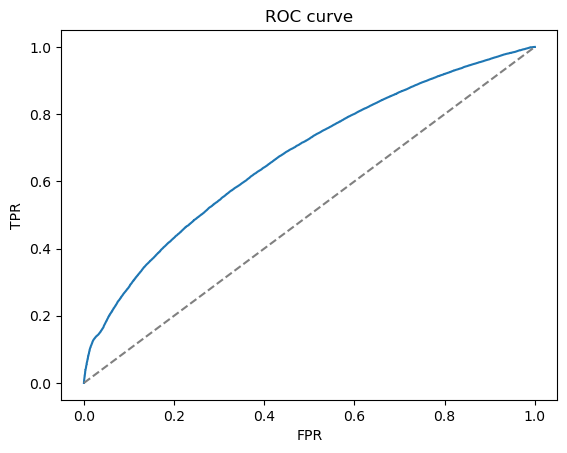

In [272]:

fpr, tpr, _ = metrics.roc_curve(results_df[('y_test', 'HasDetections')], results_df['HasDetections'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### 5.2.3. Gradient Boosting

In [273]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [274]:
y_score = pd.DataFrame(gb.predict_proba(X_test)[:,1], index=y_test.index, columns=['HasDetections'])

##### 5.2.2.1. Model Evaluation

In [275]:
results_df = model_evaluation(X_test, y_test, gb)
results_df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18784\797645318.py:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_df = results_df.join(y_score)


,"(y_test, HasDetections)","(y_test_pred, HasDetections)","(Success, )",HasDetections
337518,0,0,1,0.354558
160126,0,1,0,0.659965
68942,0,0,1,0.359444
51574,1,1,1,0.835409
81450,1,0,0,0.278443
...,...,...,...,...
98572,0,1,0,0.511807
153738,1,0,0,0.465090
381348,0,0,1,0.336276
253051,0,0,1,0.429699


In [276]:
predictions_cl(X_test, y_test, X_val, y_val, gb)

Accuracy test: 0.636, Accuracy validation: 0.635, F1 score: 0.631


In [277]:
confusion_matrix = pd.crosstab(y_test, y_pred)
confusion_matrix

col_0,0,1
HasDetections,,
0,22848,19337
1,13053,29762


In [278]:
auc = metrics.roc_auc_score(results_df[('y_test', 'HasDetections')], results_df['HasDetections'])
print(f'El AUC es de {round(auc, 3)}')

El AUC es de 0.692


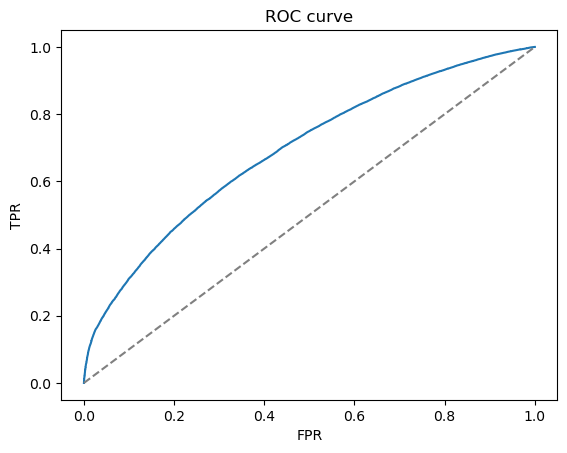

In [279]:

fpr, tpr, _ = metrics.roc_curve(results_df[('y_test', 'HasDetections')], results_df['HasDetections'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [280]:
for i in range(1, 20):
    dt = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracy = dt.score(X_train, y_train)
    test_accuracy = dt.score(X_test, y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.5735882352941176 - Test: 0.5703176470588235
Profundidad del árbol: 2. Train: 0.5853882352941177 - Test: 0.5876235294117647
Profundidad del árbol: 3. Train: 0.6067382352941176 - Test: 0.6078
Profundidad del árbol: 4. Train: 0.6067382352941176 - Test: 0.6078
Profundidad del árbol: 5. Train: 0.6124264705882353 - Test: 0.6128235294117647
Profundidad del árbol: 6. Train: 0.6167764705882353 - Test: 0.6167176470588235
Profundidad del árbol: 7. Train: 0.6188617647058824 - Test: 0.6184823529411765
Profundidad del árbol: 8. Train: 0.6236705882352941 - Test: 0.6197294117647059
Profundidad del árbol: 9. Train: 0.6280088235294118 - Test: 0.6210823529411764
Profundidad del árbol: 10. Train: 0.6324470588235294 - Test: 0.6212352941176471
Profundidad del árbol: 11. Train: 0.6395088235294117 - Test: 0.6209411764705882
Profundidad del árbol: 12. Train: 0.64705 - Test: 0.6205058823529411
Profundidad del árbol: 13. Train: 0.6569735294117647 - Test: 0.6175176470588235
Prof

#### 5.2.4. Model Comparison

In [281]:
RANDOM_STATE = 42
n_estimators = 50
max_depth = 5

models = [ 
    ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE))
]

ROC AUC Score for DecisionTree: 0.6638753951756878
ROC AUC Score for RandomForest: 0.671145101659633
ROC AUC Score for GradientBoosting: 0.6916926514620575


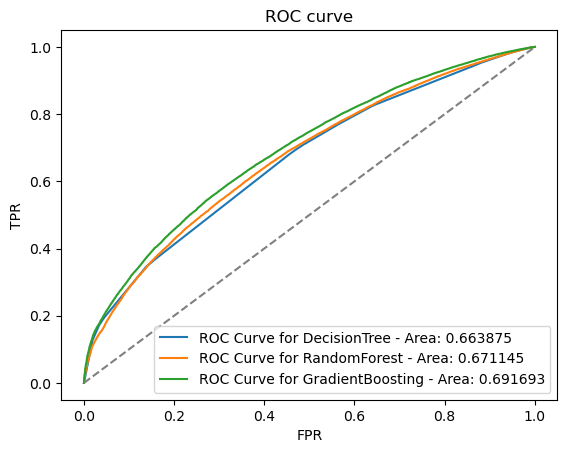

In [282]:
plt.clf()
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(X_train, np.ravel(y_train))
    predictions = model_instance.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()